# Expore data

## Import & definitions

In [1]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

In [2]:
PAST_HISTORY

72

In [3]:
21+9-24

6

In [4]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [5]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [6]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/2761487227.py:19: SyntaxWarning: invalid escape sequence '\.'
  title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)


In [7]:
# Helpers check update
def get_data_hash(data):
    data = str(data).encode('utf-8')
    return hashlib.sha256(data).hexdigest()

def load_hash(file_path):
    if not os.path.exists(file_path):
        return None
    with open(file_path, 'r') as file:
        data = file.read()
    return data

def check_hash_inputs(tuple_inputs, path_hash):
    hash_inputs = ""
    for curr_var in tuple_inputs:
        hash_inputs += get_data_hash(curr_var)

    # load old file hash
    hash_inputs_old = load_hash(path_hash)

    # compare hash
    if hash_inputs == hash_inputs_old:
        print("hash match: mode LOAD")
        return False, hash_inputs
    else:
        print("hash not match : mode REDO")
        return True, hash_inputs
    
def save_hash(path_hash, hash_inputs):
    with open(path_hash, 'w') as file:
            file.write(hash_inputs)


## Load raw features

In [8]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
# keep target untouched
df_feat_raw[f"{TARGET_NAME}_raw"] = df_feat_raw[TARGET_NAME]
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/2738736025.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0                  NaN  ...         NaN            NaN           NaN   
1                  NaN  ...         NaN            NaN           NaN   
2                  NaN  ...         NaN            NaN           NaN   
3                  NaN  ...         NaN            NaN           NaN   
4                  NaN  ...         NaN            NaN           NaN   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    NaN         0.0               NaN         0.0      0.0   
1                    NaN         0.0               NaN         0.0      0.0   
2                    NaN         0.0               NaN         0.0      0.0   
3                    NaN         0.0               NaN         0.0      0.0   
4                    NaN         0.0               NaN         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

        date  Close_ETH_raw  
0        NaN        1196.32  
1        NaN        1195.38  
2        NaN        1194.55  
3        NaN        1195.98  
4        NaN        1196.06  
...      ...            ...  
255033   NaN        2624.51  
255034   NaN        2624.26  
255035   NaN        2620.24  
255036   NaN        2616.73  
255037   NaN        2614.27  

[255038 rows x 136 columns]

### drop nan

In [9]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH             1
vwap_z_score_BTC             1
ichi_tenkan_ETH              8
ichi_tenkan_BTC              8
rsi_h_ETH                   13
max_high_h_ETH              13
min_low_h_BTC               13
max_high_h_BTC              13
min_low_h_ETH               13
rsi_h_BTC                   13
chop_h_BTC                  14
chop_h_ETH                  14
ichi_kijun_ETH              25
ichi_cloud_a_ETH            25
ichi_kijun_BTC              25
ichi_cloud_a_BTC            25
ichi_tenkan_day_BTC        215
ichi_tenkan_day_ETH        215
dxy                        264
min_low_d_BTC              335
max_high_d_ETH             335
rsi_d_BTC                  335
max_high_d_BTC             335
rsi_d_ETH                  335
chop_d_ETH                 335
chop_d_BTC                 335
min_low_d_ETH              335
ichi_kijun_day_ETH         623
ichi_cloud_a_day_BTC       623
ichi_cloud_a_day_ETH       623
ichi_kijun_day_BTC         623
fvx                    

#### Cheat Backward Filling

In [10]:
df_feat = df_feat_raw.copy()

In [11]:
df_feat = df_feat.bfill(axis ='rows')

In [12]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.710  ...         0.0            0.0           0.0   
1             1194.710  ...         0.0            0.0           0.0   
2             1194.710  ...         0.0            0.0           0.0   
3             1194.710  ...         0.0            0.0           0.0   
4             1194.710  ...         0.0            0.0           0.0   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    0.0         0.0               0.0         0.0      0.0   
1                    0.0         0.0               0.0         0.0      0.0   
2                    0.0         0.0               0.0         0.0      0.0   
3                    0.0         0.0               0.0         0.0      0.0   
4                    0.0         0.0               0.0         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  
0       2023-01-02 05:00:00        1196.32  
1       2023-01-02 05:00:00        1195.38  
2       2023-01-02 05:00:00        1194.55  
3       2023-01-02 05:00:00        1195.98  
4       2023-01-02 05:00:00        1196.06  
...                     ...            ...  
255033                  NaN        2624.51  
255034                  NaN        2624.26  
255035                  NaN        2620.24  
255036                 

In [13]:
nb_missing = get_missing(df_feat)

missing data : 
date                2688
delta_event_real    2688
delta_event_pred    2688
Previous_num        2688
Consensus_num       2688
keep                2688
Date                2688
Previous            2688
Consensus           2688
Event               2688
Country             2688
Time (ET)           2688
Actual_num          2688
Actual              2688
dtype: int64

on 255038 samples


In [14]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [15]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [16]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'Close_ETH_raw']

In [17]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0        1196.13   1196.32  1195.65    1196.32    334.5592   
1        1196.31   1196.69  1194.90    1195.38    682.3876   
2        1195.38   1195.81  1194.55    1194.55    228.9387   
3        1194.55   1195.98  1194.31    1195.98    601.8903   
4        1195.98   1196.37  1195.97    1196.06    144.8048   
...          ...       ...      ...        ...         ...   
255033   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034   2624.50   2626.90  2623.30    2624.26    977.3830   
255035   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ichi_tenkan_ETH  ...  vwap_3m_ETH  vwap_6m_ETH  \
0             1194.710         1194.710  ...  1196.096667  1196.096667   
1             1194.710         1194.710  ...  1195.801420  1195.801420   
2             1194.710         1194.710  ...  1195.648641  1195.648641   
3             1194.710         1194.710  ...  1195.575250  1195.575250   
4             1194.710         1194.710  ...  1195.615807  1195.615807   
...                ...              ...  ...          ...          ...   
255033        2630.360         2627.260  ...  2215.946820  2112.080395   
255034        2630.360         2627.260  ...  2215.970478  2112.079173   
255035        2630.360         2627.260  ...  2216.016378  2112.083189   
255036        2629.695         2624.810  ...  2216.072494  2112.088060   
255037        2628.670         2620.525  ...  2216.123423  2112.097985   

         vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH    supply_ETH  \
0       1196.096667   1196.096667         -0.634018  0.000187  1.205290e+08   
1       1195.801420   1195.801420         -0.634018 -0.000353  1.205290e+08   
2       1195.648641   1195.648641         -1.240604 -0.000920  1.205290e+08   
3       1195.575250   1195.575250          0.521593  0.000338  1.205290e+08   
4       1195.615807   1195.615807          0.626856  0.000371  1.205290e+08   
...             ...           ...               ...       ...           ...   
255033  2465.963959   2449.429165          0.244601  0.066710  1.207159e+08   
255034  2465.992103   2449.429616          0.244251  0.066621  1.207159e+08   
255035  2466.034614   2449.430717          0.238634  0.065188  1.207159e+08   
255036  2466.071410   2449.431688          0.233729  0.063934  1.207159e+08   
255037  2466.111540   2449.432810          0.230291  0.063053  1.207159e+08   

        act_addr_ETH  market_dom_ETH  Close_ETH_raw  
0             522460       17.409118        1196.32  
1             522460       17.409118        1195.38  
2             522460       17.409118        1194.55  
3             522460       17.409118        1195.98  
4             522460       17.409118        1196.06  
...              ...             ...            ...  
255033        587140        9.110644        2624.51  
255034        587140        9.110644        2624.26  
255035        587140        9.110644        2620.24  
255036        587140        9.110644        2616.73  
255037        587140      

In [18]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
    'atr_h_ETH',
    'atr_d_ETH',
    'atr_w_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [19]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [20]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'atr_h_BTC',
    'atr_d_BTC',
    'atr_w_BTC',
]

In [21]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [22]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [23]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0       3.910  3823.179932  103.494003
1       3.910  3823.179932  103.494003
2       3.910  3823.179932  103.494003
3       3.910  3823.179932  103.494003
4       3.910  3823.179932  103.494003
...       ...          ...         ...
255033  3.979  5970.529785   98.964996
255034  3.979  5970.529785   98.964996
255035  3.979  5970.529785   98.964996
255036  3.979  5970.529785   98.964996
255037  3.979  5970.529785   98.956001

[255038 rows x 3 columns]

In [24]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [25]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Close_ETH_raw',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_BTC',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [26]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [27]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other +
    [f"{TARGET_NAME}_raw"]
)

# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  108


In [28]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [29]:
get_missing(df_feat.filter(list_col_select))

missing data : 
Series([], dtype: int64)

on 255038 samples


Series([], dtype: int64)

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [30]:
df_feat.shape[0]

255038

In [31]:
TRAIN_SPLIT_RATIO

0.995

In [32]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

253763

In [33]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0             1194.710  ...            0.0           0.0               0.0   
1             1194.710  ...            0.0           0.0               0.0   
2             1194.710  ...            0.0           0.0               0.0   
3             1194.710  ...            0.0           0.0               0.0   
4             1194.710  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
255033         0.0               NaN         0.0      0.0   
255034         0.0               NaN         0.0      0.0   
255035         0.0               NaN         0.0      0.0   
255036         0.0               NaN         0.0      0.0   
255037         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
255033                  NaN        2624.51  False  
255034                  NaN        2624.26  False  
255035                  NaN        2620.24  False  
255036                  NaN        2616.73  False  
255037                  NaN        2614.27  F

In [34]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
253759  1748658600000   2504.91   2505.00  2492.22    2495.20   4235.1902   
253760  1748658900000   2495.21   2503.27  2494.44    2502.12   2576.0733   
253761  1748659200000   2502.11   2502.60  2498.13    2498.60   1382.7143   
253762  1748659500000   2498.60   2500.40  2496.37    2498.75   1450.5001   
253763  1748659800000   2498.75   2502.00  2485.40    2492.50   3607.3172   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
253759  2025-05-31 02:30:00       2528.067500       2546.470000   
253760  2025-05-31 02:35:00       2526.930000       2546.470000   
253761  2025-05-31 02:40:00       2525.150000       2546.470000   
253762  2025-05-31 02:45:00       2525.150000       2546.470000   
253763  2025-05-31 02:50:00       2524.310000       2546.470000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0              1194.71  ...            0.0           0.0               0.0   
1              1194.71  ...            0.0           0.0               0.0   
2              1194.71  ...            0.0           0.0               0.0   
3              1194.71  ...            0.0           0.0               0.0   
4              1194.71  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
253759         2505.22  ...            NaN           NaN               NaN   
253760         2505.22  ...            NaN           NaN               NaN   
253761         2505.22  ...            NaN           NaN               NaN   
253762         2505.22  ...            NaN           NaN               NaN   
253763         2505.22  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
253759         0.0               NaN         0.0      0.0   
253760         0.0               NaN         0.0      0.0   
253761         0.0               NaN         0.0      0.0   
253762         0.0               NaN         0.0      0.0   
253763         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
253759                  NaN        2495.20   True  
253760                  NaN        2502.12   True  
253761                  NaN        2498.60   True  
253762                  NaN        2498.75   True  
253763                  NaN        2492.50   

In [35]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
253764  1748660100000   2492.49   2493.17  2487.12    2490.22   2272.6386   
253765  1748660400000   2490.21   2496.84  2489.04    2491.71   1715.3111   
253766  1748660700000   2491.71   2496.80  2485.23    2490.01   1743.7758   
253767  1748661000000   2490.00   2496.59  2488.06    2496.04   1652.4027   
253768  1748661300000   2496.04   2499.85  2486.99    2490.40   2457.9952   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
253764  2025-05-31 02:55:00         2523.4350          2546.470   
253765  2025-05-31 03:00:00         2521.7675          2546.470   
253766  2025-05-31 03:05:00         2521.5525          2546.470   
253767  2025-05-31 03:10:00         2521.3800          2546.470   
253768  2025-05-31 03:15:00         2521.8325          2544.585   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00         2641.5250          2635.690   
255034  2025-06-04 12:45:00         2641.5250          2635.690   
255035  2025-06-04 12:50:00         2641.3500          2636.225   
255036  2025-06-04 12:55:00         2641.3500          2636.225   
255037  2025-06-04 13:00:00         2641.3500          2636.225   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
253764        2501.755  ...            NaN           NaN               NaN   
253765        2501.600  ...            NaN           NaN               NaN   
253766        2501.600  ...            NaN           NaN               NaN   
253767        2501.600  ...            NaN           NaN               NaN   
253768        2501.600  ...            NaN           NaN               NaN   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  date  \
253764         0.0               NaN         0.0      0.0   NaN   
253765         0.0               NaN         0.0      0.0   NaN   
253766         0.0               NaN         0.0      0.0   NaN   
253767         0.0               NaN         0.0      0.0   NaN   
253768         0.0               NaN         0.0      0.0   NaN   
...            ...               ...         ...      ...   ...   
255033         0.0               NaN         0.0      0.0   NaN   
255034         0.0               NaN         0.0      0.0   NaN   
255035         0.0               NaN         0.0      0.0   NaN   
255036         0.0               NaN         0.0      0.0   NaN   
255037         0.0               NaN         0.0      0.0   NaN   

        Close_ETH_raw  train  
253764        2490.22  False  
253765        2491.71  False  
253766        2490.01  False  
253767        2496.04  False  
253768        2490.40  False  
...               ...    ...  
255033        2624.51  False  
255034        2624.26  False  
255035        2620.24  False  
255036        2616.73  False  
255037        2614.27  False  

[1274 rows x 137 columns]

In [36]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):
    # Close ETH need to be in first place
    # we divide by close ETH price all price dependent features except the first Close ETH
    # in a matrix
    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                p_close = out_matrix[-1, 0] # last past history lag, first feature = Close ETH
                # scaling : price dependent features divide by Close ETH 
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / p_close
                )
                # keep Price Close with no scaling
                #out_matrix[-1, 0] = p_close
                
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [37]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [38]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [39]:
df_feat[df_feat["train"] == True].shape[0]

253764

In [40]:
df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET

253677

In [41]:
n_feat = df_feat.loc[df_feat["train"] == True, list_col_select].shape[1]
n_feat

108

In [42]:
# create X_train on disk
#filename = os.path.join(path_data, 'X_train.dat')
#print(filename)
X_train_dat = np.memmap(
    path_X_train, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [43]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [44]:
X_test = []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for index, seq in enumerate(gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        )):
        if is_train:
            # don't use append here but assign to X_train_dat
            X_train_dat[index] = seq # PAST_HISTORY * n_feat
            #X_train.append(seq)
        else:
            X_test.append(seq)
        
        #index += 1
    if is_train:
        X_train_dat.flush()

    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

#X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

#print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1187, 72, 108) (1187, 15)


In [45]:
X_train_dat

memmap([[[1.0014901e+00, 1.0013311e+00, 1.0014901e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1963199e+03],
         [1.0007032e+00, 1.0014818e+00, 1.0017998e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1953800e+03],
         [1.0000083e+00, 1.0007032e+00, 1.0010632e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945500e+03],
         ...,
         [9.9983257e-01, 9.9962330e-01, 9.9984092e-01, ...,
          0.0000000e+00, 0.0000000e+00, 1.1943400e+03],
         [9.9977398e-01, 9.9984092e-01, 9.9987441e-01, ...,
          0.0000000e+00, 0.0000000e+00, 1.1942700e+03],
         [1.0000000e+00, 9.9978232e-01, 1.0001088e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945400e+03]],

        [[1.0002427e+00, 1.0010208e+00, 1.0013388e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1953800e+03],
         [9.9954814e-01, 1.0002427e+00, 1.0006025e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945500e+03],
         [1.0007447e+00, 9.9954814e-01, 1.0007447e+00, .

In [46]:
assert df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

In [47]:
X_train_dat.shape

(253677, 72, 108)

In [48]:
X_train_dat[0,:,:].shape

(72, 108)

Close_ETH normalized by Close_ETH at last lag of the past history

In [49]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

In [50]:
list_col_select[1]

'Open_ETH'

In [51]:
X_train_dat[0,:,1]

memmap([1.0013311 , 1.0014818 , 1.0007032 , 1.0000083 , 1.0012054 ,
        1.0012724 , 1.0017413 , 0.99985766, 0.99973214, 0.9992466 ,
        1.000092  , 1.0002344 , 0.9996233 , 0.99964005, 1.0009711 ,
        1.0007032 , 1.0006949 , 1.0008874 , 1.0007617 , 1.0005022 ,
        1.000159  , 1.0003182 , 1.0008371 , 1.0006781 , 1.0012306 ,
        0.99972373, 0.9998493 , 1.0005609 , 1.0006614 , 1.0007032 ,
        1.0013311 , 1.0018417 , 1.0011386 , 1.0006195 , 1.0009376 ,
        1.0007617 , 1.0007284 , 0.99878615, 0.99918795, 0.99886984,
        0.9978318 , 0.99904567, 0.99903727, 0.99904567, 0.9994391 ,
        0.99954796, 0.99957305, 0.99986607, 0.9995898 , 0.9993721 ,
        0.998535  , 0.99840105, 0.9983006 , 0.99802434, 0.99802434,
        0.9980746 , 0.998602  , 0.99789876, 0.9980997 , 0.99825037,
        0.9986438 , 0.9990038 , 0.9988364 , 0.9989536 , 0.99891174,
        0.9991796 , 0.999707  , 0.9995228 , 0.99922985, 0.9996233 ,
        0.9998409 , 0.9997823 ], dtype=float32)

Close_ETH_raw

In [52]:
list_col_select[-1]

'Close_ETH_raw'

In [53]:
X_train_dat[0,:,-1]

memmap([1196.32, 1195.38, 1194.55, 1195.98, 1196.06, 1196.61, 1194.36,
        1194.22, 1193.64, 1194.64, 1194.82, 1194.09, 1194.1 , 1195.69,
        1195.38, 1195.38, 1195.6 , 1195.45, 1195.14, 1194.73, 1194.92,
        1195.53, 1195.35, 1196.02, 1194.21, 1194.37, 1195.22, 1195.33,
        1195.38, 1196.12, 1196.74, 1195.9 , 1195.27, 1195.66, 1195.45,
        1195.4 , 1193.09, 1193.57, 1193.2 , 1191.95, 1193.39, 1193.38,
        1193.41, 1193.86, 1194.  , 1194.04, 1194.39, 1194.04, 1193.79,
        1192.8 , 1192.64, 1192.51, 1192.18, 1192.18, 1192.25, 1192.87,
        1192.04, 1192.26, 1192.44, 1192.92, 1193.35, 1193.15, 1193.29,
        1193.25, 1193.57, 1194.18, 1193.96, 1193.61, 1194.1 , 1194.34,
        1194.27, 1194.54], dtype=float32)

## Standardization

In [54]:
# check if new  data in df_feat
# hash input
hash_df_feat = get_data_hash(df_feat)
# load df_prob file hash
path_feat_hash = os.path.join(path_data, 'df_feat_hash.txt')
# hash df_prob data
hash_df_feat_old = load_hash(path_feat_hash)

# compare hash
if hash_df_feat == hash_df_feat_old:
    print("hash match: mode NO REDO rescaling")
    mode_rescale = False
else:
    print("hash not match : mode REDO rescaling")
    mode_rescale = True


hash match: mode NO REDO rescaling


In [55]:
mode_rescale = True

In [56]:
path_scaler

'data/scaler.bin'

In [57]:
X_train_sca_dat = np.memmap(
    path_X_train_sca, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [58]:
list_col_select_global

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [59]:
# Peak memory : 17Gb !
# need to rescale minmax for some entries
list_min_max = ['day_off',
 'event_pred',
 'event_real']

if mode_rescale:
    scaler = StandardScaler()
    scaler.fit(X_train_dat.reshape(-1,X_train_dat.shape[-1]))
    for col in list_min_max:
        i_col = list_col_select.index(col)
        scaler.scale_[i_col] = 1
        scaler.mean_[i_col] = 0
    #X_train_sca_dat[:] = scaler.fit_transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)

    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
    # save hash
    with open(path_feat_hash, 'w') as file:
        file.write(hash_df_feat)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [60]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99883363, 0.98687133, 0.99429154, ..., 0.99716965, 0.99328838,
        0.99604309],
       [0.98802374, 0.99545261, 0.99552833, ..., 0.99444827, 0.9972062 ,
        0.99580333],
       [1.00751892, 1.00759556, 1.00489698, ..., 1.00929377, 1.00787389,
        1.0079344 ]], shape=(253677, 15))

In [61]:
np.mean(y_train_sca)

np.float64(-6.796516874623723e-14)

In [62]:
np.std(y_train_sca)

np.float64(1.0)

In [63]:
np.mean(y_test_sca)

np.float64(0.04559068417215605)

In [64]:
np.std(y_test_sca)

np.float64(0.7247543709407388)

In [65]:
scaler.scale_

array([1.11758415e-02, 1.13341565e-02, 1.12647813e-02, 1.12758084e-02,
       1.58659704e-02, 1.69234305e-02, 1.21560721e-02, 1.15278091e-02,
       7.03027864e-02, 7.55225456e-02, 2.51978066e-02, 1.78609548e-02,
       1.79899755e-01, 1.86481614e-01, 6.00531676e-02, 3.71399331e-02,
       1.23344466e-02, 1.24286029e-02, 2.63323536e-02, 2.63300194e-02,
       6.16530272e-02, 5.58715498e-02, 1.16466161e-02, 1.19718808e-02,
       1.62849751e-02, 6.55955514e-02, 1.22452620e-01, 1.82853823e-01,
       8.65035270e-02, 1.98142910e-01, 2.17634523e-03, 1.35787848e-03,
       1.07704011e-03, 9.58206494e+00, 9.59168327e+00, 9.57255368e+00,
       9.58205875e+00, 9.58213332e+00, 9.58036073e+00, 9.58100748e+00,
       9.58197494e+00, 9.62146355e+00, 9.59714636e+00, 9.55135518e+00,
       9.57274515e+00, 9.94294768e+00, 1.00965276e+01, 9.41614582e+00,
       9.52746475e+00, 9.62102516e+00, 9.54307203e+00, 9.77353007e+00,
       9.36669447e+00, 1.00480262e+01, 8.98767280e+00, 9.58182442e+00,
      

In [66]:
scaler.scale_.shape

(108,)

In [67]:
scaler.scale_[-4:]

array([  1.        ,   1.        ,   1.        , 717.47630208])

In [68]:
scaler.mean_[-4:]

array([   0.        ,    0.        ,    0.        , 2419.09062826])

In [69]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

### Check unscaling

In [70]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       2419.198618       2418.400385   
1    1195.38   1196.31   1196.69  1194.90       2419.198618       2418.400385   
2    1194.55   1195.38   1195.81  1194.55       2419.198618       2418.400385   
3    1195.98   1194.55   1195.98  1194.31       2419.198618       2418.400385   
4    1196.06   1195.98   1196.37  1195.97       2419.198618       2418.400385   
5    1196.61   1196.06   1196.70  1196.06       2419.198618       2418.400385   
6    1194.36   1196.62   1196.62  1193.72       2419.198618       2418.400385   
7    1194.22   1194.37   1194.43  1192.72       2419.198618       2418.400385   
8    1193.64   1194.22   1194.22  1193.02       2419.198618       2418.400385   
9    1194.64   1193.64   1195.06  1193.63       2419.198618       2418.400385   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           2418.060398   
1         1194.71          1194.71           2418.060398   
2         1194.71          1194.71           2418.060398   
3         1194.71          1194.71           2418.060398   
4         1194.71          1194.71           2418.060398   
5         1194.71          1194.71           2418.060398   
6         1194.71          1194.71           2418.060398   
7         1194.71          1194.71           2418.060398   
8         1194.71          1194.71           2418.060398   
9         1194.71          1194.71           2418.060398   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
1           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
2           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
3           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
4           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
5           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
6           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
7           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
8           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
9           2410.350542  ...       1.0       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  day_off  event_pred  event_real  \
0           0.97953          0.201299      0.0         0.0         0.0   
1           0.97953          0.201299      0.0         0.0         0.0   
2           0.97953          0.201299      0.0         0.0         0.0   
3           0.97953          0.201299      0.0         0.0         0.0   
4           0.97953          0.201299      0.0         0.0         0.0   
5           0.97953          0.201299      0.0         0.0         0.0   
6           0.97953          0.201299      0.0         0.0         0.0   
7           0.97953          0.201299      0.0         0.0         0.0   
8           0.97953          0.201299      0.0         0.0         0.0   
9           0.97953          0.201299      0.0         0.0         0.0   

   Close_ETH_raw  
0        1196.32  
1        1195.38  
2        1194.55  
3        1195.98  
4        1196.06  
5        1196.61  
6        1194.36  
7        1194.22  
8        1193.64  
9        1194.64  

[10 rows x 108 columns]

In [71]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [72]:
X_train_sca_dat.shape

(253677, 72, 108)

In [73]:
np.testing.assert_array_almost_equal(
    scaler.inverse_transform(X_train_sca_dat[-1,-1,:].reshape(1,-1)).squeeze(),
    X_train_dat[-1,-1,:],
    decimal=5)

## Check Inputs TRAIN/TEST 

In [74]:
X_train_sca_dat[:,-1,:].shape

(253677, 108)

In [75]:
X_test[:,-1,:].shape

(1187, 108)

In [76]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca_dat[:,-1,:], np.ones((X_train_sca_dat.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0        0.003863 -0.015292 -0.082240  0.083241         -0.036673   
1        0.003863 -0.035954 -0.091161  0.062472         -0.061043   
2        0.003863  0.011297 -0.074811  0.089183         -0.056302   
3        0.003863  0.071889 -0.023508  0.094373         -0.005289   
4        0.003863 -0.055159 -0.089669  0.043907         -0.036263   
...           ...       ...       ...       ...               ...   
254859   0.003863  0.092026  0.079341  0.068936          0.105432   
254860   0.003863  0.026366 -0.069311 -0.016969          0.103060   
254861   0.003863  0.165733  0.070914  0.052666          0.199633   
254862   0.003863 -0.100039 -0.052764 -0.069291          0.124916   
254863   0.003863  0.066329  0.012765  0.091143          0.173177   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.012806       -0.107057        -0.032204   
1              -0.014380       -0.130058        -0.056495   
2              -0.009936       -0.119399        -0.031097   
3               0.035065       -0.056818         0.034977   
4              -0.004498       -0.111838        -0.023114   
...                  ...             ...              ...   
254859          0.010549        0.232271         0.185398   
254860          0.025358        0.237947         0.154305   
254861          0.133503        0.346017         0.268111   
254862          0.063534        0.240429         0.156868   
254863          0.105586        0.299091         0.218666   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  \
0                  14.569584             13.496038  ...  1.365978   
1                  14.556331             13.483742  ...  1.414164   
2                  14.558501             13.485753  ...  1.414164   
3                  14.580433             13.506105  ...  1.414164   
4                  14.561150             13.488213  ...  1.414164   
...                      ...                   ...  ...       ...   
254859             -0.653008             -0.006914  ...  0.366028   
254860             -0.649606             -0.003601  ...  0.366028   
254861             -0.624761              0.020592  ...  0.366028   
254862             -0.640835              0.004939  ...  0.366028   
254863             -0.631175              0.014347  ...  0.366028   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
0          0.880986    -1.107987          1.388078          0.284506      0.0   
1          0.880986    -1.107987          1.388078          0.284506      0.0   
2          0.880986    -1.107987          1.388078          0.284506      0.0   
3          0.880986    -1.107987          1.388078          0.284506      0.0   
4          0.880986    -1.107987          1.388078          0.284506      0.0   
...             ...          ...               ...               ...      ...   
254859    -0.314856     1.377693          0.948816          1.050286      0.0   
254860    -0.314856     1.377693          0.948816          1.050286      0.0   
254861    -0.314856     1.377693          0.948816          1.050286      0.0   
254862    -0.314856     1.377693          0.948816          1.050286      0.0   
254863    -0.314856     1.377693          0.948816          1.050286      0.0   

        event_pred  event_real  Close_ETH_raw  TRAIN  
0              0.0         0.0      -1.706747    1.0  
1              0.0         0.0      -1.705981    1.0  
2              0.0         0.0      -1.706106    1.0  
3              0.0         0.0      -1.707374    1.0  
4              0.0         0.0      -1.706259    1.0  
...            ...         ...            ...    ...  
254859         0.0         0.0       0.298796    0.0  
254860         0.0         0.0       0.297877    0.0  
254861         0.0         0.0       0.291173    0.0  
254862         0.0         0.0       0.295507    0.0  
254863         0.0         0.0       0.

In [77]:
df["event_real"].mean()

np.float64(1.9618306233912988e-05)

In [78]:
df["event_real"].std()

np.float64(0.0138657769553898)

#### SAve

In [79]:
df.to_csv(path_save_df_feat_std, index=False)

In [80]:
df[df["TRAIN"] == 1].describe()

Close_ETH       Open_ETH       High_ETH        Low_ETH  \
count  253677.000000  253677.000000  253677.000000  253677.000000   
mean        0.003863       0.003819       0.003891       0.003781   
std         0.000000       0.166514       0.128898       0.131373   
min         0.003863      -5.116099      -0.091902      -7.984509   
25%         0.003863      -0.063221      -0.071034      -0.026482   
50%         0.003863       0.003550      -0.031963       0.040080   
75%         0.003863       0.069218       0.033532       0.080344   
max         0.003863       8.303201       8.434505       0.103286   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count     253677.000000     253677.000000   253677.000000    253677.000000   
mean           0.001458          0.001317        0.003542         0.003754   
std            0.638363          0.688512        0.380625         0.242701   
min           -7.300909         -6.986154       -6.596560        -5.580196   
25%           -0.247243         -0.277757       -0.161263        -0.101731   
50%           -0.001877          0.003434        0.009087         0.006637   
75%            0.237180          0.268948        0.172205         0.112400   
max           13.391198         13.445843        6.113667         5.187875   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...       hour_sin  \
count         253677.000000         253677.000000  ...  253677.000000   
mean              -0.001363             -0.001268  ...      -0.000186   
std                0.972563              0.976705  ...       0.999941   
min               -3.855338             -3.569981  ...      -1.414124   
25%               -0.399892             -0.440495  ...      -0.999931   
50%               -0.040914             -0.036834  ...       0.000020   
75%                0.285727              0.346492  ...       0.999971   
max               14.599020             13.523352  ...       1.414164   

         weekday_cos    weekday_sin  day_in_month_cos  day_in_month_sin  \
count  253677.000000  253677.000000     253677.000000     253677.000000   
mean       -0.000240       0.000020          0.000002         -0.000061   
std         1.000012       0.999992          1.000005          0.999999   
min        -1.273847      -1.381204         -1.413257         -1.413265   
25%        -1.273847      -1.107987         -1.025499         -1.024320   
50%        -0.314856      -0.001755         -0.069782          0.000015   
75%         0.880986       1.104476          0.976888          1.024350   
max         1.413185       1.377693          1.417047          1.413294   

             day_off     event_pred     event_real  Close_ETH_raw     TRAIN  
count  253677.000000  253677.000000  253677.000000  253677.000000  253677.0  
mean        0.002957       0.000004       0.000020       0.000261       1.0  
std         0.054294       0.013898       0.013898       0.999800       0.0  
min         0.000000      -1.000000      -1.000000      -1.708448       1.0  
25%         0.000000       0.000000       0.000000      -0.839764       1.0  
50%         0.000000       0.000000       0.000000      -0.179366       1.0  
75%         0.000000       0.000000       0.000000       0.904907       1.0  
max         1.000000       1.000000       1.000000       2.331393       1.0  

[8 rows x 109 columns]

In [81]:
df[df["TRAIN"] == 0].describe()

Close_ETH     Open_ETH     High_ETH      Low_ETH  ichi_cloud_a_ETH  \
count  1187.000000  1187.000000  1187.000000  1187.000000       1187.000000   
mean      0.003863     0.001164    -0.001267     0.007113         -0.071876   
std       0.000000     0.125820     0.084316     0.087111          0.494191   
min       0.003863    -0.440208    -0.091902    -0.398262         -1.694651   
25%       0.003863    -0.073301    -0.063258    -0.035729         -0.341493   
50%       0.003863     0.005585    -0.022363     0.030180         -0.019822   
75%       0.003863     0.078452     0.037270     0.072182          0.253608   
max       0.003863     0.741728     0.656495     0.103286          1.168894   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count       1187.000000     1187.000000      1187.000000   
mean          -0.098014       -0.024533        -0.003600   
std            0.498285        0.310941         0.186444   
min           -1.789058       -1.006730        -0.536961   
25%           -0.338601       -0.237893        -0.132364   
50%           -0.047284       -0.010749        -0.000158   
75%            0.229717        0.181375         0.123016   
max            1.131432        0.972224         0.647162   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...     hour_sin  \
count           1187.000000           1187.000000  ...  1187.000000   
mean               0.244220              0.428947  ...     0.022116   
std                0.599465              0.290705  ...     0.994721   
min               -0.751890             -0.083843  ...    -1.414124   
25%               -0.398918              0.124060  ...    -0.999931   
50%                0.489683              0.491148  ...     0.000020   
75%                0.838479              0.686164  ...     0.999971   
max                1.137881              0.927415  ...     1.414164   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
count  1187.000000  1187.000000       1187.000000       1187.000000   1187.0   
mean      0.684706    -0.049403          1.258664          0.537090      0.0   
std       0.647830     1.053707          0.150212          0.333506      0.0   
min      -0.314856    -1.381204          0.948816          0.000015      0.0   
25%      -0.314856    -1.107987          1.146777          0.293852      0.0   
50%       0.880986    -0.001755          1.294700          0.574847      0.0   
75%       0.880986     1.104476          1.386122          0.830720      0.0   
max       1.413185     1.377693          1.417047          1.050286      0.0   

       event_pred  event_real  Close_ETH_raw   TRAIN  
count      1187.0      1187.0    1187.000000  1187.0  
mean          0.0         0.0       0.191746     0.0  
std           0.0         0.0       0.070069     0.0  
min           0.0         0.0       0.082385     0.0  
25%           0.0         0.0       0.136408     0.0  
50%           0.0         0.0       0.168074     0.0  
75%           0.0         0.0       0.266677     0.0  
max           0.0         0.0       0.320288     0.0  

[8 rows x 109 columns]

#### check out of range

In [82]:
df_min = df.groupby(df["TRAIN"]).min().transpose()
df_min

TRAIN                  0.0       1.0
Close_ETH         0.003863  0.003863
Open_ETH         -0.440208 -5.116099
High_ETH         -0.091902 -0.091902
Low_ETH          -0.398262 -7.984509
ichi_cloud_a_ETH -1.694651 -7.300909
...                    ...       ...
day_in_month_sin  0.000015 -1.413265
day_off           0.000000  0.000000
event_pred        0.000000 -1.000000
event_real        0.000000 -1.000000
Close_ETH_raw     0.082385 -1.708448

[108 rows x 2 columns]

In [83]:
df_min["out_min"] = df_min[0] < (df_min[1] - 1e-6)
df_min


TRAIN                  0.0       1.0  out_min
Close_ETH         0.003863  0.003863    False
Open_ETH         -0.440208 -5.116099    False
High_ETH         -0.091902 -0.091902    False
Low_ETH          -0.398262 -7.984509    False
ichi_cloud_a_ETH -1.694651 -7.300909    False
...                    ...       ...      ...
day_in_month_sin  0.000015 -1.413265    False
day_off           0.000000  0.000000    False
event_pred        0.000000 -1.000000    False
event_real        0.000000 -1.000000    False
Close_ETH_raw     0.082385 -1.708448    False

[108 rows x 3 columns]

In [84]:
sum(df_min["out_min"].values)

np.int64(0)

In [85]:
df_max = df.groupby(df["TRAIN"]).max().transpose()
df_max

TRAIN                  0.0        1.0
Close_ETH         0.003863   0.003863
Open_ETH          0.741728   8.303201
High_ETH          0.656495   8.434505
Low_ETH           0.103286   0.103286
ichi_cloud_a_ETH  1.168894  13.391198
...                    ...        ...
day_in_month_sin  1.050286   1.413294
day_off           0.000000   1.000000
event_pred        0.000000   1.000000
event_real        0.000000   1.000000
Close_ETH_raw     0.320288   2.331393

[108 rows x 2 columns]

In [86]:
df_max[0]

Close_ETH           0.003863
Open_ETH            0.741728
High_ETH            0.656495
Low_ETH             0.103286
ichi_cloud_a_ETH    1.168894
                      ...   
day_in_month_sin    1.050286
day_off             0.000000
event_pred          0.000000
event_real          0.000000
Close_ETH_raw       0.320288
Name: 0.0, Length: 108, dtype: float64

In [87]:
df_max[1]

Close_ETH            0.003863
Open_ETH             8.303201
High_ETH             8.434505
Low_ETH              0.103286
ichi_cloud_a_ETH    13.391198
                      ...    
day_in_month_sin     1.413294
day_off              1.000000
event_pred           1.000000
event_real           1.000000
Close_ETH_raw        2.331393
Name: 1.0, Length: 108, dtype: float64

In [88]:
df_max["out_max"] = df_max[0] > (df_max[1] + 1e-6)
df_max

TRAIN                  0.0        1.0  out_max
Close_ETH         0.003863   0.003863    False
Open_ETH          0.741728   8.303201    False
High_ETH          0.656495   8.434505    False
Low_ETH           0.103286   0.103286    False
ichi_cloud_a_ETH  1.168894  13.391198    False
...                    ...        ...      ...
day_in_month_sin  1.050286   1.413294    False
day_off           0.000000   1.000000    False
event_pred        0.000000   1.000000    False
event_real        0.000000   1.000000    False
Close_ETH_raw     0.320288   2.331393    False

[108 rows x 3 columns]

In [89]:
sum(df_max["out_max"].values)

np.int64(1)

In [90]:
df_max[df_max["out_max"] == True]

TRAIN            0.0       1.0  out_max
supply_BTC  1.422489  1.415529     True

In [91]:
nb_sample_test = df[df["TRAIN"] == False].shape[0]
print(nb_sample_test)
# min
def fun_min(value, col):
    return value < (df_min.at[col, 1] - 1e-6)
list_ser_col_min = []
for col in list_col_select:
    list_ser_col_min.append(df[df["TRAIN"] == False][col].apply(fun_min, args=(col,)))
df_count_min = pd.DataFrame(data=list_ser_col_min).transpose()


#pc_out_max = 100 * nb_out / nb_sample_test
#print(pc_out_max)
df_count_min

1187


Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [92]:
# max
def fun_max(value, col):
    return value > (df_max.at[col, 1] + 1e-6)
#nb_out = sum(df[df["TRAIN"] == False]["supply_BTC"].apply(fun_max, args=("supply_BTC",)))
list_ser_col_max = []
for col in list_col_select:
    list_ser_col_max.append(df[df["TRAIN"] == False][col].apply(fun_max, args=(col,)))
df_count_max = pd.DataFrame(data=list_ser_col_max).transpose()
df_count_max

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [93]:
ser_min = df_count_min.apply(lambda x: 100*x.sum()/ x.shape[0])
ser_max = df_count_max.apply(lambda x: 100*x.sum()/ x.shape[0])
df_count = pd.DataFrame(data=[ser_min, ser_max], index=["pc_out_min", "pc_out_max"]).transpose()
df_count_out = df_count.loc[df_count["pc_out_min"] !=0 |(df_count["pc_out_max"] !=0) , :].transpose()
df_count_out

supply_BTC
pc_out_min    0.000000
pc_out_max   84.667228

Text(0.5, 1.0, 'Percentage of TEST Out of range')

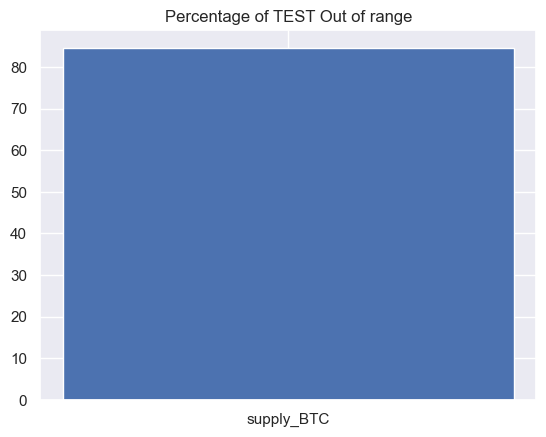

In [94]:
fig, ax = plt.subplots()
ax.bar(df_count_out.xs("pc_out_max").index.tolist(), df_count_out.xs("pc_out_max").values)
ax.bar(df_count_out.xs("pc_out_min").index.tolist(), -df_count_out.xs("pc_out_min").values)
ax.set_title("Percentage of TEST Out of range")

Text(0.5, 1.0, 'Features scaled boxplot')

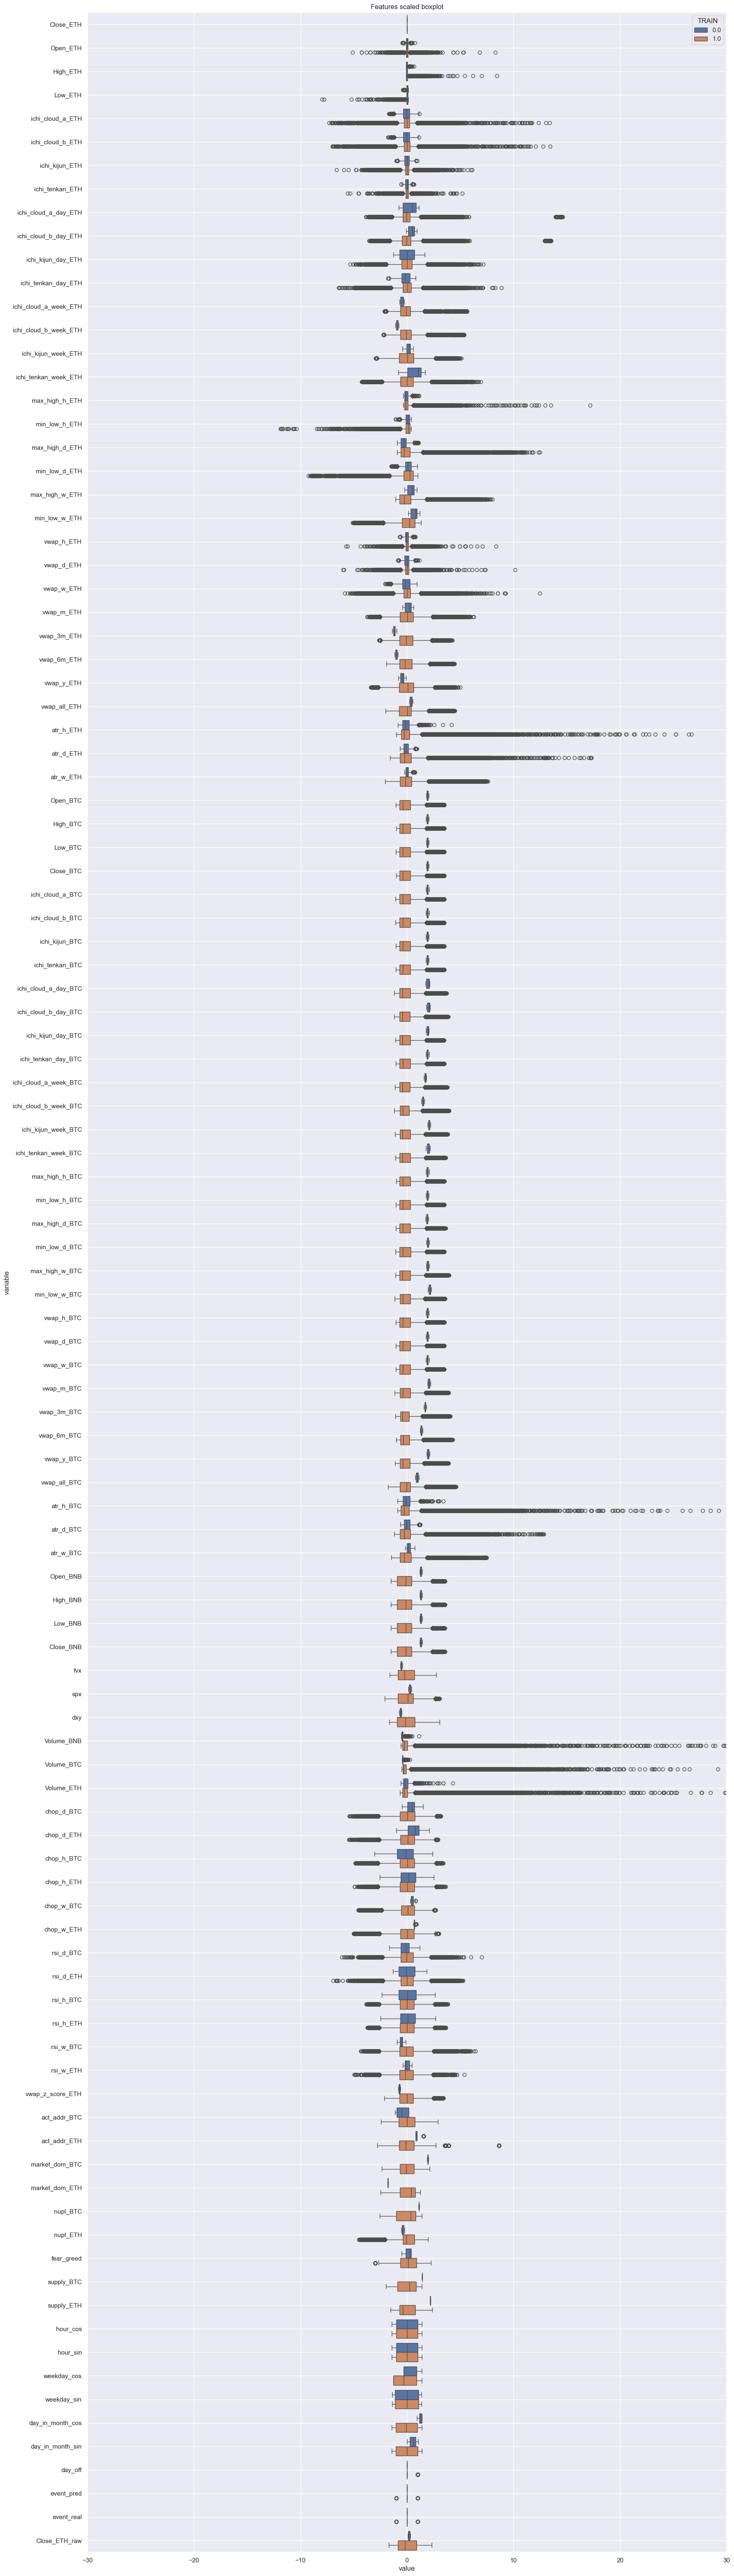

In [95]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

In [96]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0., 1.])

In [97]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()


array([0., 1.])

In [98]:
df_comp[(df_comp["TRAIN"] == False) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0.])

<Axes: >

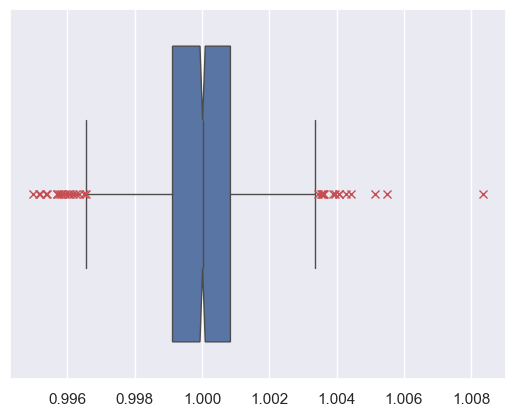

In [99]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/4208190987.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


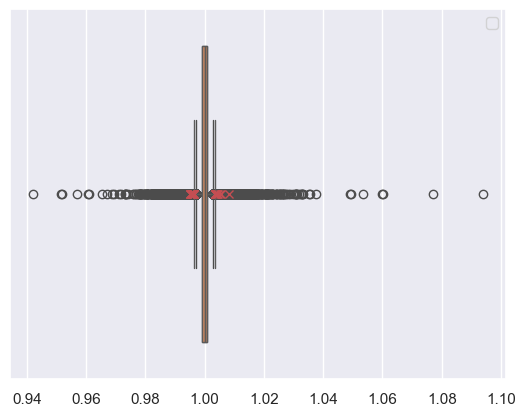

In [100]:
ax = sns.boxplot(
    x=X_train_dat[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

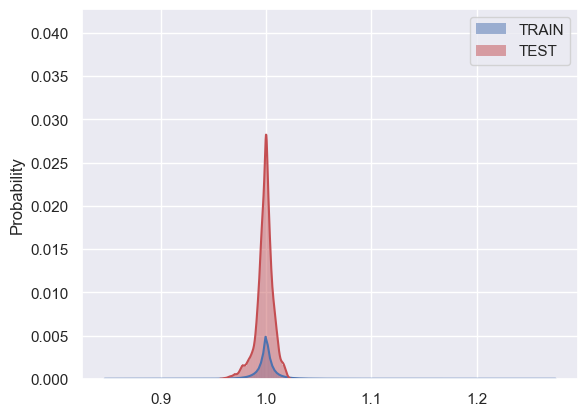

In [101]:

ax = sns.histplot(x=X_train_dat.reshape(-1, X_train_dat.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [102]:
def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=5, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    return ser_val

def contingency_table(X, Y, data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    and p value of independance
    '''
    c = data[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)

    c = c.fillna(0) # on remplace les valeurs nulles par des 0

    chi2, p, dof, expected = stats.chi2_contingency(c)

    return c, chi2, p, dof, expected



def plot_cont(X, Y, data, liste_cat=None):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c, chi2, p, dof, expected = contingency_table(X, Y, data)
    print("expected: ", expected)
    
    tx = data[X].value_counts()
    ty = data[Y].value_counts()
    
    cont = c.copy()
    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    
    print(cont)

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n
    
    # calcul du signe (add-on)
    d_sign = (c-indep) / np.fabs(c-indep)
    
    mesure = d_sign * (c-indep)**2 / indep
    
    # patch sign
    xi_n = np.fabs(mesure).sum().sum()
    print("xi_n = ", xi_n)
    
    print("chi2: ", chi2)
    print("dof: ", dof)
    print("p: ", p)
    print(f"We have we have a {100*p:.4f}% chance for H0 to be true.")
    print("H0 : independance of distributions")
    print("H1 : distribution are not independant : we reject H0")
    # plot
    #print(c.shape)
    fig = plt.figure(figsize = (7/5*c.shape[1], 6/4*c.shape[0]))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f", center=0)
    ax = fig.gca()
    ax.set_title(Y + "= f( " + X + ")")
    plt.show()
    
    return c

In [103]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None, size=25):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (size, size*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

### Linear Corr

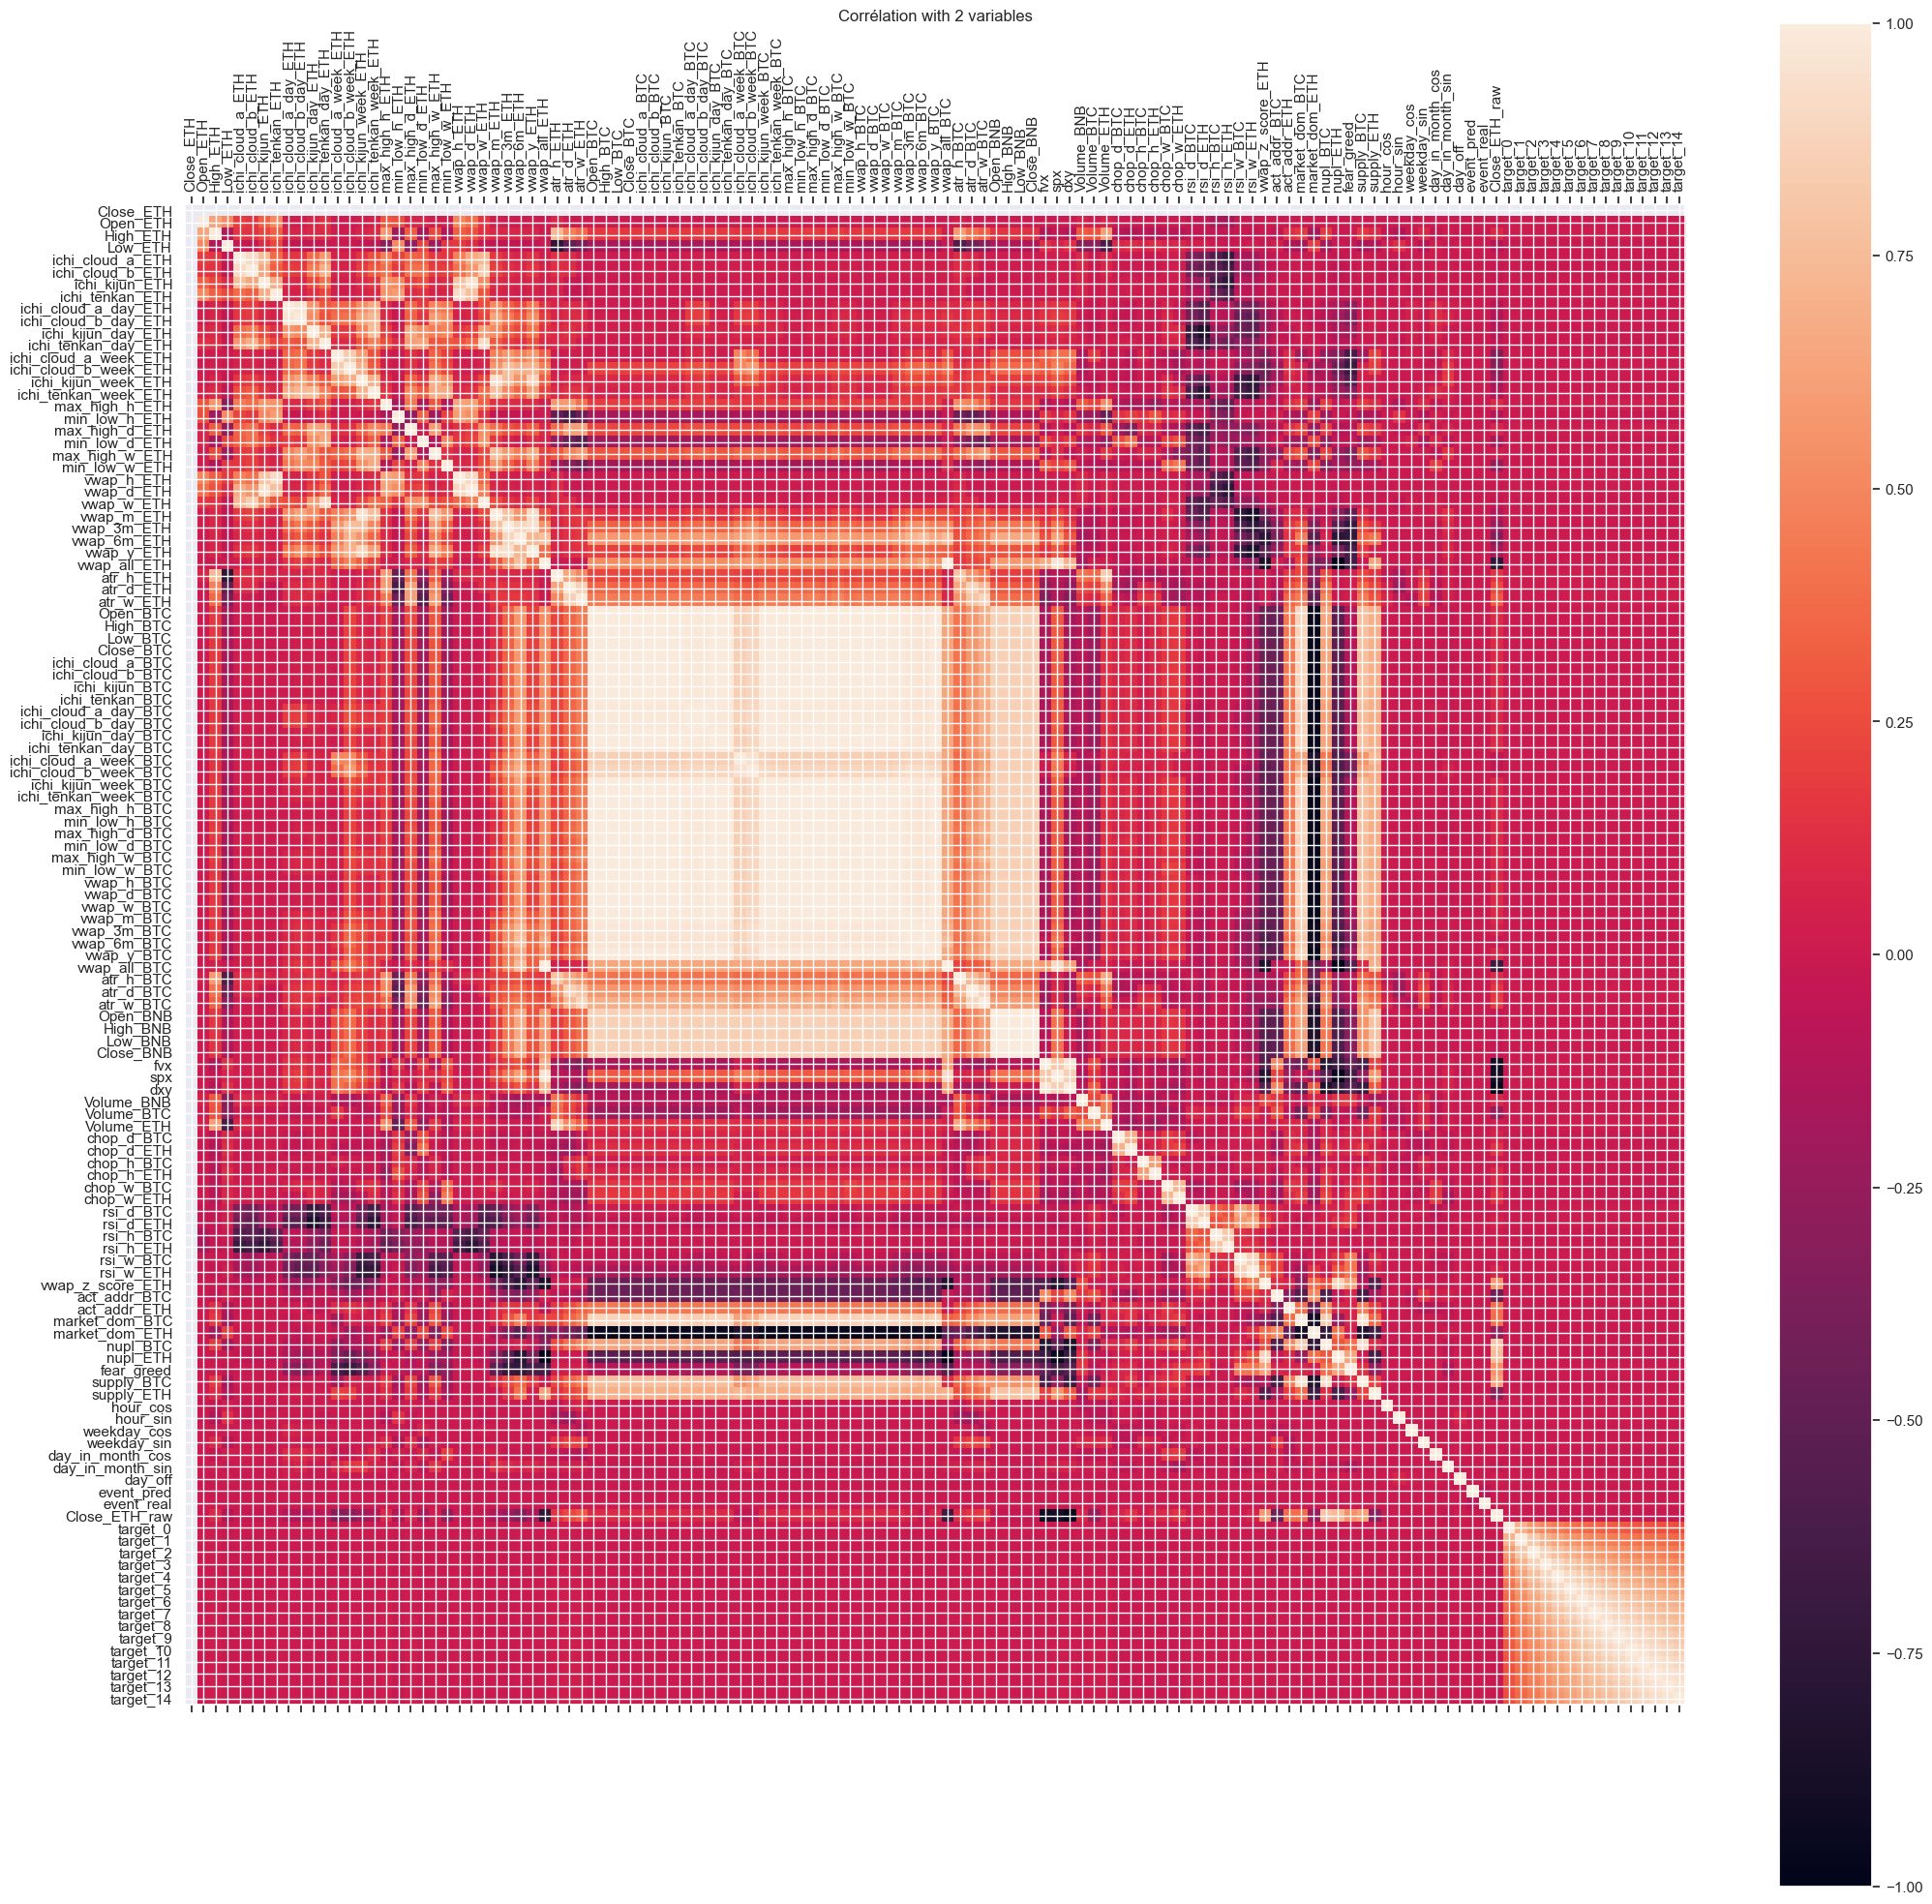

In [104]:
nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_dat[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


In [105]:
y_train.shape

(253677, 15)

In [106]:
list_col_corr

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [107]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [108]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [109]:
df.filter(list_col_targets)

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14  
0        1.000151   0.999858  
1        0.999398   0.998803  
2        0.998879   0.998594  
3        0.999355   1.000427  
4        0.999757   0.999732  
...           ...        ...  
253672   0.994823   0.993744  
253673   0.992307   0.988445  
253674   0.993288   0.996043  
253675   0.997206   0.995803  
253676   1.007874   1.007934  

[253677 rows x 15 columns]

In [110]:
df["Close_ETH_raw"].corr(df["target_14"])

np.float64(-0.01767952024837609)

In [111]:
df.filter(list_col_select).corrwith(df["target_14"])

/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Close_ETH                NaN
Open_ETH            0.006258
High_ETH            0.021161
Low_ETH            -0.014519
ichi_cloud_a_ETH   -0.008137
                      ...   
day_in_month_sin   -0.001319
day_off             0.000980
event_pred         -0.002843
event_real          0.000742
Close_ETH_raw      -0.017680
Length: 108, dtype: float64

In [112]:
df.filter(list_col_select).corrwith(df.filter(list_col_targets))

Close_BNB          NaN
Close_BTC          NaN
Close_ETH          NaN
Close_ETH_raw      NaN
High_BNB           NaN
                    ..
vwap_y_BTC         NaN
vwap_y_ETH         NaN
vwap_z_score_ETH   NaN
weekday_cos        NaN
weekday_sin        NaN
Length: 123, dtype: float64

In [113]:
len(list_col_select)

108

In [114]:
nb_plot

108

In [115]:
# check if new  data in df_feat
# hash inputs
hash_correl_inputs = (
    get_data_hash(df_feat) + 
    get_data_hash(PAST_HISTORY) + 
    get_data_hash(FUTURE_TARGET) +
    get_data_hash(X_train_dat[:, 0, :nb_plot])
)
# load old file hash
path_correl_hash = os.path.join(path_data, 'correl_inputs_hash.txt')
hash_correl_inputs_old = load_hash(path_correl_hash)

# compare hash
if hash_correl_inputs == hash_correl_inputs_old:
    print("hash match: mode LOAD correl ")
    # load data output
    arr_corr_matrix_targets = np.load(path_arr_corr_matrix_targets)
    mode_correl = False
else:
    print("hash not match : mode REDO correl")
    mode_correl = True

hash match: mode LOAD correl 


In [118]:
mode_correl = True

In [119]:
# Assuming the following variables are pre-defined from your environment:
# PAST_HISTORY: int
# X_train_dat: np.ndarray (e.g., shape: num_samples, total_past_steps, num_total_features)
# y_train: np.ndarray (e.g., shape: num_samples, num_targets or num_samples for single target)
# list_col_select: list of strings (names of all features)
# nb_plot: int (number of features to use from X_train_dat, e.g., list_col_select[:nb_plot])
# list_col_targets: list of strings (names of target columns)
# list_col_corr: list of strings (from original code, not strictly needed for optimized version but was used for column naming in the old approach)
# These are the names of the feature columns we'll be selecting from X_train_dat.
# These will form the row index of our correlation matrix for each I_past.
feature_names_to_correlate = list_col_select[:nb_plot]

if mode_correl:
    # Optimized code for calculating correlations:
    list_corr_optimized = []
    # Create a DataFrame for the target(s) once, as it's constant across I_past iterations.
    # This assumes y_train has columns corresponding to list_col_targets.
    # If y_train is 1D (num_samples,), list_col_targets should contain one target name.
    y_train_df = pd.DataFrame(y_train, columns=list_col_targets)

    for I_past in range(PAST_HISTORY):
        # Extract the relevant feature data for the current I_past step
        # Shape: (num_samples, nb_plot)
        current_X_data = X_train_dat[:, I_past, :nb_plot]
        
        # Create a DataFrame for the features of the current I_past step
        df_features = pd.DataFrame(current_X_data, columns=feature_names_to_correlate)
        
        # Initialize a DataFrame to store correlations for this I_past step
        # Rows: features (feature_names_to_correlate)
        # Columns: targets (list_col_targets)
        # This ensures consistent shape and ordering.
        corr_matrix_for_this_past_step = pd.DataFrame(
            index=feature_names_to_correlate,
            columns=list_col_targets,
            dtype=float  # Ensure float type for correlations
        )
        
        # Calculate correlation of all features with each target column
        for target_col_name in list_col_targets:
            # df_features.corrwith() computes the correlation of each column in df_features
            # with the provided Series (y_train_df[target_col_name]).
            # The result is a Series indexed by feature_names_to_correlate.
            corrs_with_target = df_features.corrwith(y_train_df[target_col_name])
            corr_matrix_for_this_past_step[target_col_name] = corrs_with_target
                
        list_corr_optimized.append(corr_matrix_for_this_past_step)

    # Convert the list of DataFrames to a 3D NumPy array
    # Each DataFrame in list_corr_optimized has shape (len_feat, len_targets)
    # So, arr_corr_matrix_targets will have shape (PAST_HISTORY, len_feat, len_targets)
    # The final variable name 'arr_corr_matrix_targets' matches the original script's output.
    arr_corr_matrix_targets = np.array([df.values for df in list_corr_optimized])
    np.save(path_arr_corr_matrix_targets, arr_corr_matrix_targets)
    # save hash
    with open(path_correl_hash, 'w') as file:
        file.write(hash_correl_inputs)
        
# To check the shape (optional, similar to original script's last line intent):
print(arr_corr_matrix_targets.shape)

/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(72, 108, 15)


In [120]:
min_corr = np.min(arr_corr_matrix_targets, axis=0)
# create a same col/row than corr_matrix_targets  dataframe using the array max_corr 
min_corr_matrix_targets = pd.DataFrame(min_corr, columns=list_col_targets, index=feature_names_to_correlate)
min_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH         -0.001701 -0.002949 -0.004338 -0.004786 -0.005536 -0.006069   
High_ETH         -0.000797 -0.002178 -0.003831 -0.004392 -0.004896 -0.005219   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH -0.001333 -0.002698 -0.004206 -0.004785 -0.005420 -0.005741   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000398 -0.000557 -0.000692 -0.000797 -0.000877 -0.000949   
day_off          -0.001658 -0.001925 -0.002138 -0.002449 -0.002720 -0.002928   
event_pred       -0.007535 -0.007502 -0.007099 -0.006575 -0.007400 -0.007414   
event_real       -0.006934 -0.005017 -0.006066 -0.006793 -0.007159 -0.006455   
Close_ETH_raw    -0.004679 -0.006619 -0.008133 -0.009389 -0.010496 -0.011500   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH         -0.006341 -0.006946 -0.007559 -0.008070  -0.008769   
High_ETH         -0.005530 -0.006099 -0.006690 -0.007125  -0.007764   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.006049 -0.006704 -0.007392 -0.007962  -0.008725   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.001011 -0.001072 -0.001131 -0.001170  -0.001207   
day_off          -0.002984 -0.003063 -0.003417 -0.003756  -0.004137   
event_pred       -0.008150 -0.008197 -0.007157 -0.007306  -0.006725   
event_real       -0.006324 -0.005582 -0.005122 -0.005386  -0.005777   
Close_ETH_raw    -0.012413 -0.013273 -0.014083 -0.014851  -0.015591   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH          -0.009670  -0.010539  -0.011152  -0.011719  
High_ETH          -0.008598  -0.009396  -0.010045  -0.010533  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.009675  -0.010512  -0.011161  -0.011769  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001238  -0.001268  -0.001295  -0.001330  
day_off           -0.004513  -0.004813  -0.004936  -0.004976  
event_pred        -0.006705  -0.006893  -0.006448  -0.006236  
event_real        -0.005484  -0.005540  -0.005085  -0.005007  
Close_ETH_raw     -0.016306  -0.016993  -0.017642  -0.018262  

[108 rows x 15 columns]

In [121]:
max_corr = np.max(arr_corr_matrix_targets, axis=0)
# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
max_corr_matrix_targets = pd.DataFrame(max_corr, columns=list_col_targets, index=feature_names_to_correlate)
max_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.012652  0.012706  0.007384  0.008588  0.009448  0.010770   
High_ETH          0.014405  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH           0.009441  0.007320  0.005701  0.006453  0.007151  0.007921   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000037 -0.000059 -0.000090 -0.000110 -0.000128 -0.000139   
day_off           0.004958  0.006637  0.008144  0.009304  0.010308  0.011129   
event_pred        0.006938  0.005788  0.004485  0.004810  0.004764  0.005232   
event_real        0.011923  0.007592  0.006667  0.005395  0.004392  0.004200   
Close_ETH_raw    -0.004416 -0.006272 -0.007722 -0.008909 -0.009972 -0.010923   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.011687  0.012110  0.012257  0.012759   0.012753   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH           0.008671  0.008909  0.008904  0.009035   0.008812   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000152 -0.000167 -0.000178 -0.000191  -0.000202   
day_off           0.011804  0.012297  0.012856  0.013461   0.014119   
event_pred        0.005445  0.004738  0.004550  0.004258   0.003870   
event_real        0.003522  0.003433  0.003092  0.002819   0.003152   
Close_ETH_raw    -0.011811 -0.012650 -0.013433 -0.014165  -0.014874   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.011976   0.011651   0.011450   0.011046  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH            0.007964   0.007265   0.006881   0.006597  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.000216  -0.000219  -0.000213  -0.000205  
day_off            0.014685   0.015103   0.015379   0.015643  
event_pred         0.003168   0.003361   0.003661   0.003109  
event_real         0.002568   0.003172   0.002769   0.002828  
Close_ETH_raw     -0.015564  -0.016217  -0.016848  -0.017458  

[108 rows x 15 columns]

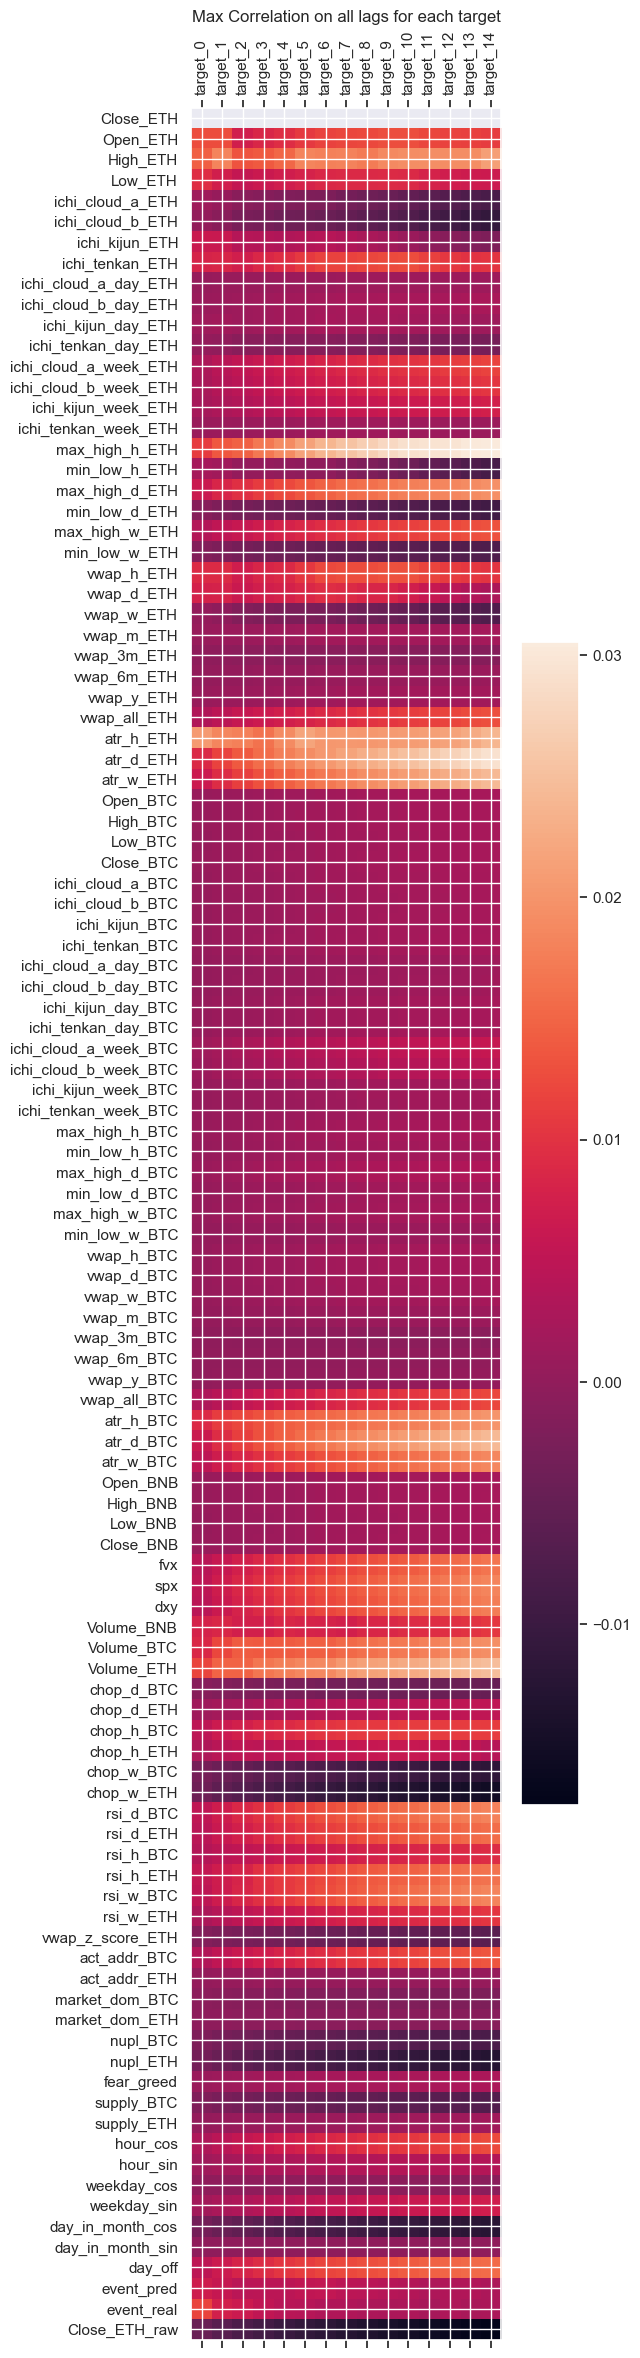

In [122]:
#corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(max_corr_matrix_targets, title = "Max Correlation on all lags for each target", size=5)

In [123]:
arr_corr_matrix_targets.shape

(72, 108, 15)

In [124]:

# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
corr_matrix_targets = pd.DataFrame(arr_corr_matrix_targets[-1,:,:], columns=list_col_targets, index=feature_names_to_correlate)
corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.009073  0.012706  0.005011  0.005306  0.003014  0.002964   
High_ETH          0.014071  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000296 -0.000423 -0.000544 -0.000668 -0.000773 -0.000863   
day_off           0.001504  0.001980  0.002029  0.002108  0.002348  0.002265   
event_pred       -0.001765 -0.002056 -0.004927 -0.006495 -0.006435 -0.004693   
event_real       -0.000192 -0.000444 -0.000892 -0.000309 -0.000999  0.001766   
Close_ETH_raw    -0.004584 -0.006471 -0.007914 -0.009142 -0.010221 -0.011200   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.005411  0.006158  0.005031  0.005796   0.007312   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000939 -0.001006 -0.001069 -0.001122  -0.001173   
day_off           0.002448  0.002551  0.002508  0.002349   0.002198   
event_pred       -0.005406 -0.006106 -0.004600 -0.004791  -0.004072   
event_real        0.002126  0.000963  0.001933  0.001213   0.000671   
Close_ETH_raw    -0.012098 -0.012931 -0.013712 -0.014452  -0.015153   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.006586   0.005397   0.005068   0.006258  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001227  -0.001266  -0.001291  -0.001319  
day_off            0.002044   0.001500   0.001213   0.000980  
event_pred        -0.003568  -0.003976  -0.004773  -0.002843  
event_real         0.000769   0.001015   0.000718   0.000742  
Close_ETH_raw     -0.015822  -0.016463  -0.017082  -0.017680  

[108 rows x 15 columns]

#### Best Max Corr Features

In [125]:
# (72, 103, 15)
ind = np.unravel_index(
    np.argsort(np.nan_to_num(arr_corr_matrix_targets, nan=0.0), axis=None), 
    arr_corr_matrix_targets.shape,
)
# 30th first features
nb_lag_corr_max = 50
# for lag_curr, feat_curr, target_curr in zip(ind[0][-nb_lag_corr_max:], ind[1][-nb_lag_corr_max:], ind[2][-nb_lag_corr_max:]): #ind[0][-30:]
    
#     corr_curr = arr_corr_matrix_targets[lag_curr, feat_curr, target_curr]
#     print(f"{feature_names_to_correlate[feat_curr]}, lag: {lag_curr}, target: {target_curr}, corr: {corr_curr}")

# 1. Get the slices of your indices
lags = ind[0][-nb_lag_corr_max:]
feature_indices = ind[1][-nb_lag_corr_max:]
target_indices = ind[2][-nb_lag_corr_max:]

# 2. Create the DataFrame from a dictionary of lists
corr_max_df_efficient = pd.DataFrame({
    'Feature': [feature_names_to_correlate[i] for i in feature_indices],
    'Lag': lags,
    'Target': target_indices,
    'Correlation': [arr_corr_matrix_targets[lag, feat, targ] for lag, feat, targ in zip(lags, feature_indices, target_indices)]
})

corr_max_df_efficient.sort_values(by='Correlation', ascending=False)


Feature  Lag  Target  Correlation
49  max_high_h_ETH   71      14     0.030522
48  max_high_h_ETH   71      13     0.030174
47  max_high_h_ETH   71      12     0.029767
46  max_high_h_ETH   71      11     0.029400
45  max_high_h_ETH   70      14     0.029298
44       atr_d_ETH   71      14     0.029270
43  max_high_h_ETH   70      13     0.029242
42  max_high_h_ETH   71      10     0.029076
41  max_high_h_ETH   70      11     0.028983
40  max_high_h_ETH   70      12     0.028974
39       atr_d_ETH   70      14     0.028877
38  max_high_h_ETH   70      10     0.028848
37       atr_d_ETH   69      14     0.028809
36       atr_d_ETH   68      14     0.028627
35       atr_d_ETH   67      14     0.028425
34       atr_d_ETH   71      13     0.028354
33  max_high_h_ETH   71       9     0.028178
32       atr_d_ETH   66      14     0.028178
31  max_high_h_ETH   69      10     0.028046
30       atr_d_ETH   70      13     0.028017
29  max_high_h_ETH   70       9     0.028008
28       atr_d_ETH   65      14     0.027985
27       atr_d_ETH   69      13     0.027905
26  max_high_h_ETH   69      11     0.027851
25       atr_d_ETH   64      14     0.027847
24       atr_d_ETH   68      13     0.027834
23  max_high_h_ETH   69      13     0.027758
22  max_high_h_ETH   69      12     0.027752
21       atr_d_ETH   63      14     0.027664
20       atr_d_ETH   67      13     0.027648
19  max_high_h_ETH   69      14     0.027621
18       atr_d_ETH   62      14     0.027490
17  max_high_h_ETH   69       9     0.027400
16       atr_d_ETH   66      13     0.027376
15       atr_d_ETH   71      12     0.027351
14       atr_d_ETH   61      14     0.027328
13       atr_d_ETH   65      13     0.027217
12       atr_d_ETH   60      14     0.027176
11       atr_d_ETH   64      13     0.027143
10       atr_d_ETH   70      12     0.027027
9   max_high_h_ETH   68      10     0.027013
8        atr_d_ETH   69      12     0.026983
7        atr_d_ETH   59      14     0.026956
6        atr_d_ETH   63      13     0.026919
5        atr_d_ETH   68      12     0.026868
4   max_high_h_ETH   70       8     0.026849
3        atr_d_ETH   67      12     0.026799
2        atr_d_ETH   47      14     0.026759
1        atr_d_ETH   46      14     0.026746
0   max_high_h_ETH   68      11     0.026744

max_high_h_ETH & Volume_ETH are the best positive impact on price.  
Explanation : 
- have a high higher in the last hour lead to have more chance to have a higher value in the next hour
- volume also  

Direction is kept 


#### Best Min Corr Features

In [126]:
# 1. Get the slices of your indices
lags = ind[0][0:nb_lag_corr_max]
feature_indices = ind[1][0:nb_lag_corr_max]
target_indices = ind[2][0:nb_lag_corr_max]

# 2. Create the DataFrame from a dictionary of lists
corr_min_df_efficient = pd.DataFrame({
    'Feature': [feature_names_to_correlate[i] for i in feature_indices],
    'Lag': lags,
    'Target': target_indices,
    'Correlation': [arr_corr_matrix_targets[lag, feat, targ] for lag, feat, targ in zip(lags, feature_indices, target_indices)]
})

corr_min_df_efficient.sort_values(by='Correlation', ascending=True)

Feature  Lag  Target  Correlation
0   min_low_h_ETH   71      14    -0.021244
1   min_low_h_ETH   71      13    -0.020220
2   min_low_h_ETH   71      12    -0.018750
3   Close_ETH_raw    3      14    -0.018262
4   Close_ETH_raw    2      14    -0.018259
5   Close_ETH_raw    4      14    -0.018252
6   Close_ETH_raw    1      14    -0.018243
7   Close_ETH_raw    5      14    -0.018236
8   Close_ETH_raw    0      14    -0.018228
9   Close_ETH_raw    6      14    -0.018221
10  Close_ETH_raw    7      14    -0.018218
11  Close_ETH_raw    8      14    -0.018209
12  Close_ETH_raw    9      14    -0.018192
13  Close_ETH_raw   10      14    -0.018182
14  Close_ETH_raw   11      14    -0.018169
15  Close_ETH_raw   12      14    -0.018147
16  Close_ETH_raw   13      14    -0.018131
17  Close_ETH_raw   14      14    -0.018124
18  Close_ETH_raw   15      14    -0.018117
19  Close_ETH_raw   16      14    -0.018103
20  Close_ETH_raw   21      14    -0.018085
21  Close_ETH_raw   20      14    -0.018081
22  Close_ETH_raw   19      14    -0.018079
23  Close_ETH_raw   17      14    -0.018078
24  Close_ETH_raw   18      14    -0.018077
25  Close_ETH_raw   22      14    -0.018069
26  Close_ETH_raw   23      14    -0.018063
27  Close_ETH_raw   24      14    -0.018063
28  Close_ETH_raw   25      14    -0.018049
29  Close_ETH_raw   26      14    -0.018040
30  Close_ETH_raw   27      14    -0.018031
31  Close_ETH_raw   28      14    -0.018014
32  Close_ETH_raw   29      14    -0.018000
33  Close_ETH_raw   30      14    -0.017974
34  min_low_h_ETH   70      14    -0.017965
35  Close_ETH_raw   31      14    -0.017955
36  Close_ETH_raw   32      14    -0.017949
37  Close_ETH_raw   33      14    -0.017933
38  Close_ETH_raw   34      14    -0.017925
39  Close_ETH_raw   35      14    -0.017909
40  Close_ETH_raw   37      14    -0.017894
41  Close_ETH_raw   40      14    -0.017894
42  Close_ETH_raw   36      14    -0.017894
43  Close_ETH_raw   39      14    -0.017890
44  Close_ETH_raw   41      14    -0.017889
45  Close_ETH_raw   38      14    -0.017889
46  Close_ETH_raw   42      14    -0.017888
47  Close_ETH_raw   43      14    -0.017883
48  Close_ETH_raw   46      14    -0.017879
49  Close_ETH_raw   45      14    -0.017877

In [127]:
np.nanmin(arr_corr_matrix_targets)

np.float64(-0.02124448282696438)

min_low_h_ETH & Close_ETH_raw are the best negative impact on price.  
Explanation : 
- have a min low higher in the last hour lead to have more chance to have a lower value in the next hour : direction kept
- have a price higher, so return to mean value


#### Last Lag Max Correlation

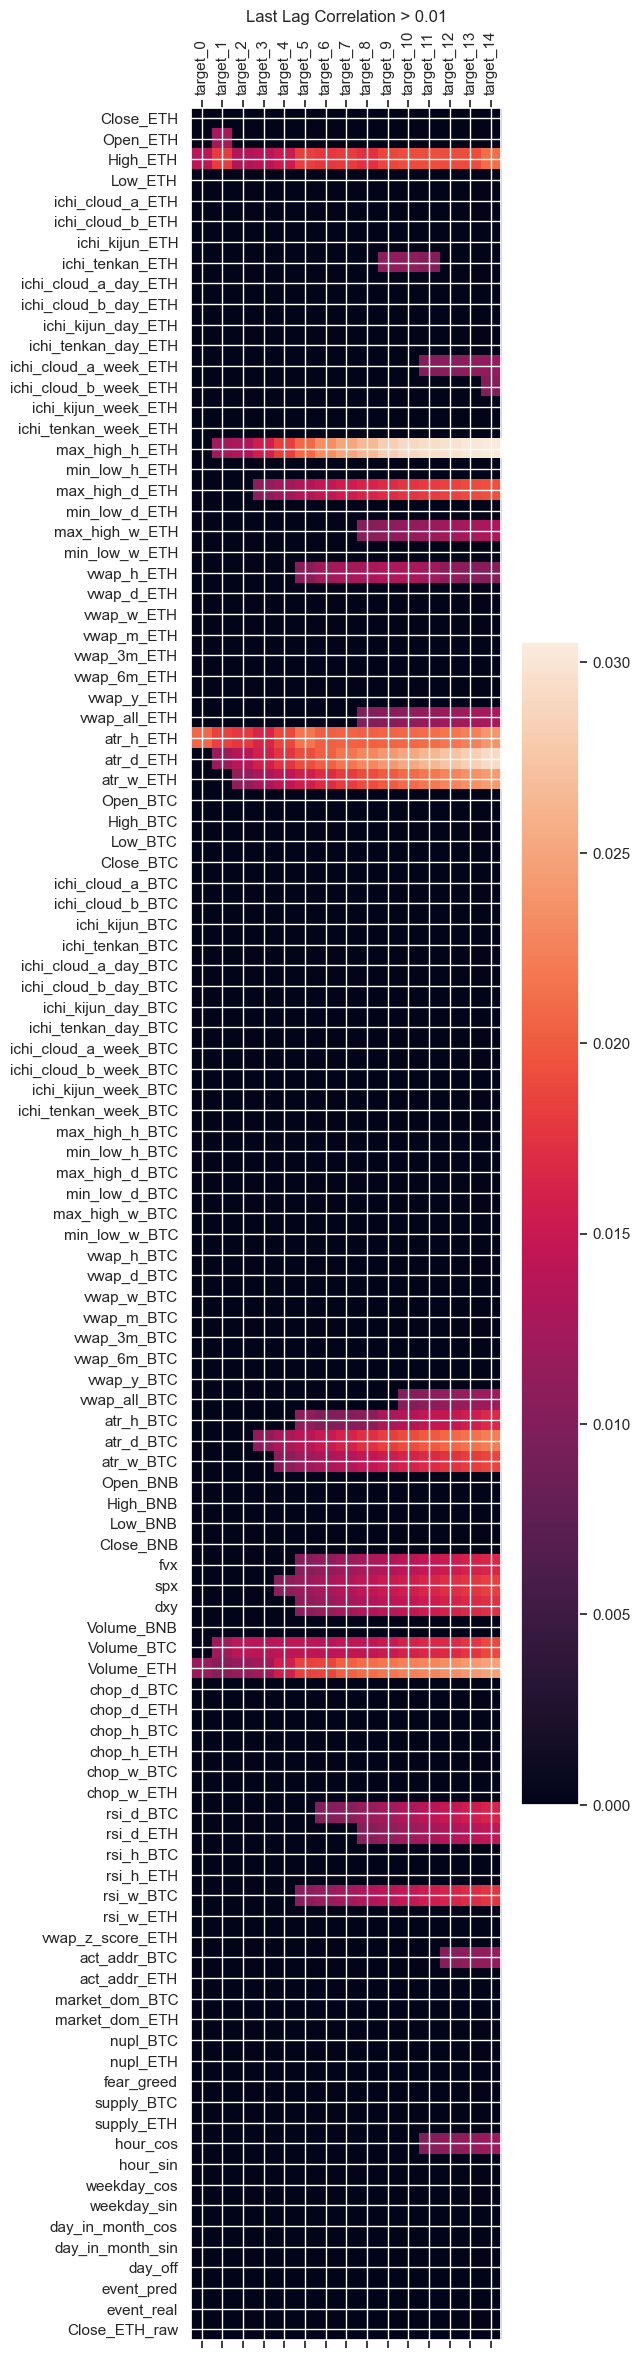

In [128]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets>0.01, 0), 
    title = "Last Lag Correlation > 0.01", 
    size=5)

#### Max Correlation on all lags

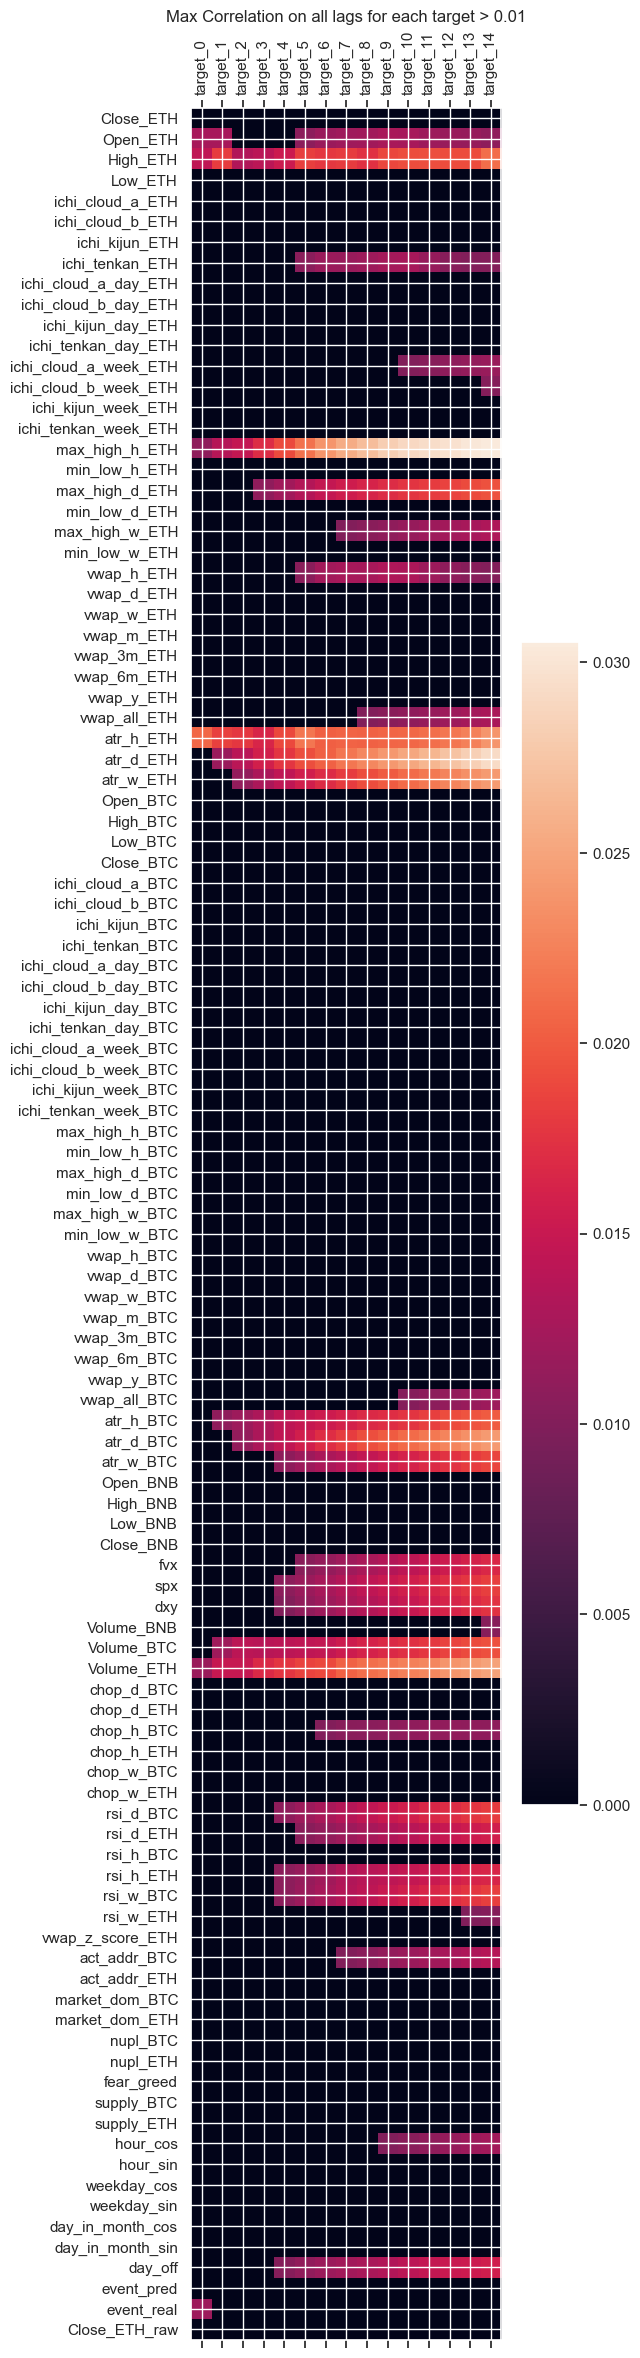

In [129]:
fig = plot_corr(
    max_corr_matrix_targets.where(max_corr_matrix_targets>0.01, 0),
    title="Max Correlation on all lags for each target > 0.01",
    size=5)

<Axes: >

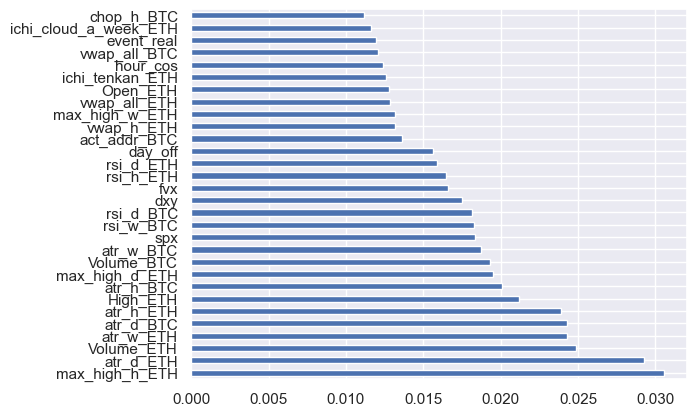

In [130]:
max_max_corr = max_corr_matrix_targets.max(axis=1).sort_values(ascending=False)
max_max_corr[max_max_corr.values>0.011].plot.barh()

#### Test on the highest corr


In [131]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [132]:
df["target_cat"] = "neutral"
df.loc[df["target_14"] >= 1 + 0.5/100, "target_cat"] = "up"
df.loc[df["target_14"] <= 1 - 0.5/100, "target_cat"] = "down"
df["target_cat"].value_counts()

target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

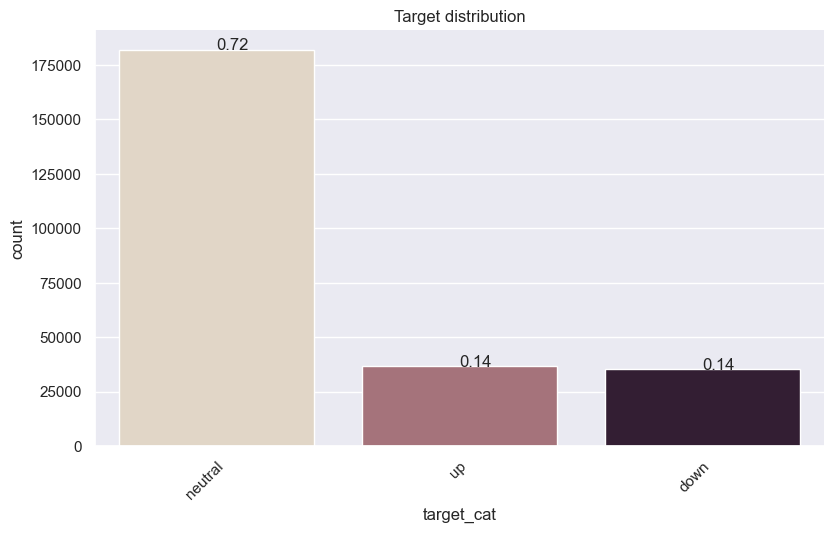

In [133]:
plot_hist_cat("target_cat", df, "Target distribution")

In [134]:
list_level=["neutral", "higher", "very-higher"]
df["max_high_h_ETH_cat"] = "very-higher"
df.loc[df["max_high_h_ETH"] <= 1.01, "max_high_h_ETH_cat"] = "higher"
df.loc[df["max_high_h_ETH"] <= 1.005, "max_high_h_ETH_cat"] = "neutral"

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


max_high_h_ETH_cat
neutral        179399
higher          50855
very-higher     23423
Name: count, dtype: int64

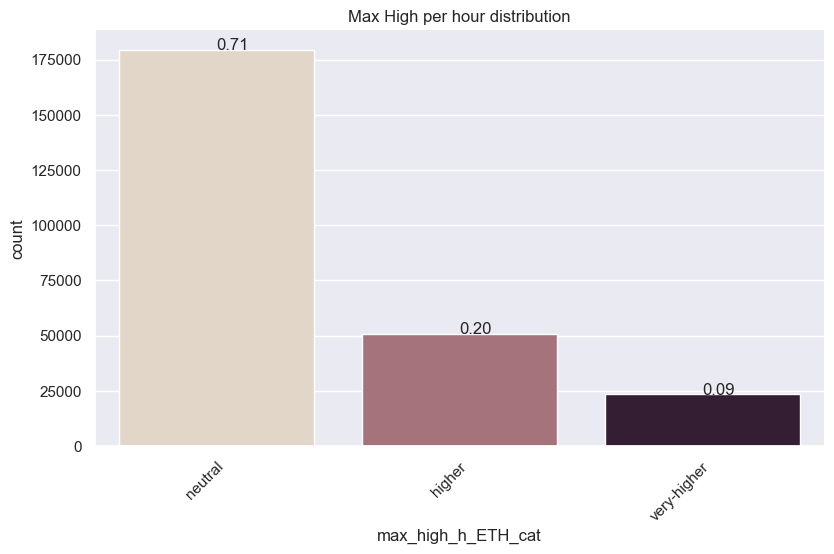

In [135]:
plot_hist_cat("max_high_h_ETH_cat", df, "Max High per hour distribution")

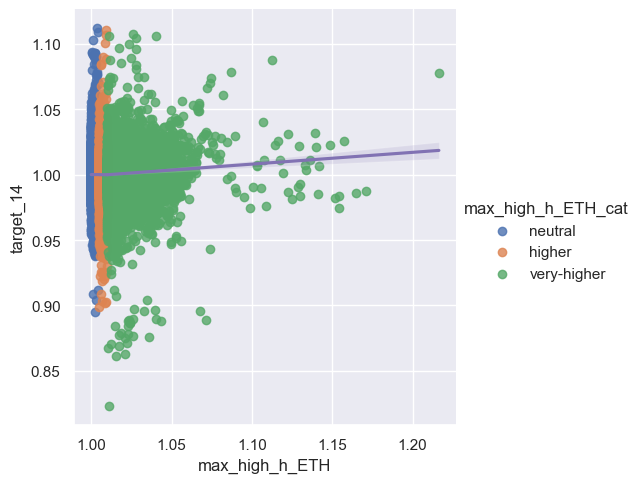

In [136]:
sns.lmplot(x="max_high_h_ETH", y="target_14",
            hue="max_high_h_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

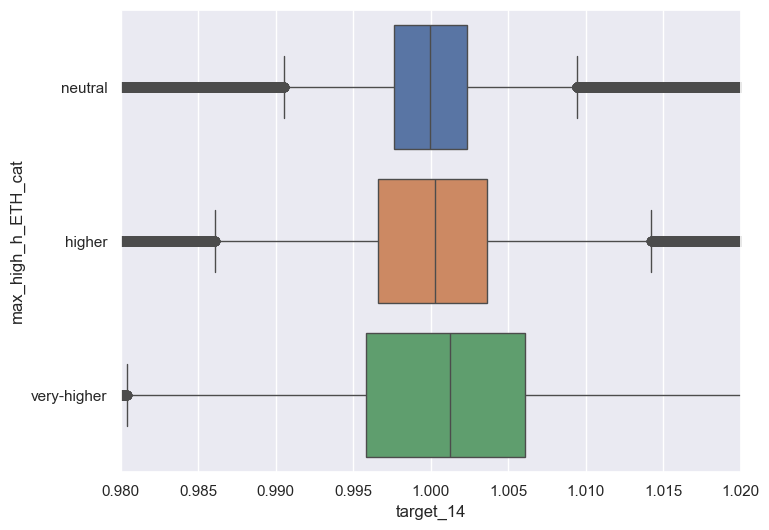

In [137]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="max_high_h_ETH_cat", 
    hue="max_high_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


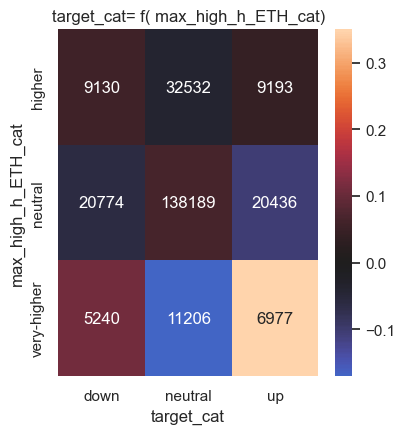

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [138]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


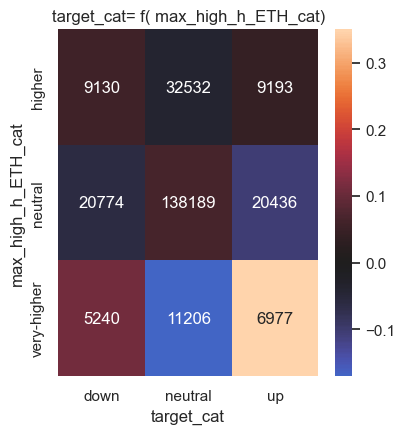

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [139]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

In [140]:
df["nupl_ETH"].describe()

count    253677.000000
mean          0.118971
std           0.198094
min          -0.775319
25%           0.039797
50%           0.106898
75%           0.260524
max           0.513805
Name: nupl_ETH, dtype: float64

In [141]:

mquantiles(df["nupl_ETH"], prob=[0.10, 0.90])

array([-0.08284051,  0.36014272])

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


nupl_ETH_cat
neutral    168456
higher      69777
lower       15444
Name: count, dtype: int64

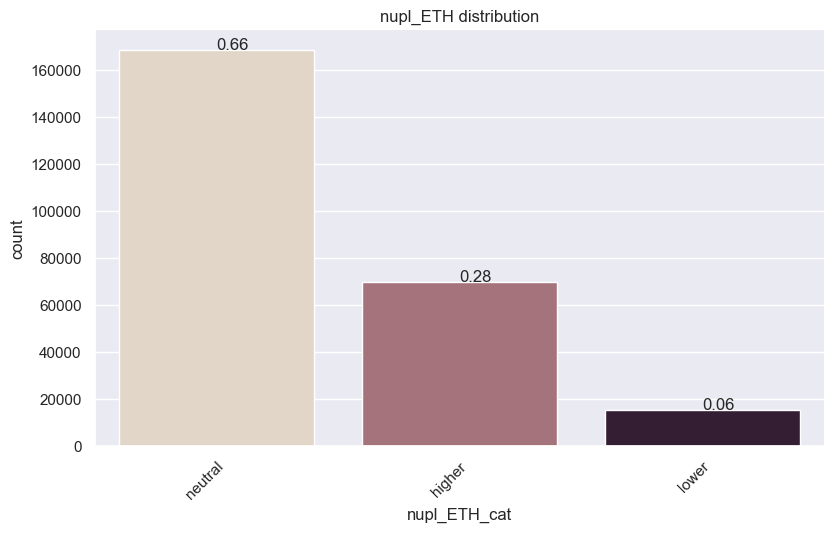

In [142]:

list_level=["lower", "neutral", "higher"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] >= 0.25, "nupl_ETH_cat"] = "higher"
df.loc[df["nupl_ETH"] <= -0.25, "nupl_ETH_cat"] = "lower"
plot_hist_cat("nupl_ETH_cat", df, "nupl_ETH distribution")

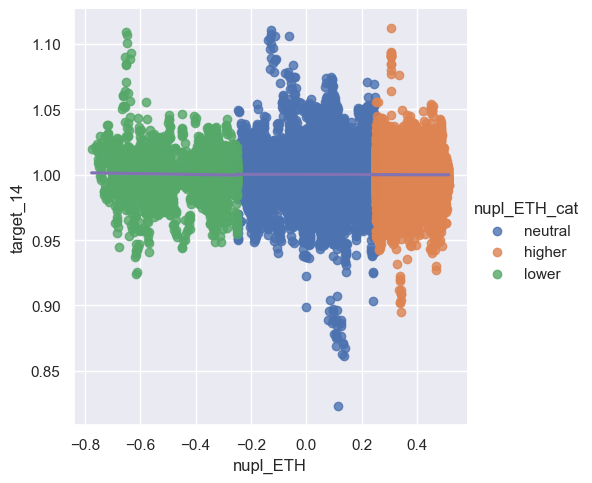

In [143]:
sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

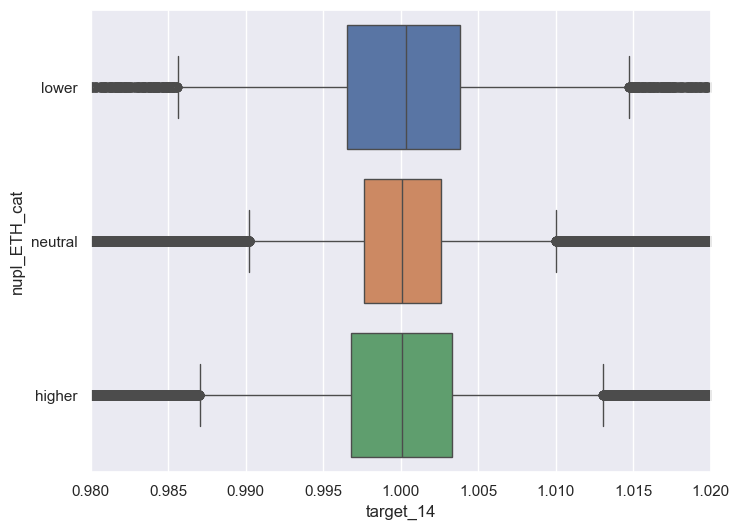

In [144]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  9666.79236982  50041.27405717  10068.93357301]
 [  2139.58670278  11075.81920316   2228.59409406]
 [ 23337.6209274  120809.90673967  24308.47233293]]
target_cat       down   neutral       up     Total
nupl_ETH_cat                                      
higher        11586.0   46564.0  11627.0   69777.0
lower          2817.0    9702.0   2925.0   15444.0
neutral       20741.0  125661.0  22054.0  168456.0
total         35144.0  181927.0  36606.0  253677.0
xi_n =  2159.047419759374
chi2:  2159.047419759374
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


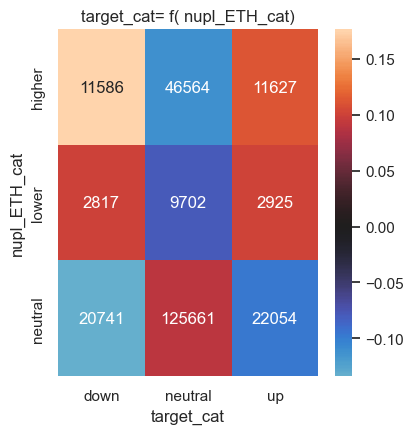

target_cat     down  neutral     up
nupl_ETH_cat                       
higher        11586    46564  11627
lower          2817     9702   2925
neutral       20741   125661  22054

In [145]:
plot_cont(X="nupl_ETH_cat", Y="target_cat", data=df)

In [146]:
chi2 = 2159
indep = 35144.0/253677.0*69777.0
c = 11586
print("chi2: ", chi2)
print("indep: ", indep)
print("c: ", c)
print("chi2 abs part : ", (c-indep)**2/indep)
print("chi2 sign part : ", (c-indep) / np.fabs(c-indep))
print("% of chi2 : ", 100*(c-indep)**2/indep / chi2)


chi2:  2159
indep:  9666.79236982462
c:  11586
chi2 abs part :  381.03207215054994
chi2 sign part :  1.0
% of chi2 :  17.64854433305002


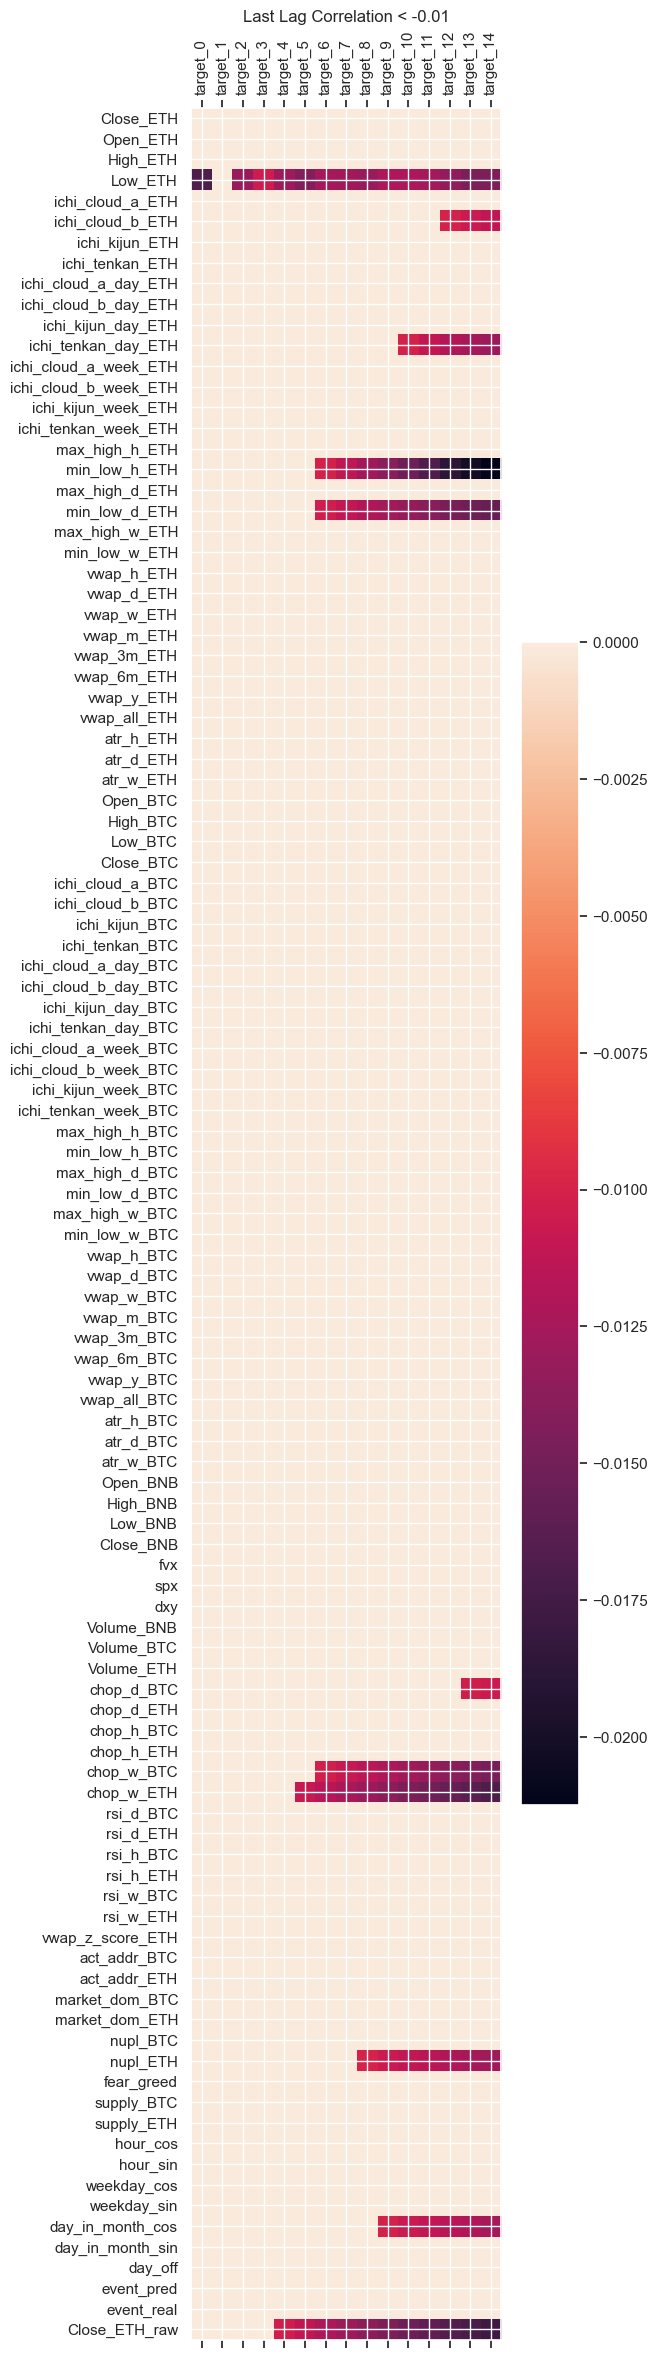

In [147]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.01, 0), 
          title="Last Lag Correlation < -0.01", 
          size=5)

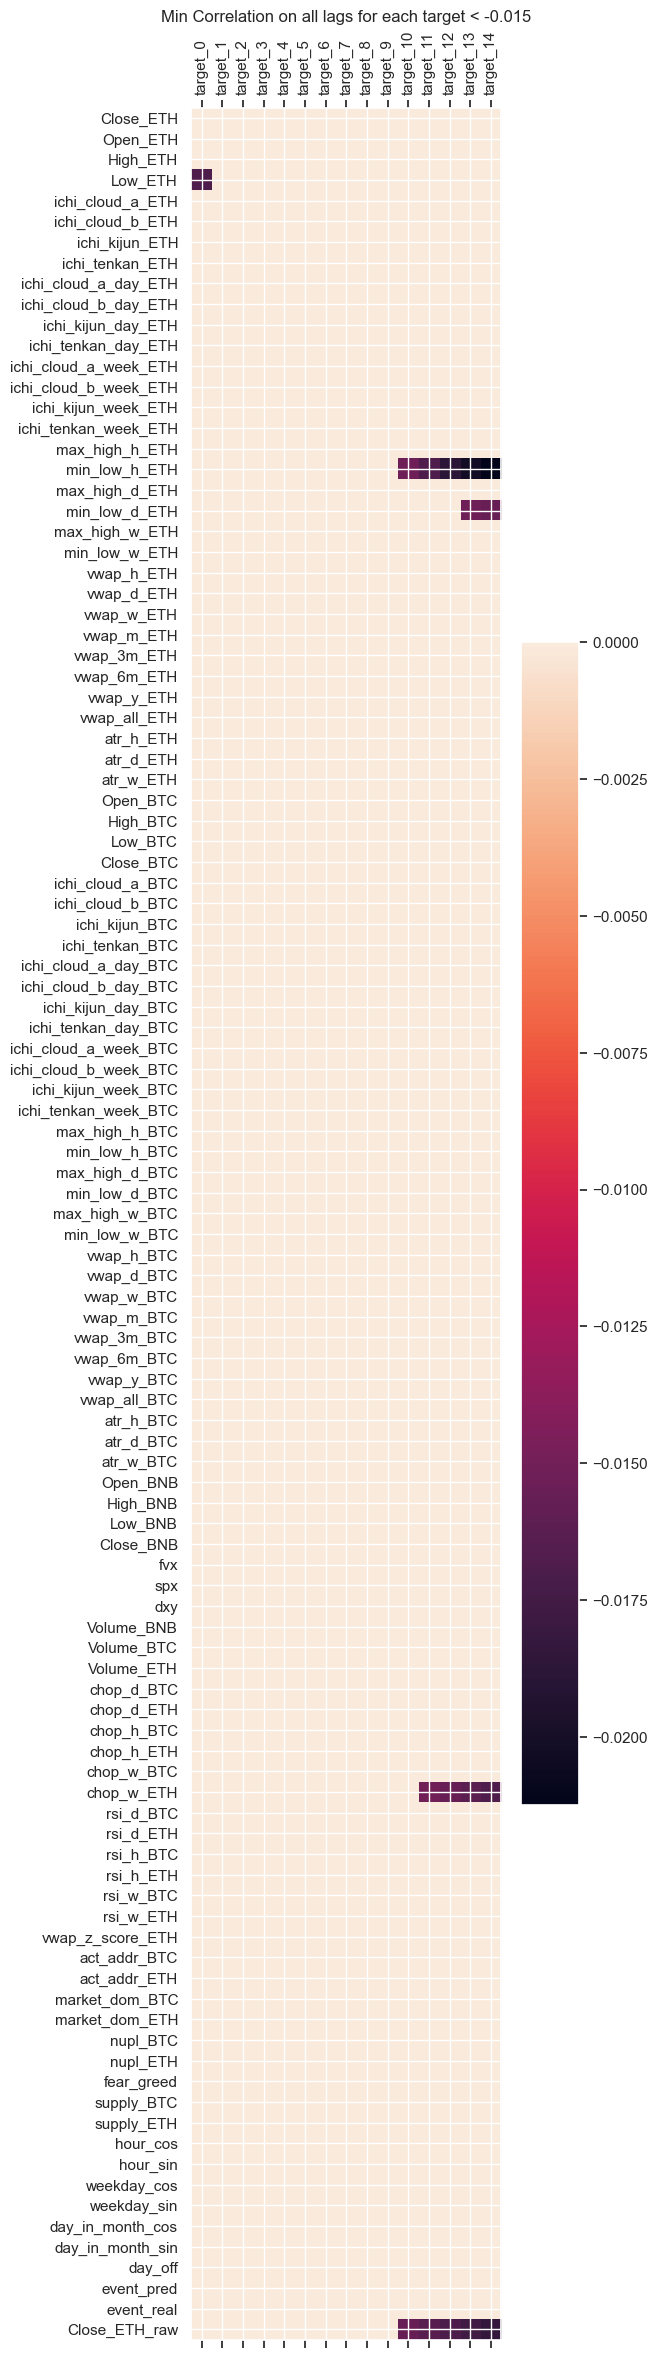

In [148]:
fig = plot_corr(min_corr_matrix_targets.where(min_corr_matrix_targets < -0.015, 0),
                title="Min Correlation on all lags for each target < -0.015",
                size=5)

Text(0, 0.5, 'Min Correlation on all lags for each target < -0.015')

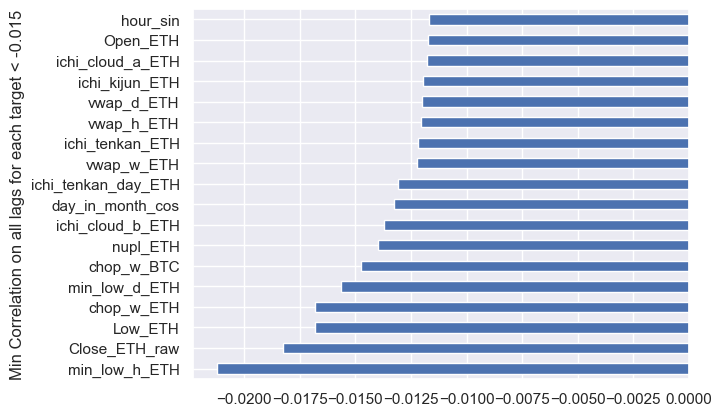

In [149]:
min_min_corr = min_corr_matrix_targets.min(axis=1).sort_values(ascending=True)
min_min_corr[min_min_corr.values<-0.011].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_ylabel("Min Correlation on all lags for each target < -0.015")

<Axes: >

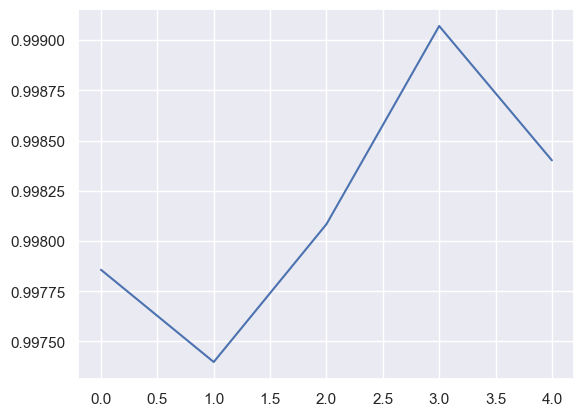

In [150]:
df["min_low_h_ETH"].head().plot()

In [151]:
df["min_low_h_ETH"].describe()

count    253677.000000
mean          0.995225
std           0.005330
min           0.847357
25%           0.993900
50%           0.996677
75%           0.998391
max           1.000000
Name: min_low_h_ETH, dtype: float64

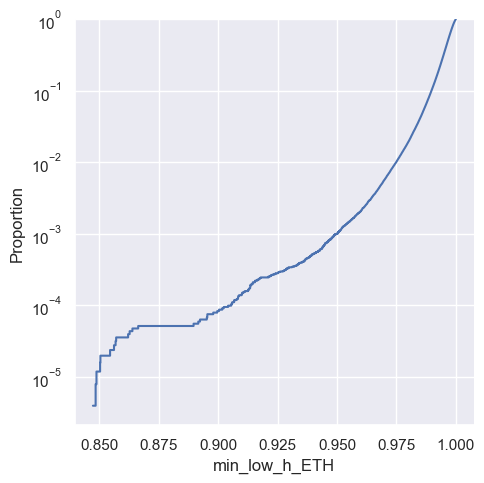

In [152]:
sns.displot(df, x="min_low_h_ETH", kind="ecdf", log_scale=(False, True))

In [153]:
list_level=["very_low", "low", "neutral"]
df["min_low_h_ETH_cat"] = "low"
df.loc[df["min_low_h_ETH"] < 0.995, "min_low_h_ETH_cat"] = "very_low"
df.loc[df["min_low_h_ETH"] > 0.998, "min_low_h_ETH_cat"] = "neutral"
df["min_low_h_ETH_cat"].value_counts()

min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

Text(0.5, 1.0, 'Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)')

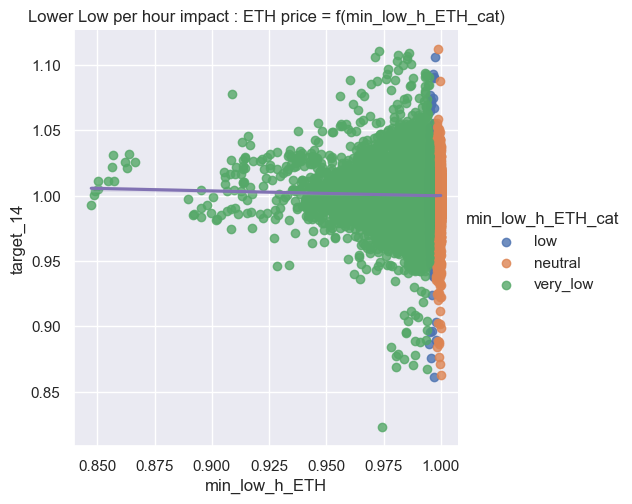

In [154]:
sns.lmplot(x="min_low_h_ETH", y="target_14", hue="min_low_h_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)")

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

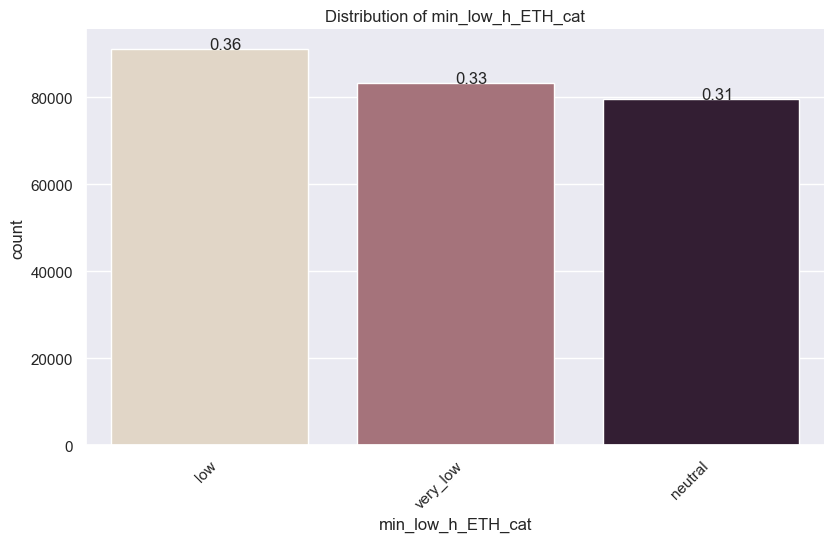

In [155]:

plot_hist_cat(x="min_low_h_ETH_cat", data=df, title="Distribution of min_low_h_ETH_cat")

expected:  [[12608.93189371 65271.60120153 13133.46690476]
 [11010.89170875 56999.16047967 11468.94781159]
 [11524.17639754 59656.23831881 12003.58528365]]
target_cat            down   neutral       up     Total
min_low_h_ETH_cat                                      
low                11509.0   67574.0  11931.0   91014.0
neutral             7582.0   63940.0   7957.0   79479.0
very_low           16053.0   50413.0  16718.0   83184.0
total              35144.0  181927.0  36606.0  253677.0
xi_n =  8339.15806994498
chi2:  8339.15806994498
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


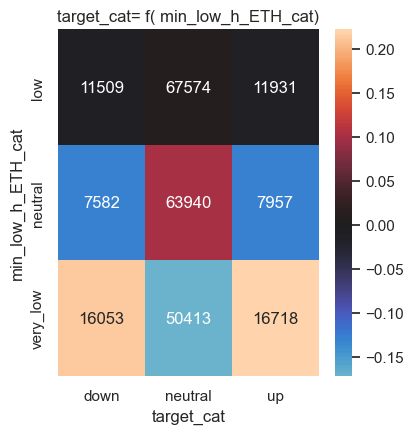

target_cat          down  neutral     up
min_low_h_ETH_cat                       
low                11509    67574  11931
neutral             7582    63940   7957
very_low           16053    50413  16718

In [156]:
plot_cont(X="min_low_h_ETH_cat", Y="target_cat", data=df)

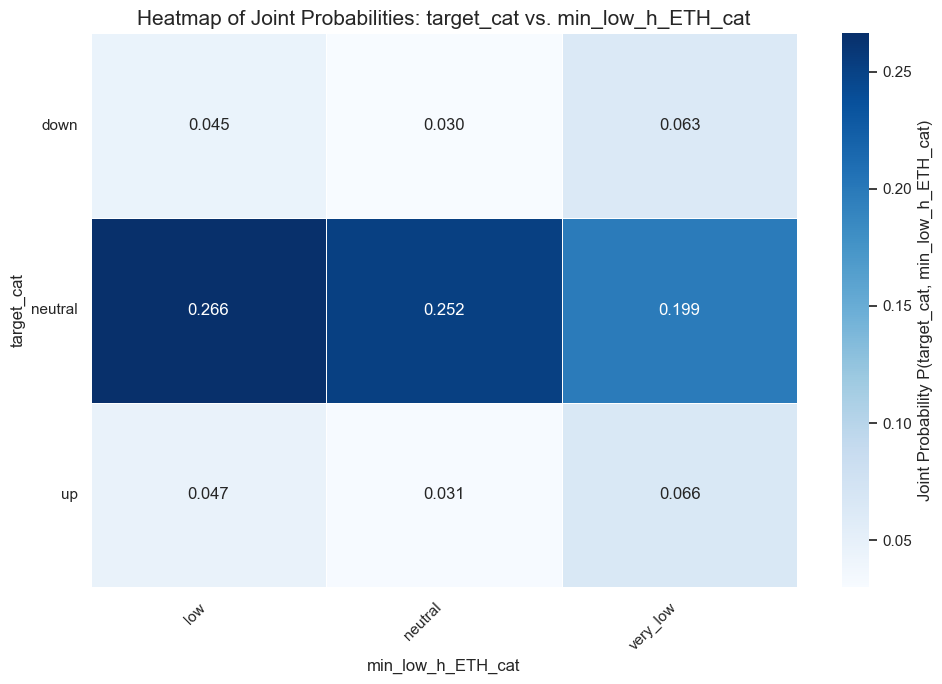

Joint Probability Table:
min_low_h_ETH_cat       low   neutral  very_low
target_cat                                     
down               0.045369  0.029888  0.063281
neutral            0.266378  0.252053  0.198729
up                 0.047032  0.031367  0.065903


In [157]:
probability_table = pd.crosstab(df['target_cat'], df['min_low_h_ETH_cat'], normalize=True)
# 2. Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    probability_table,
    annot=True,        # Show the probability values on the heatmap cells
    fmt=".3f",         # Format annotations to 3 decimal places
    cmap="Blues",      # Colormap (e.g., "Blues", "YlGnBu", "viridis")
    linewidths=.5,     # Add lines between cells for better separation
    cbar_kws={'label': 'Joint Probability P(target_cat, min_low_h_ETH_cat)'} # Label for the color bar
)

plt.title('Heatmap of Joint Probabilities: target_cat vs. min_low_h_ETH_cat', fontsize=15)
plt.ylabel('target_cat', fontsize=12)
plt.xlabel('min_low_h_ETH_cat', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if long
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Display the probability table (optional)
print("Joint Probability Table:")
print(probability_table)

In [158]:
probability_table.sum().sum()

np.float64(1.0)

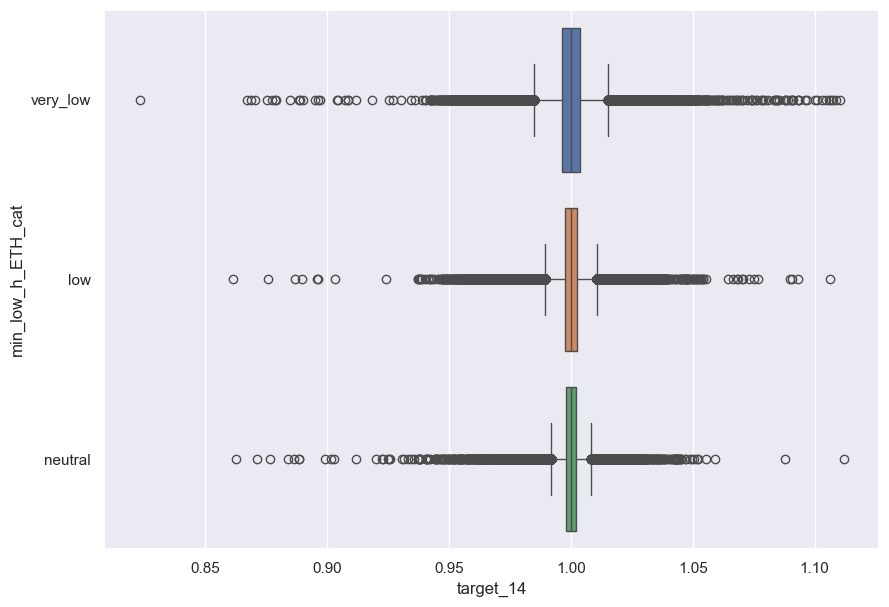

In [159]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="min_low_h_ETH_cat", 
    hue="min_low_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
#ax.set_xlim([0.98,1.02])

In [160]:
df["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [161]:
df["target_1"].describe()

count    253677.000000
mean          1.000009
std           0.002652
min           0.907143
25%           0.998967
50%           1.000013
75%           1.001066
max           1.081058
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

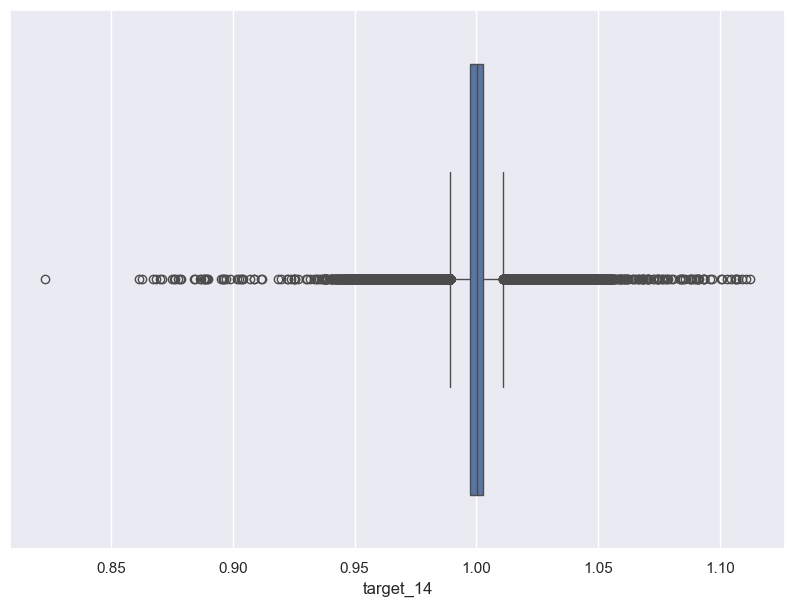

In [162]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

(0.98, 1.02)

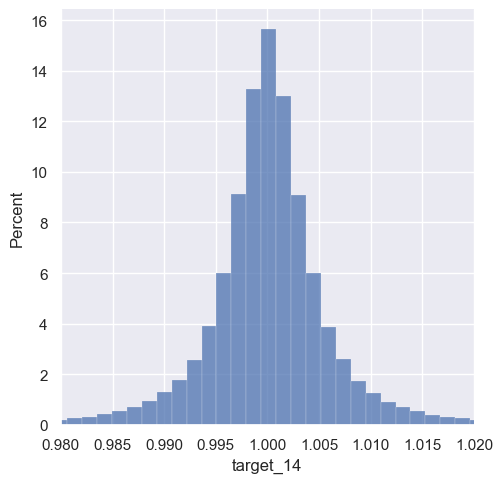

In [163]:
sns.displot(df, x="target_14", kind="hist", stat="percent", bins=200)
ax = plt.gca()
ax.set_xlim([0.98,1.02])

### Chi-2
Distrib are independent between inputs and target (target_14) ?  
Chi-2 must be low  
if not then we can use them as features  
To classify Targets we can say that : if we have : 
- a capital 10000$  
- leverage x10 maxi
- SL = -50$ / TP = 100$ / R = 2
- and we want to have 100$ of profit per days
- so:  0.1% up or down can be enough for target

Or find a threshold that can occurs on FUTURE_TARGET points  at a minimum prob to have > 80% chance to touch min or max target  
For example : 
- 40% touch max Target
- 40% touch min Target
- 20% neutral
- Total : 80%


In [164]:
4500*0.1/100

4.5

In [165]:
10000*10*0.1/100

100.0

In [166]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [167]:
last_target = list_col_targets[-1]

In [168]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [169]:
# find for all features the quantiles 0.10 and 0.90
# transpose the dataframe to have the features as columns
df_cont = df.filter(list_col_select + [last_target]).quantile([0.10, 0.90], axis=0)
df_cont = df_cont.T
# rename the columns
df_cont.columns = ["q10", "q90"]
# store nunique() in a new column
df_cont["nunique"] = df.filter(list_col_select + [last_target]).nunique()

df_cont

q10          q90  nunique
Close_ETH            1.000000     1.000000        1
Open_ETH             0.998280     1.001714    76413
High_ETH             1.000016     1.002502    37382
Low_ETH              0.997419     0.999966    60295
ichi_cloud_a_ETH     0.990221     1.009114   171844
...                       ...          ...      ...
day_off              0.000000     0.000000        2
event_pred           0.000000     0.000000        3
event_real           0.000000     0.000000        3
Close_ETH_raw     1625.745996  3489.247998   135314
target_14            0.993554     1.006591   253286

[109 rows x 3 columns]

#### Target levels
Here we can see the 10% lowest is under -0.64%, the 10% highest are over 0.65% : 

In [170]:
print(f"target level min : {100*(df_cont.at["target_14","q10"]-1)} %")

target level min : -0.6445897063064643 %


In [171]:
print(f"target level max : {100*(df_cont.at["target_14","q90"]-1)} %")

target level max : 0.6591337726385094 %


In [172]:
(1.006591 -1)/1 *100

0.6591000000000014

In [173]:
(0.993554 - 1) / 1 * 100

-0.6445999999999952

We can use a level of >= 0.1% => "high" , <=-0.1% "low", otherwise "neutral"  

- BE CAREFUL : Hyperliquid for example can take 25% of trade if 0.1% is a trigger : 
  - maker fee : 0.015%
  - funding 24h = 0.03*3 = 0.01%  
  - TOTAL :  0.025% => 25% of 0.1%

In [174]:
target_level = 0.1/100

In [175]:
y_train.shape

(253677, 15)

In [176]:
y_train.max(axis=1) >= 1+target_level

array([False, False, False, ...,  True,  True,  True], shape=(253677,))

In [177]:
y_train.min(axis=1) <= 1-target_level

array([False,  True,  True, ...,  True,  True, False], shape=(253677,))

Not used anymore :  the last target value : 

In [178]:
Y = "target_last_cat"
df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
df_targets.loc[y_train[:,-1] >= 1+target_level, Y] = "high"
df_targets.loc[y_train[:,-1] <= 1-target_level, Y] = "low"
df_targets[Y].value_counts()

target_last_cat
high       102187
low         97441
neutral     54049
Name: count, dtype: int64

In [179]:
df_targets["target_last_cat"].value_counts()/df_targets.shape[0]

target_last_cat
high       0.402823
low        0.384114
neutral    0.213062
Name: count, dtype: float64

In [180]:
df_targets["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [181]:
df_targets["max_target"] = y_train.max(axis=1)
df_targets["min_target"] = y_train.min(axis=1)
df_targets

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14 target_last_cat  max_target  min_target  
0        1.000151   0.999858         neutral    1.000460    0.999498  
1        0.999398   0.998803             low    0.999925    0.998803  
2        0.998879   0.998594             low    0.999908    0.998594  
3        0.999355   1.000427         neutral    1.000670    0.999355  
4        0.999757   0.999732         neutral    0.999933    0.998686  
...           ...        ...             ...         ...         ...  
253672   0.994823   0.993744             low    1.001448    0.983481  
253673   0.992307   0.988445             low    0.996225    0.982059  
253674   0.993288   0.996043             low    1.001107    0.986871  
253675   0.997206   0.995803             low    1.002276    0.988024  
253676   1.007874   1.007934            high    1.014425    1.003062  

[253677 rows x 18 columns]

Very important : we can see that the last target is not the best to use as a target,   
because it is not well distributed,   
so we will use the max and min, of all the targets, to create a new target   
But we take the first to appear above min/max threshold : +/-0.1%  
Example : 
- if the max is above 1.001 before min is below 0.999, then we will use the max as the target
- if the min is below 0.999 before max is above 1.001, then we will use the min as the target
- if none of them are above/below 1.001/0.999, then we will use the neutral target
  
##### First Strategy :  TP = SL

In [182]:
Y = "target_cat"
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : 
b_low = ((y_train.min(axis=1) <= 1-target_level) & (
    (y_train.argmin(axis=1) < y_train.argmax(axis=1)) |
    ((y_train.argmin(axis=1) > y_train.argmax(axis=1)) & (y_train.max(axis=1) < 1+target_level))
    )
)
df_targets.loc[b_low, Y] = "low"
# high cat
b_high = ((y_train.max(axis=1) >= 1+target_level)& (
    (y_train.argmax(axis=1) < y_train.argmin(axis=1)) |
    ((y_train.argmax(axis=1) > y_train.argmin(axis=1)) & (y_train.min(axis=1) > 1-target_level))
    )
)
df_targets.loc[b_high, Y] = "high"

df_targets[Y].value_counts()

target_cat
high       125295
low        123574
neutral      4808
Name: count, dtype: int64

In [183]:
df_targets[Y].value_counts()/df_targets.shape[0]

target_cat
high       0.493915
low        0.487131
neutral    0.018953
Name: count, dtype: float64

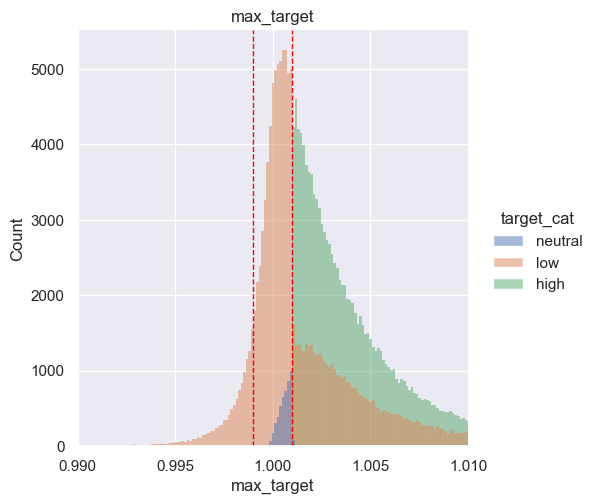

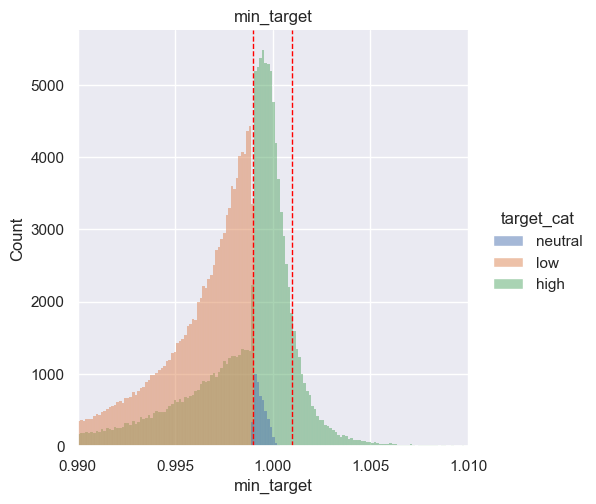

In [184]:
sns.displot(df_targets, x="max_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("max_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

sns.displot(df_targets, x="min_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("min_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

Here : complex graph : 
- If Neutral cat., min or max stay into thresholds.  
- if High cat., min value is around 1
- If Low cat., max value is 1.0005 (1-0.05%) (half the threshold 0.1%)


##### 2eme Strat : TP/SL = 2


In [185]:
1-target_level

0.999

In [186]:
1-target_level/2

0.9995

In [187]:
1+target_level

1.001

In [188]:
1+target_level/2

1.0005

In [189]:
# nb low SHORT TP and high SHORT SL is never reached during timerange
np.sum((y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) < 1+target_level/2))

np.int64(54336)

In [190]:
# nb low SHORT TP and high SHORT SL is reached during timerange but after TP is reached
np.sum(
    (y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) >= 1+target_level/2)
    & (np.argmax((y_train <= 1-target_level), axis=1) <= np.argmax(y_train >= 1+target_level/2, axis=1))
)

np.int64(51137)

In [191]:
54336 + 51137

105473

In [192]:
# nb high LONG TP and low LONG SL is never reached during timerange
np.sum((y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) > 1-target_level/2))

np.int64(56897)

In [193]:
# nb high LONG TP and low LONG SL is reached during timerange but after TP is reached 
np.sum(
    (y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) <= 1-target_level/2) &
    (np.argmax((y_train >= 1+target_level), axis=1) <= np.argmax(y_train <= 1-target_level/2, axis=1))
)

np.int64(50774)

In [194]:
56897 + 50774

107671

In [195]:
Y = "target_cat"
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT  reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low =(
    ((y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) < 1+target_level/2)) |
    (
        (y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) >= 1+target_level/2) &
        (np.argmax((y_train <= 1-target_level), axis=1) <= np.argmax(y_train >= 1+target_level/2, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) > 1-target_level/2)) |
    (
        (y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) <= 1-target_level/2) &
        (np.argmax((y_train >= 1+target_level), axis=1) <= np.argmax(y_train <= 1-target_level/2, axis=1))
    )
)

df_targets.loc[b_high, Y] = "high"

df_targets[Y].value_counts()

target_cat
high       107671
low        105473
neutral     40533
Name: count, dtype: int64

Max trade per day

In [196]:
24*60/5

288.0

In [197]:
Y

'target_cat'

In [198]:
PAST_HISTORY

72

In [199]:
(2**6)*5/60

5.333333333333333

Caclulate for lags exponentially distributed  : e.g. : 
- 1st lag = 5min
- 2nd lag = 10min
- 3rd lag = 20min
- 4th lag = 40min
- 5th lag = 80min
- 6th lag = 160min

In [200]:

# find a maximum range as long as sum on i (from 1 to n) of DT_PAST*2**(i-1) is inferior to PAST_HISTORY 
k=0
list_past = []
for i in range(0, PAST_HISTORY):
    if 2**(i) - 1 > PAST_HISTORY:
        break
    else:
        k = PAST_HISTORY - 2**(i) 
        list_past.append(k)

print(list_past)

[71, 70, 68, 64, 56, 40, 8]


In [201]:
def calc_prob(val):
    # calculate proba for classes of a value counts as input : val
    # calculate also the delta "power" proba between high and low : (nb_H - nb_L)^2 / mean(nb_h,nb_L)
    # to indicate important feature
    prob_high = val["high"] / (val.sum())
    prob_low = val["low"] / (val.sum())
    prob_delta = np.sign(prob_high - prob_low) * (val["high"] - val["low"] )**2 / ((val["high"] + val["low"]) / 2)
    return val["high"], val["low"], prob_high, prob_low, prob_delta


In [202]:
# df_prob = pd.DataFrame()

# for cat_feature in ["high", "low"]:
#     ser_prob_curr = pd.Series()
#     val = df_.loc[df_[X] == cat_feature, "target_cat"].value_counts()
#     if len(val) > 0 :
#         prob_high, prob_low, delta_prob = calc_prob(val)
#     else:
#         prob_high = np.nan
#         prob_low = np.nan
#         delta_prob = np.nan
#     ser_prob_curr["feature"] = X
#     ser_prob_curr["feature_cat"] = cat_feature
#     ser_prob_curr["lag"] = I_past
#     ser_prob_curr["prob_high"] = prob_high
#     ser_prob_curr["prob_low"] = prob_low
#     ser_prob_curr["delta_prob"] = delta_prob
#     #df_prob = pd.concat([df_prob, df_prob_curr], axis=0)
#     if df_prob.shape[0] == 0:
#         df_prob = ser_prob_curr.to_frame().T
#     else:
#         df_prob = pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
# df_prob

In [203]:
# Calculate classes, contigency chi2 and p value : for each feature and each past value
# - for all lags of target,  we have one categorical variable :
# - high mean we have touch high target level, 
# - low mean we have touch low target level,
# - neutral mean we have not touch target level
list_df = []
df_prob = pd.DataFrame()
for I_past in list_past: #range(PAST_HISTORY):
    # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
    df_ = pd.DataFrame(X_train_dat[:, I_past, :nb_plot], columns=list_col_select[:nb_plot])
    df_ = pd.concat([df_, df_targets], axis=1)
    for col_name in list_col_select:
        X = col_name + "_cat"
        df_[X] = "neutral"
        if df_cont.at[col_name, "nunique"] > 3:
            df_.loc[df_[col_name] >= df_cont.at[col_name, "q90"], X] = "high"
            df_.loc[df_[col_name] <= df_cont.at[col_name, "q10"], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 3:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[2], X] = "high"
            df_.loc[df_[col_name] == unique_values[1], X] = "neutral"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 2:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[1], X] = "high"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        

        # create prob df : 
        for cat_feature in ["high", "low"]:
            ser_prob_curr = pd.Series()
            val = df_.loc[df_[X] == cat_feature, "target_cat"].value_counts()
            if len(val) > 0 :
                val_high, val_low, prob_high, prob_low, delta_prob = calc_prob(val)
            else:
                val_high = np.nan
                val_low = np.nan
                prob_high = np.nan
                prob_low = np.nan
                delta_prob = np.nan
            ser_prob_curr["feature"] = X
            ser_prob_curr["feature_cat"] = cat_feature
            ser_prob_curr["lag"] = I_past
            ser_prob_curr["nb_high"] = val_high
            ser_prob_curr["nb_low"] = val_low
            ser_prob_curr["prob_high"] = prob_high
            ser_prob_curr["prob_low"] = prob_low
            ser_prob_curr["delta_prob"] = delta_prob
            #df_prob = pd.concat([df_prob, df_prob_curr], axis=0)
            if df_prob.shape[0] == 0:
                df_prob = ser_prob_curr.to_frame().T
            else:
                df_prob = pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
    list_df.append(df_)

    df_cont[f"chi2_{I_past}"] = np.nan
    df_cont[f"p-value_{I_past}"] = np.nan
    # calculate contingency table for each feature
    arr_chi2 = np.full(len(list_col_select), np.nan)
    arr_p = np.full(len(list_col_select), np.nan)
    arr_prob_high_high = np.full(len(list_col_select), np.nan)
    arr_prob_high_low = np.full(len(list_col_select), np.nan)
    arr_delta_prob_high = np.full(len(list_col_select), np.nan)
    arr_prob_low_high = np.full(len(list_col_select), np.nan)
    arr_prob_low_low = np.full(len(list_col_select), np.nan)
    arr_delta_prob_low = np.full(len(list_col_select), np.nan)
    for I, col_name in enumerate(list_col_select):
        X = col_name + "_cat"
        # calculate contingency table : find link between feature cat and target cat
        c, chi2, p, dof, expected = contingency_table(X, "target_cat", df_)
        arr_chi2[I] = chi2
        arr_p[I] = p
        # calculate delta prob of high target and low target for each feature cat
        # when feat is high : 
        val = df_.loc[df_[X] == "high", "target_cat"].value_counts()
        if len(val) > 0 :
            _, _, prob_high_high, prob_high_low, delta_prob_high = calc_prob(val)
        else:
            prob_high_high = np.nan
            prob_high_low = np.nan
            delta_prob_high = np.nan
        arr_prob_high_high[I] = prob_high_high
        arr_prob_high_low[I] = prob_high_low
        arr_delta_prob_high[I] = delta_prob_high
        # and when feat is low :
        val = df_.loc[df_[X] == "low", "target_cat"].value_counts()
        if len(val) > 0 :
            _, _, prob_low_high, prob_low_low, delta_prob_low = calc_prob(val)
        else:
            prob_low_high = np.nan
            prob_low_low = np.nan
            delta_prob_low = np.nan
        arr_prob_low_high[I] = prob_low_high
        arr_prob_low_low[I] = prob_low_low
        arr_delta_prob_low[I] = delta_prob_low

        
    df_cont.loc[list_col_select, f"prob_high_high_{I_past}"] = arr_prob_high_high
    df_cont.loc[list_col_select, f"prob_high_low_{I_past}"] = arr_prob_high_low
    df_cont.loc[list_col_select, f"delta_prob_high_{I_past}"] = arr_delta_prob_high
    df_cont.loc[list_col_select, f"prob_low_high_{I_past}"] = arr_prob_low_high
    df_cont.loc[list_col_select, f"prob_low_low_{I_past}"] = arr_prob_low_low
    df_cont.loc[list_col_select, f"delta_prob_low_{I_past}"] = arr_delta_prob_low  


    df_cont.loc[list_col_select, f"chi2_{I_past}"] = arr_chi2
    df_cont.loc[list_col_select, f"p-value_{I_past}"] = arr_p


df_cont

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

q10          q90  nunique      chi2_71  \
Close_ETH            1.000000     1.000000        1     0.000000   
Open_ETH             0.998280     1.001714    76413  1648.044162   
High_ETH             1.000016     1.002502    37382  1634.686196   
Low_ETH              0.997419     0.999966    60295  1513.238540   
ichi_cloud_a_ETH     0.990221     1.009114   171844  2147.217804   
...                       ...          ...      ...          ...   
day_off              0.000000     0.000000        2    14.815164   
event_pred           0.000000     0.000000        3     5.741965   
event_real           0.000000     0.000000        3     1.107176   
Close_ETH_raw     1625.745996  3489.247998   135314   209.290972   
target_14            0.993554     1.006591   253286          NaN   

                    p-value_71  prob_high_high_71  prob_high_low_71  \
Close_ETH         1.000000e+00                NaN               NaN   
Open_ETH          0.000000e+00           0.480389          0.419607   
High_ETH          0.000000e+00           0.480568          0.432716   
Low_ETH           0.000000e+00           0.401041          0.383775   
ichi_cloud_a_ETH  0.000000e+00           0.490599          0.417912   
...                        ...                ...               ...   
day_off           6.066358e-04           0.408000          0.381333   
event_pred        2.192650e-01           0.440000          0.480000   
event_real        8.931320e-01           0.370370          0.407407   
Close_ETH_raw     3.774799e-44           0.421594          0.435785   
target_14                  NaN                NaN               NaN   

                  delta_prob_high_71  prob_low_high_71  prob_low_low_71  ...  \
Close_ETH                        NaN               NaN              NaN  ...   
Open_ETH                  208.283462          0.428650         0.464562  ...   
High_ETH                  127.215883          0.386619         0.399228  ...   
Low_ETH                    19.271120          0.452342         0.457624  ...   
ichi_cloud_a_ETH          295.065602          0.426640         0.472958  ...   
...                              ...               ...              ...  ...   
day_off                     1.351351          0.424490         0.415879  ...   
event_pred                 -0.086957          0.541667         0.208333  ...   
event_real                 -0.095238          0.454545         0.363636  ...   
Close_ETH_raw             -11.917241          0.425536         0.390098  ...   
target_14                        NaN               NaN              NaN  ...   

                  prob_low_low_40  delta_prob_low_40       chi2_8  \
Close_ETH                     NaN                NaN     0.000000   
Open_ETH                 0.444109        -280.851946  1589.322070   
High_ETH                 0.435133        -281.812695  1190.575717   
Low_ETH                  0.444415        -236.040015  1138.872793   
ichi_cloud_a_ETH         0.457728        -107.302884  2081.288868   
...                           ...                ...          ...   
day_off                  0.415820          44.723419     4.640883   
event_pred               0.500000          -1.600000     2.866366   
event_real               0.363636           1.600000     7.345099   
Close_ETH_raw            0.392338          60.540874   189.415846   
target_14                     NaN                NaN          NaN   

                      p-value_8  prob_high_high_8  prob_high_low_8  \
Close_ETH          1.000000e+00               NaN              NaN   
Open_ETH           0.000000e+00          0.451847         0.400767   
High_ETH          1.758830e-256          0.453324         0.402155   
Low_ETH           2.838719e-245          0.445076         0.397454   
ichi_cloud_a_ETH   0.000000e+00          0.468928         0.411860   
...                         ...               ...              ...   
day_off            9.823021e-02          0.390667         0.453333   
event_

##### Check Prob

In [204]:
df_prob.shape

(1512, 8)

In [205]:
df_prob.sort_values(by=["prob_high"], ascending=False).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1508        event_real_cat        high   8      18      7  0.666667  0.259259   
1506        event_pred_cat        high   8      14      9      0.56      0.36   
645         event_real_cat         low  68      12      6  0.545455  0.272727   
1293        event_real_cat         low  40      12      8  0.545455  0.363636   
427         event_pred_cat         low  70      13      7  0.541667  0.291667   
211         event_pred_cat         low  71      13      5  0.541667  0.208333   
46          vwap_d_ETH_cat        high  71   12999  10120  0.512417  0.398928   
262         vwap_d_ETH_cat        high  70   14225  11177  0.509382  0.400236   
44          vwap_h_ETH_cat        high  71   12864  10181  0.507096  0.401332   
478         vwap_d_ETH_cat        high  68   16416  12914   0.50626  0.398261   
260         vwap_h_ETH_cat        high  70   14951  11770  0.506179  0.398483   
32      max_high_h_ETH_cat        high  71   12831  10465  0.505795  0.412528   
12      ichi_kijun_ETH_cat        high  71   12828  10261  0.505676  0.404486   
228     ichi_kijun_ETH_cat        high  70   13925  11102  0.505426  0.402962   
464     max_high_h_ETH_cat        high  68   15201  12380  0.503611  0.410151   
248     max_high_h_ETH_cat        high  70   13675  11214  0.503368   0.41278   
14     ichi_tenkan_ETH_cat        high  71   12769  10296  0.503331   0.40585   
444     ichi_kijun_ETH_cat        high  68   15913  12733  0.502177  0.401824   
230    ichi_tenkan_ETH_cat        high  70   15594  12449  0.501254  0.400161   
476         vwap_h_ETH_cat        high  68   18345  14583  0.500055  0.397509   
1507        event_pred_cat         low   8      12      9       0.5     0.375   
1075        event_pred_cat         low  56      12     10       0.5  0.416667   
643         event_pred_cat         low  68      12     10       0.5  0.416667   
680     max_high_h_ETH_cat        high  64   17746  14506  0.499353  0.408183   
694         vwap_d_ETH_cat        high  64   19870  15927  0.497471  0.398753   
446    ichi_tenkan_ETH_cat        high  68   19905  15896  0.496942  0.396854   
660     ichi_kijun_ETH_cat        high  64   18946  15419   0.49448  0.402427   
692         vwap_h_ETH_cat        high  64   23079  18513  0.493405  0.395788   
171          rsi_h_ETH_cat         low  71   12479   9629  0.491919  0.379573   
8     ichi_cloud_a_ETH_cat        high  71   12446  10602  0.490599  0.417912   

      delta_prob  
1508        9.68  
1506    2.173913  
645          4.0  
1293         1.6  
427          3.6  
211     7.111111  
46    717.041481  
262   731.462405  
44    624.733261  
478   836.277122  
260   757.363946  
32     480.59375  
12    570.790333  
228   636.858513  
464   577.066894  
248   486.682551  
14    530.303837  
444   706.025274  
230   705.418465  
476   859.611516  
1507    0.857143  
1075    0.363636  
643     0.363636  
680   650.973583  
694   868.634187  
446    897.85654  
660   723.976662  
692    1002.5176  
171   734.801882  
8     295.065602

<Axes: xlabel='lag', ylabel='prob_high'>

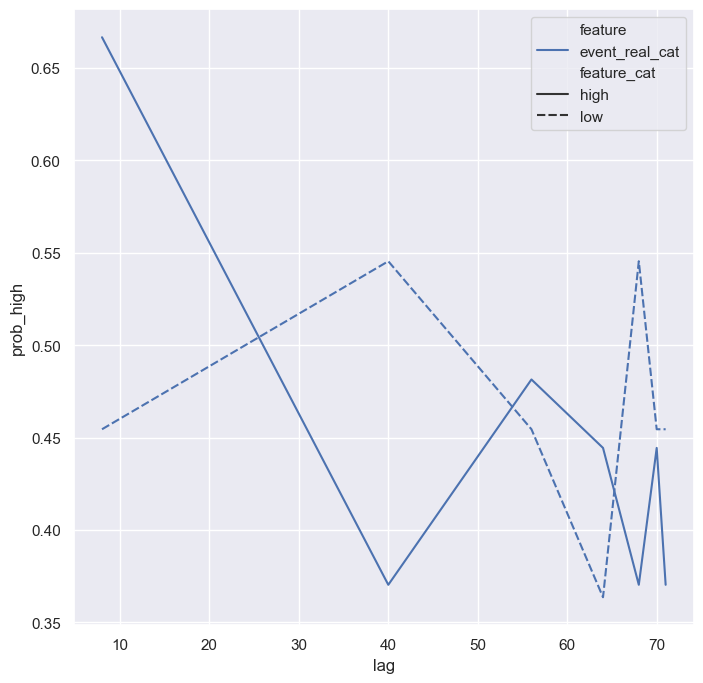

In [206]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"] == "event_real_cat"],
    x="lag",
    y="prob_high",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [207]:
(72-8)*5 / 60

5.333333333333333

Here we can see that if the real event is positive around 5 hours before : 
- THEN the event target HIGH is 66% chance to happened 
- BE CAREFUL :  very low event number < 20

In [208]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
692        vwap_h_ETH_cat        high  64   23079  18513  0.493405  0.395788   
870           Low_ETH_cat        high  56   47042  40435  0.453911   0.39016   
662   ichi_tenkan_ETH_cat        high  64   25262  20525  0.487495  0.396083   
898     min_low_h_ETH_cat        high  56   30599  25390  0.459307  0.381117   
908        vwap_h_ETH_cat        high  56   28826  23813  0.481887  0.398084   
878   ichi_tenkan_ETH_cat        high  56   31288  26086  0.477381   0.39801   
682     min_low_h_ETH_cat        high  64   24977  20361  0.460898   0.37572   
654           Low_ETH_cat        high  64   43704  37536  0.452976  0.389047   
866          Open_ETH_cat        high  56   38424  32677  0.468157  0.398136   
650          Open_ETH_cat        high  64   32731  27474  0.473518  0.397465   
868          High_ETH_cat        high  56   39183  33469      0.47  0.401461   
446   ichi_tenkan_ETH_cat        high  68   19905  15896  0.496942  0.396854   
652          High_ETH_cat        high  64   33842  28607  0.475763  0.402168   
694        vwap_d_ETH_cat        high  64   19870  15927  0.497471  0.398753   
466     min_low_h_ETH_cat        high  68   19732  15822  0.459471  0.368425   
476        vwap_h_ETH_cat        high  68   18345  14583  0.500055  0.397509   
478        vwap_d_ETH_cat        high  68   16416  12914   0.50626  0.398261   
438           Low_ETH_cat        high  68   38825  33506  0.450474  0.388759   
910        vwap_d_ETH_cat        high  56   24610  20418   0.48382  0.401408   
250     min_low_h_ETH_cat        high  70   15145  11933  0.455283  0.358725   
260        vwap_h_ETH_cat        high  70   14951  11770  0.506179  0.398483   
876    ichi_kijun_ETH_cat        high  56   23465  19474  0.484324  0.401948   
171         rsi_h_ETH_cat         low  71   12479   9629  0.491919  0.379573   
262        vwap_d_ETH_cat        high  70   14225  11177  0.509382  0.400236   
660    ichi_kijun_ETH_cat        high  64   18946  15419   0.49448  0.402427   
46         vwap_d_ETH_cat        high  71   12999  10120  0.512417  0.398928   
444    ichi_kijun_ETH_cat        high  68   15913  12733  0.502177  0.401824   
230   ichi_tenkan_ETH_cat        high  70   15594  12449  0.501254  0.400161   
1084         High_ETH_cat        high  40   43216  37882  0.459549  0.402829   
169         rsi_h_BTC_cat         low  71   12384   9679  0.488174  0.381544   

      delta_prob  
692    1002.5176  
870   998.032603  
662   980.154585  
898   969.250424  
908   954.811794  
878   943.312441  
682   939.938065  
654   936.588479  
866   929.044852  
650   918.064912  
868   898.799648  
446    897.85654  
652    877.68339  
694   868.634187  
466    859.99325  
476   859.611516  
478   836.277122  
438   782.285908  
910   780.530514  
250   762.016693  
260   757.363946  
876    741.89343  
171   734.801882  
262   731.462405  
660   723.976662  
46    717.041481  
444   706.025274  
230   705.418465  
1084  701.658635  
169   663.284685

In [209]:
list_feat_high = list(df_prob.sort_values(by=["delta_prob"], ascending=False)["feature"].unique()[:10])

In [210]:
df_prob.sort_values(by=["delta_prob"]).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
681    max_high_h_ETH_cat         low  64   21408  25571  0.379696  0.453531   
465    max_high_h_ETH_cat         low  68   16546  20175  0.374217  0.456293   
249    max_high_h_ETH_cat         low  70   12294  15434  0.363739  0.456641   
897    max_high_h_ETH_cat         low  56   27216  31546  0.386783  0.448319   
170         rsi_h_ETH_cat        high  71    9716  12325  0.383002  0.485848   
693        vwap_h_ETH_cat         low  64   19266  22856  0.402768  0.477819   
663   ichi_tenkan_ETH_cat         low  64   21270  24918   0.40445  0.473816   
879   ichi_tenkan_ETH_cat         low  56   27355  31358  0.404313  0.463478   
651          Open_ETH_cat         low  64   28999  33076  0.404438  0.461298   
869          High_ETH_cat         low  56   43125  47925  0.396866  0.441038   
867          Open_ETH_cat         low  56   34814  39062  0.403683   0.45294   
479        vwap_d_ETH_cat         low  68   13290  15959  0.405826  0.487327   
653          High_ETH_cat         low  64   39719  44196  0.397456  0.442256   
447   ichi_tenkan_ETH_cat         low  68   16413  19333  0.407513  0.480013   
477        vwap_h_ETH_cat         low  68   15106  17882  0.407477  0.482359   
33     max_high_h_ETH_cat         low  71    9031  11204  0.355972  0.441624   
263        vwap_d_ETH_cat         low  70   11375  13781  0.406148  0.492056   
695        vwap_d_ETH_cat         low  64   16591  19469  0.407762  0.478495   
909        vwap_h_ETH_cat         low  56   25267  28731  0.407138  0.462955   
1113   max_high_h_ETH_cat         low  40   33140  37064   0.39625  0.443169   
231   ichi_tenkan_ETH_cat         low  70   12750  15190    0.4077  0.485723   
261        vwap_h_ETH_cat         low  70   12180  14551  0.408917  0.488518   
655           Low_ETH_cat         low  64   30113  33756  0.411335  0.461097   
168         rsi_h_BTC_cat        high  71    9934  12067  0.391596  0.475678   
47         vwap_d_ETH_cat         low  71   10361  12508  0.408428  0.493062   
871           Low_ETH_cat         low  56   35514  39367  0.409086  0.453469   
437          High_ETH_cat         low  68   35047  38861  0.397683  0.440961   
37     max_high_d_ETH_cat         low  71    9479  11442   0.37366  0.451041   
253    max_high_d_ETH_cat         low  70    9549  11503  0.374368  0.450974   
435          Open_ETH_cat         low  68   23210  26156   0.41052  0.462627   

      delta_prob  
681  -737.800677  
465  -717.281174  
249  -711.165609  
897  -638.130084  
170  -617.656277  
693  -611.941503  
663  -576.249415  
879  -545.841943  
651  -535.543423  
869  -506.095552  
867   -488.53495  
479  -487.097747  
653  -477.710278  
447  -477.054775  
477  -467.210865  
33   -466.709068  
263  -460.235014  
695  -459.394565  
909  -444.434831  
1113 -438.658082  
231  -426.170365  
261  -420.608357  
655  -415.583429  
168  -413.589291  
47   -403.131663  
871  -396.512039  
437  -393.640634  
37   -368.373309  
253  -362.731902  
435   -351.61512

In [211]:
list_feat_low = list(df_prob.sort_values(by=["delta_prob"])["feature"].unique()[:10])

In [212]:

list_feat_prob = list(set(list_feat_low + list_feat_high))
list_feat_prob

['min_low_h_ETH_cat',
 'Open_ETH_cat',
 'rsi_h_BTC_cat',
 'max_high_h_ETH_cat',
 'vwap_h_ETH_cat',
 'rsi_h_ETH_cat',
 'Low_ETH_cat',
 'High_ETH_cat',
 'vwap_d_ETH_cat',
 'ichi_tenkan_ETH_cat',
 'max_high_d_ETH_cat',
 'ichi_kijun_ETH_cat']

<Axes: xlabel='lag', ylabel='delta_prob'>

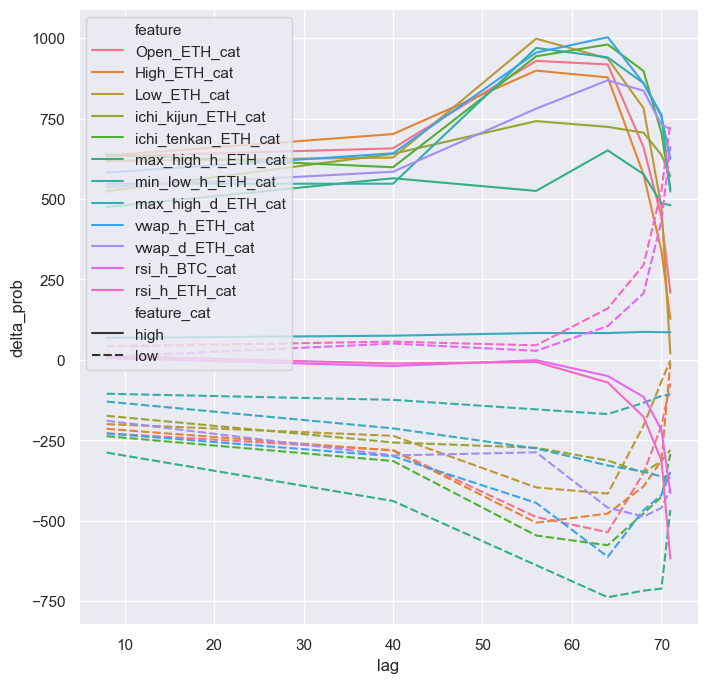

In [213]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="delta_prob",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

<Axes: xlabel='lag', ylabel='prob_high'>

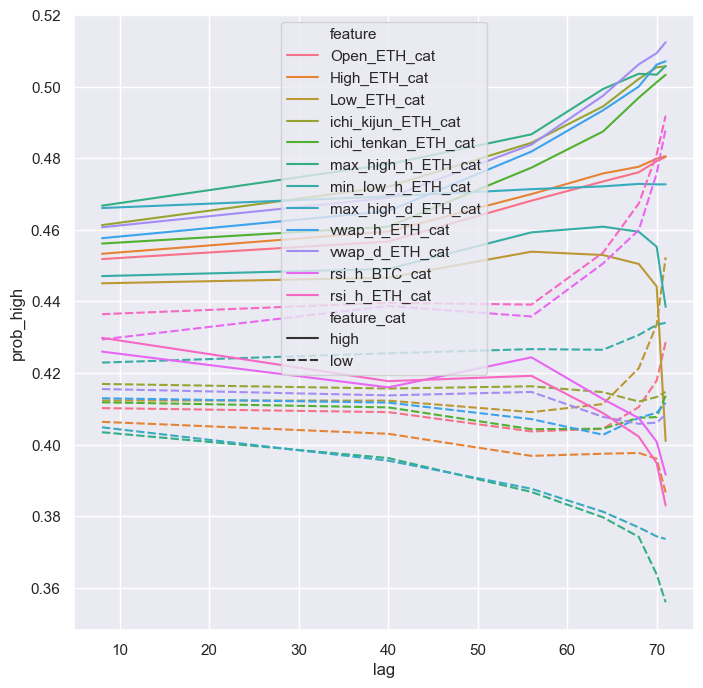

In [214]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high target for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="prob_high",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [215]:
df_prob[(df_prob["feature"] == "vwap_d_ETH_cat") & (df_prob["feature_cat"] == "high")].sort_values(by=["lag"])

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1342  vwap_d_ETH_cat        high   8   36189  31913  0.460731  0.406292   
1126  vwap_d_ETH_cat        high  40   30200  26142  0.468959  0.405944   
910   vwap_d_ETH_cat        high  56   24610  20418   0.48382  0.401408   
694   vwap_d_ETH_cat        high  64   19870  15927  0.497471  0.398753   
478   vwap_d_ETH_cat        high  68   16416  12914   0.50626  0.398261   
262   vwap_d_ETH_cat        high  70   14225  11177  0.509382  0.400236   
46    vwap_d_ETH_cat        high  71   12999  10120  0.512417  0.398928   

      delta_prob  
1342  536.964436  
1126  584.550211  
910   780.530514  
694   868.634187  
478   836.277122  
262   731.462405  
46    717.041481

<Axes: xlabel='lag', ylabel='prob_low'>

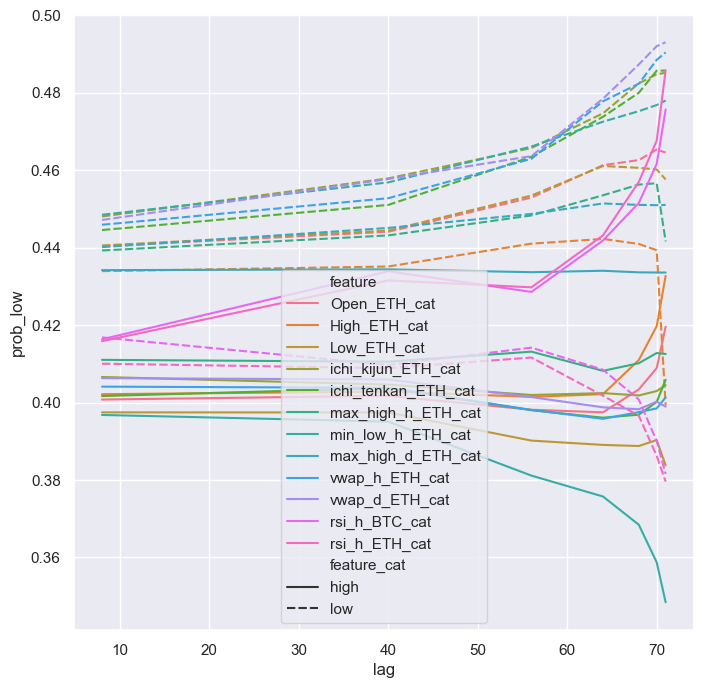

In [216]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob low target for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="prob_low",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [217]:
df_['event_pred'].value_counts()

event_pred
 0.0    253628
 1.0        25
-1.0        24
Name: count, dtype: int64

In [218]:
len(list_df)

7

In [219]:
df = list_df[-1]

In [220]:
pd.crosstab(df['Volume_ETH_cat'], df['target_cat'], margins=True, normalize=True)

target_cat          high       low   neutral       All
Volume_ETH_cat                                        
high            0.045684  0.042566  0.011657  0.099907
low             0.038632  0.038100  0.023400  0.100131
neutral         0.340125  0.335111  0.124726  0.799962
All             0.424441  0.415777  0.159782  1.000000

##### With Best Positive Corr Features

max_high_h_ETH & Volume_ETH are the best positive impact on price. 

In [221]:
df_prob[
    (df_prob["feature"] == "max_high_h_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_high", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
32    max_high_h_ETH_cat        high  71   12831  10465  0.505795  0.412528   
464   max_high_h_ETH_cat        high  68   15201  12380  0.503611  0.410151   
248   max_high_h_ETH_cat        high  70   13675  11214  0.503368   0.41278   
680   max_high_h_ETH_cat        high  64   17746  14506  0.499353  0.408183   
896   max_high_h_ETH_cat        high  56   21246  18035  0.486691  0.413135   
1112  max_high_h_ETH_cat        high  40   26095  22396  0.478342  0.410537   
1328  max_high_h_ETH_cat        high   8   31315  27575  0.466768  0.411021   

      delta_prob  
32     480.59375  
464   577.066894  
248   486.682551  
680   650.973583  
896   524.962246  
1112  564.335691  
1328  475.041603

Correlation confirmed and good for strat 2

In [222]:
df_prob[
    (df_prob["feature"] == "Volume_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_high", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
366   Volume_ETH_cat        high  70   11959  11311  0.471439  0.445894   
150   Volume_ETH_cat        high  71   11945  11457  0.470869  0.451632   
582   Volume_ETH_cat        high  68   11781  11309  0.464441  0.445833   
1230  Volume_ETH_cat        high  40   11627  10975  0.458677  0.432956   
1014  Volume_ETH_cat        high  56   11630  11132   0.45856  0.438924   
798   Volume_ETH_cat        high  64   11606  11327  0.457596  0.446595   
1446  Volume_ETH_cat        high   8   11589  10798  0.457268  0.426057   

     delta_prob  
366   36.089729  
150   20.352449  
582   19.297012  
1230  37.616494  
1014  21.791055  
798    6.788558  
1446  55.896815

=> Correlation with less impact on strat 2

##### With Best Negative Corr Features
min_low_h_ETH & Close_ETH_raw are the best negative impact on price. 

In [223]:
##### On Best Negative Corr Features
df_prob[
    (df_prob["feature"] == "min_low_h_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_low", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1330  min_low_h_ETH_cat        high   8   40785  36196  0.447091  0.396786   
1114  min_low_h_ETH_cat        high  40   35556  31279  0.449087  0.395067   
898   min_low_h_ETH_cat        high  56   30599  25390  0.459307  0.381117   
682   min_low_h_ETH_cat        high  64   24977  20361  0.460898   0.37572   
466   min_low_h_ETH_cat        high  68   19732  15822  0.459471  0.368425   
250   min_low_h_ETH_cat        high  70   15145  11933  0.455283  0.358725   
34    min_low_h_ETH_cat        high  71   11124   8839  0.438471  0.348404   

      delta_prob  
1330  547.119965  
1114  547.399686  
898   969.250424  
682   939.938065  
466    859.99325  
250   762.016693  
34    523.090217

=> No clear conclusion

In [224]:
df_prob[
    (df_prob["feature"] == "Close_ETH_raw_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_low", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
214   Close_ETH_raw_cat        high  71   10695  11055  0.421594  0.435785   
430   Close_ETH_raw_cat        high  70   10700  11050  0.421791  0.435588   
646   Close_ETH_raw_cat        high  68   10703  11045  0.421909  0.435391   
862   Close_ETH_raw_cat        high  64   10713  11043  0.422304  0.435312   
1078  Close_ETH_raw_cat        high  56   10733  11027  0.423092  0.434681   
1294  Close_ETH_raw_cat        high  40   10739  11005  0.423329  0.433814   
1510  Close_ETH_raw_cat        high   8   10775  10996  0.424748  0.433459   

     delta_prob  
214  -11.917241  
430  -11.264368  
646  -10.756299  
862  -10.011031  
1078  -7.944485  
1294  -6.508094  
1510  -4.486794

=> No clear conclusion

#### First LAG (oldest)
I_past closest to 0 is the oldest

In [225]:
len(list_df)

7

In [226]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [227]:
min_I_list_past = np.argmin(list_past)
min_I_list_past

np.int64(6)

In [228]:
df = list_df[min_I_list_past]

In [229]:
f"chi2_{list_past[min_I_list_past]}"

'chi2_8'

Text(0.5, 1.0, 'Min Chi2 between FIRST Lag and Target cat')

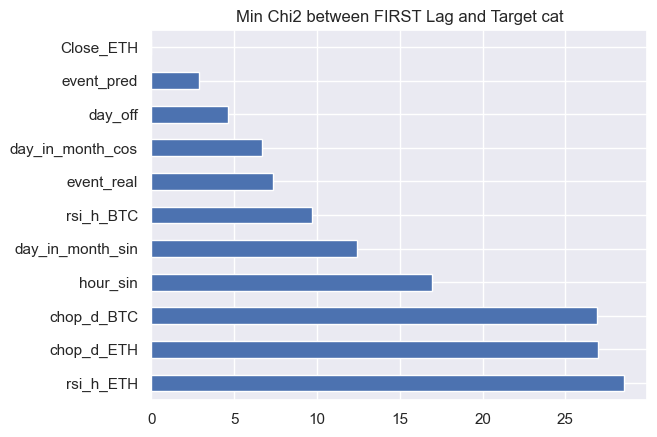

In [230]:
# find chi2_0 values in the 10% highest quantiles 
first_col_chi2 = f"chi2_{list_past[min_I_list_past]}"
min_quantile_chi2_10 = df_cont[first_col_chi2].quantile(0.10)
min_chi2_0 = df_cont[first_col_chi2].sort_values(ascending=False)
min_chi2_0[min_chi2_0.values<min_quantile_chi2_10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between FIRST Lag and Target cat")


Results : We can see that some features have less impact on distrib :
- we are not going to study them
- we are going to study the features with the highest chi2

Text(0.5, 1.0, 'Max Chi2 between FIRST Lag and Target cat')

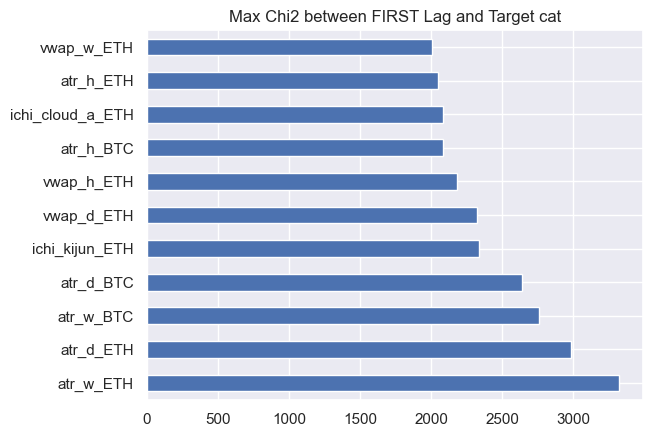

In [231]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_90 = df_cont[first_col_chi2].quantile(0.90)
max_chi2_0 = df_cont[first_col_chi2].sort_values(ascending=False)
max_chi2_0[max_chi2_0.values>max_quantile_chi2_90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between FIRST Lag and Target cat")

expected:  [[10722.6609941  10503.7681737   4036.5708322 ]
 [10754.06965156 10534.53565361  4048.39469483]
 [86194.26935434 84434.69617269 32448.03447297]]
target_cat         high       low  neutral     Total
atr_w_ETH_cat                                       
high            11791.0   11268.0   2204.0   25263.0
low              9189.0    9306.0   6842.0   25337.0
neutral         86691.0   84899.0  31487.0  203077.0
total          107671.0  105473.0  40533.0  253677.0
xi_n =  3326.6735482824834
chi2:  3326.6735482824834
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


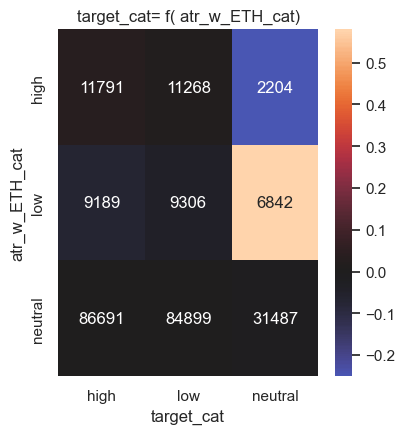

target_cat      high    low  neutral
atr_w_ETH_cat                       
high           11791  11268     2204
low             9189   9306     6842
neutral        86691  84899    31487

In [232]:
feat_name_max = max_chi2_0.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
I_past = 0
plot_cont(X=X, Y=Y, data=df)

In [233]:
Y

'target_cat'

In [234]:
len(list_col_select)

108

In [235]:
len(list_col_select)*(len(list_col_select)-1)*(len(list_col_select)-2)

1224936

In [236]:
3*3*3

27

In [237]:
# create contingency dataframe
col_name_0 = f"{max_chi2_0.index[0]}_cat"
col_name_1 = f"{max_chi2_0.index[1]}_cat"
col_name_2 = f"{max_chi2_0.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  1700490.1838599509
p-value:  0.0


target_cat                                  high    low  neutral    p_high  \
atr_w_ETH_cat atr_d_ETH_cat atr_w_BTC_cat                                    
high          high          high            5824   5410      940  0.478397   
                            low                0      0        0       NaN   
                            neutral         2091   1938      435  0.468414   
              low           high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              neutral       high            1951   1935      404  0.454779   
                            low                0      0        0       NaN   
                            neutral         1925   1985      425  0.444060   
low           high          high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              low           high               0      0        0       NaN   
                            low             5369   5527     4459  0.349658   
                            neutral          955    973      634  0.372756   
              neutral       high               0      0        0       NaN   
                            low             2058   2020     1291  0.383312   
                            neutral          807    786      458  0.393467   
neutral       high          high             574    485      125  0.484797   
                            low                0      0        0       NaN   
                            neutral         3498   3164      884  0.463557   
              low           high               0      0        0       NaN   
                            low              373    392      177  0.395966   
                            neutral         2551   2586     1477  0.385697   
              neutral       high            3311   3091      924  0.451952   
                            low             1591   1518      729  0.414539   
                            neutral        74793  73663    27171  0.425863   

target_cat                                    p_low  p_neutral  \
atr_w_ETH_cat atr_d_ETH_cat atr_w_BTC_cat                        
high          high          high           0.444390   0.077214   
                            low                 NaN        NaN   
                            neutral        0.434140   0.097446   
              low           high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              neutral       high           0.451049   0.094172   
                            low                 NaN        NaN   
                            neutral        0.457901   0.098039   
low           high          high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              low           high                NaN        NaN   
                            low            0.359948   0.290394   
                            neutral        0.379781   0.247463   
              neutral       high                NaN        NaN   
                            low            0.376234   0.240454   
                            neutral        0.383228   0.223306   
neutral       high          high           0.409628   0.105574   
                            low                 NaN        NaN   
                            neutral        0.419295   0.117148   
              low           high                NaN        NaN   
                            low            0.416136   0.187898   
                            neutral        0.390989   0.223314   
              neutral

In [238]:
# Threshold of prob 40%  : to have 15% to 30% of gains with nb trades per months on average :
# - 30 trades (with 2.5% cap risk) => 15% gains
# - to 300 trades (0.5 % capital risk)  => 30% gains
prob_tot = df_cross[["high", "neutral","low"]].sum(axis=0) / df_cross[["high", "neutral","low"]].sum().sum()
print("prob_tot: ", prob_tot)
#prob_target = 0.33
nb_per_sub_cat = df_cross[["high","low","neutral"]].sum(axis=1)
nb_per_sub_cat
#df_cross["exp_trigger_high"] = nb_per_sub_cat * prob_target
#df_cross["exp_trigger_low"] = nb_per_sub_cat * prob_target
#df_cross["exp_trigger_neutral"] = nb_per_sub_cat * prob_target


#df_cross["chi2_trigger_low"] = np.sign(df_cross["low"] - df_cross["exp_trigger_low"]) * (df_cross["low"] - df_cross["exp_trigger_low"])**2 / df_cross["exp_trigger_low"]
#df_cross["chi2_trigger_neutral"] = np.sign(df_cross["neutral"] - df_cross["exp_trigger_neutral"]) *  (df_cross["neutral"] - df_cross["exp_trigger_neutral"])**2 / df_cross["exp_trigger_neutral"]

df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"])



prob_tot:  target_cat
high       0.424441
neutral    0.159782
low        0.415777
dtype: float64


high    low  neutral    p_high  \
atr_w_ETH_cat atr_d_ETH_cat atr_w_BTC_cat                                    
high          high          high            5824   5410      940  0.478397   
                            low                0      0        0       NaN   
                            neutral         2091   1938      435  0.468414   
              low           high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              neutral       high            1951   1935      404  0.454779   
                            low                0      0        0       NaN   
                            neutral         1925   1985      425  0.444060   
low           high          high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              low           high               0      0        0       NaN   
                            low             5369   5527     4459  0.349658   
                            neutral          955    973      634  0.372756   
              neutral       high               0      0        0       NaN   
                            low             2058   2020     1291  0.383312   
                            neutral          807    786      458  0.393467   
neutral       high          high             574    485      125  0.484797   
                            low                0      0        0       NaN   
                            neutral         3498   3164      884  0.463557   
              low           high               0      0        0       NaN   
                            low              373    392      177  0.395966   
                            neutral         2551   2586     1477  0.385697   
              neutral       high            3311   3091      924  0.451952   
                            low             1591   1518      729  0.414539   
                            neutral        74793  73663    27171  0.425863   

                                              p_low  p_neutral  \
atr_w_ETH_cat atr_d_ETH_cat atr_w_BTC_cat                        
high          high          high           0.444390   0.077214   
                            low                 NaN        NaN   
                            neutral        0.434140   0.097446   
              low           high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              neutral       high           0.451049   0.094172   
                            low                 NaN        NaN   
                            neutral        0.457901   0.098039   
low           high          high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              low           high                NaN        NaN   
                            low            0.359948   0.290394   
                            neutral        0.379781   0.247463   
              neutral       high                NaN        NaN   
                            low            0.376234   0.240454   
                            neutral        0.383228   0.223306   
neutral       high          high           0.409628   0.105574   
                            low                 NaN        NaN   
                            neutral        0.419295   0.117148   
              low           high                NaN        NaN   
                            low            0.416136   0.187898   
                            neutral        0.390989   0.223314   
              neutral       high           0.421922   0.126126   

In [239]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] > 10]

high    low  neutral    p_high  \
atr_w_ETH_cat atr_d_ETH_cat atr_w_BTC_cat                                    
high          high          high            5824   5410      940  0.478397   
                            neutral         2091   1938      435  0.468414   
neutral       high          high             574    485      125  0.484797   
                            neutral         3498   3164      884  0.463557   
              neutral       high            3311   3091      924  0.451952   
                            neutral        74793  73663    27171  0.425863   

                                              p_low  p_neutral  \
atr_w_ETH_cat atr_d_ETH_cat atr_w_BTC_cat                        
high          high          high           0.444390   0.077214   
                            neutral        0.434140   0.097446   
neutral       high          high           0.409628   0.105574   
                            neutral        0.419295   0.117148   
              neutral       high           0.421922   0.126126   
                            neutral        0.419429   0.154709   

                                           chi2_delta_high  
atr_w_ETH_cat atr_d_ETH_cat atr_w_BTC_cat                   
high          high          high                 30.513797  
                            neutral              11.620253  
neutral       high          high                 14.959396  
                            neutral              33.490243  
              neutral       high                 15.120275  
                            neutral              17.202403

In [240]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] > 10].sum().sum() / df_cross.filter(["high","low","neutral"]).sum().sum()

np.float64(0.8217138580466956)

In [241]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] < -10]

Empty DataFrame
Columns: [high, low, neutral, p_high, p_low, p_neutral, chi2_delta_high]
Index: []

In [242]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] < -10].sum().sum() / df_cross.filter(["high","low","neutral"]).sum().sum()

np.float64(0.0)

In [243]:
((2-1)**2) / 1


1.0

In [244]:
((2000-1000)**2) / 1000

1000.0

In [245]:
22000 / df.shape[0]

0.08672445669098894

In [246]:
100*5/60

8.333333333333334

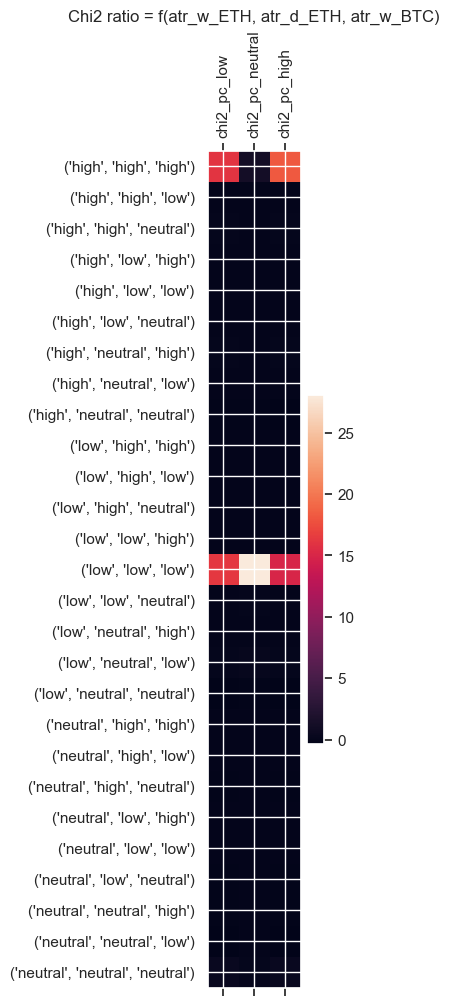

In [247]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

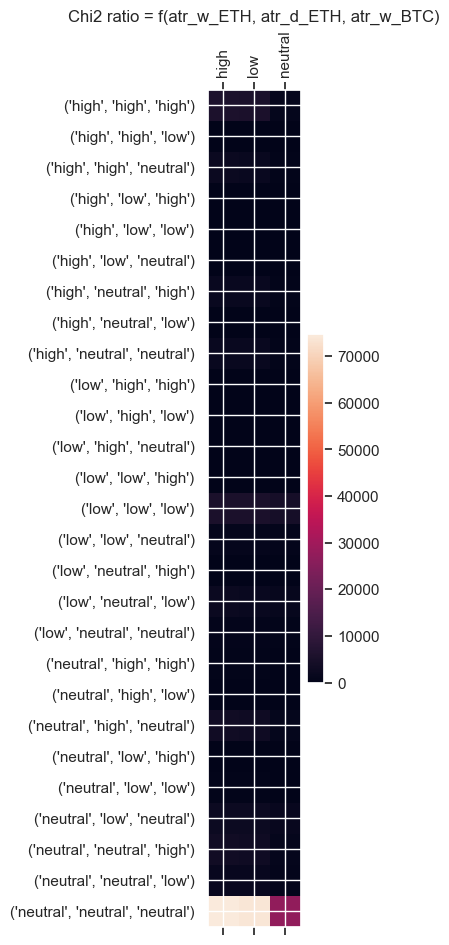

In [248]:
plot_corr(
    df_cross[["high","low","neutral"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

#### LAST Lag (newest)

In [249]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [250]:
df = list_df[0]

Text(0.5, 1.0, 'Min Chi2 between LAST Lag and LAST Target')

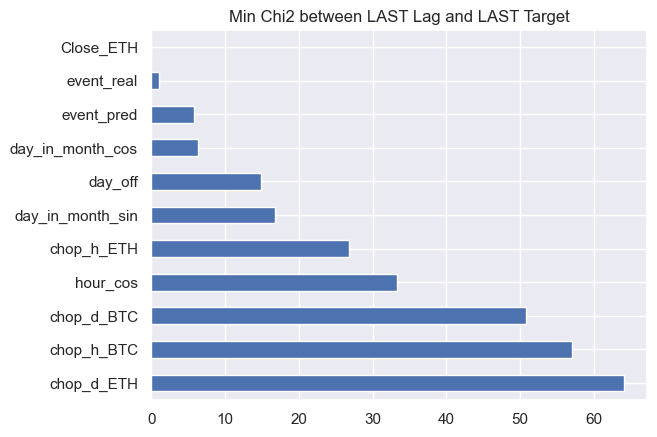

In [251]:
# find chi2_0 values in the 10% highest quantiles 
chi2_name = f"chi2_{list_past[0]}"
min_quantile_chi2_q10 = df_cont[chi2_name].quantile(0.10)
min_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
min_chi2_last[min_chi2_last.values<min_quantile_chi2_q10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between LAST Lag and LAST Target")

Text(0.5, 1.0, 'Max Chi2 between LAST Lag and Target cat')

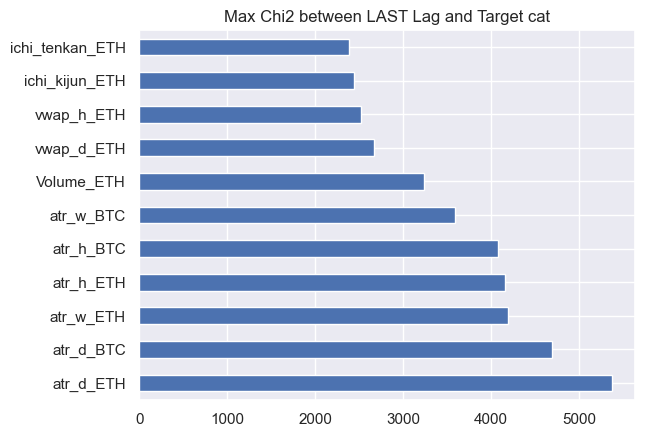

In [252]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_q90 = df_cont[chi2_name].quantile(0.90)
max_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
max_chi2_last[max_chi2_last.values>max_quantile_chi2_q90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between LAST Lag and Target cat")

expected:  [[10767.2273324  10547.42473303  4053.34793458]
 [10767.2273324  10547.42473303  4053.34793458]
 [86136.54533521 84378.15053395 32426.30413084]]
target_cat         high       low  neutral     Total
atr_d_ETH_cat                                       
high            12162.0   11426.0   1780.0   25368.0
low              8819.0    8911.0   7638.0   25368.0
neutral         86690.0   85136.0  31115.0  202941.0
total          107671.0  105473.0  40533.0  253677.0
xi_n =  5368.829889814026
chi2:  5368.8298898140265
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


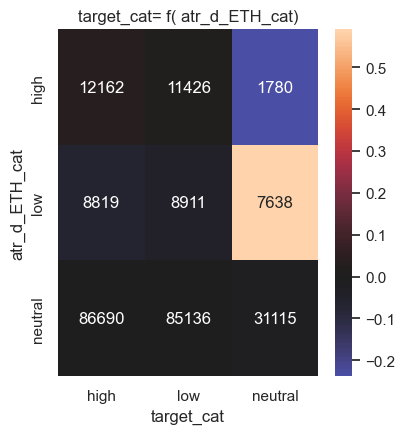

target_cat      high    low  neutral
atr_d_ETH_cat                       
high           12162  11426     1780
low             8819   8911     7638
neutral        86690  85136    31115

In [253]:
feat_name_max = max_chi2_last.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

In [254]:
Y

'target_cat'

In [255]:
X

'atr_d_ETH_cat'

In [256]:
max_chi2_last.index[1]

'atr_d_BTC'

In [257]:
# create contingency dataframe
col_name_0 = f"{max_chi2_last.index[0]}_cat"
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  1895807.9080452581
p-value:  0.0


target_cat                                  high    low  neutral    p_high  \
atr_d_ETH_cat atr_d_BTC_cat atr_w_ETH_cat                                    
high          high          high            6287   5968      836  0.480254   
                            low                0      0        0       NaN   
                            neutral         1929   1839      288  0.475592   
              low           high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              neutral       high            1801   1608      292  0.486625   
                            low                0      0        0       NaN   
                            neutral         2145   2011      364  0.474558   
low           high          high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              low           high               0      0        0       NaN   
                            low             5070   5192     5135  0.329285   
                            neutral         1591   1589     1089  0.372687   
              neutral       high               0      0        0       NaN   
                            low              950    886      573  0.394355   
                            neutral         1208   1244      841  0.366839   
neutral       high          high            1100   1088      213  0.458142   
                            low                0      0        0       NaN   
                            neutral         2682   2515      623  0.460825   
              low           high               0      0        0       NaN   
                            low              512    567      315  0.367288   
                            neutral         1792   1630      886  0.415970   
              neutral       high            2811   2695      669  0.455223   
                            low             2602   2388     1178  0.421855   
                            neutral        75191  74253    27231  0.425589   

target_cat                                    p_low  p_neutral  \
atr_d_ETH_cat atr_d_BTC_cat atr_w_ETH_cat                        
high          high          high           0.455886   0.063861   
                            low                 NaN        NaN   
                            neutral        0.453402   0.071006   
              low           high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              neutral       high           0.434477   0.078898   
                            low                 NaN        NaN   
                            neutral        0.444912   0.080531   
low           high          high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              low           high                NaN        NaN   
                            low            0.337209   0.333507   
                            neutral        0.372218   0.255095   
              neutral       high                NaN        NaN   
                            low            0.367787   0.237858   
                            neutral        0.377771   0.255390   
neutral       high          high           0.453145   0.088713   
                            low                 NaN        NaN   
                            neutral        0.432131   0.107045   
              low           high                NaN        NaN   
                            low            0.406743   0.225968   
                            neutral        0.378366   0.205664   
              neutral

In [258]:
# df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross

In [259]:
df_cross["high"] / df.shape[0]

atr_d_ETH_cat  atr_d_BTC_cat  atr_w_ETH_cat
high           high           high             0.024783
                              low              0.000000
                              neutral          0.007604
               low            high             0.000000
                              low              0.000000
                              neutral          0.000000
               neutral        high             0.007100
                              low              0.000000
                              neutral          0.008456
low            high           high             0.000000
                              low              0.000000
                              neutral          0.000000
               low            high             0.000000
                              low              0.019986
                              neutral          0.006272
               neutral        high             0.000000
                              low              0.003745
    

In [260]:
df_cross["high"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.4244413171079759)

In [261]:
df_cross["low"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.41577675548039433)

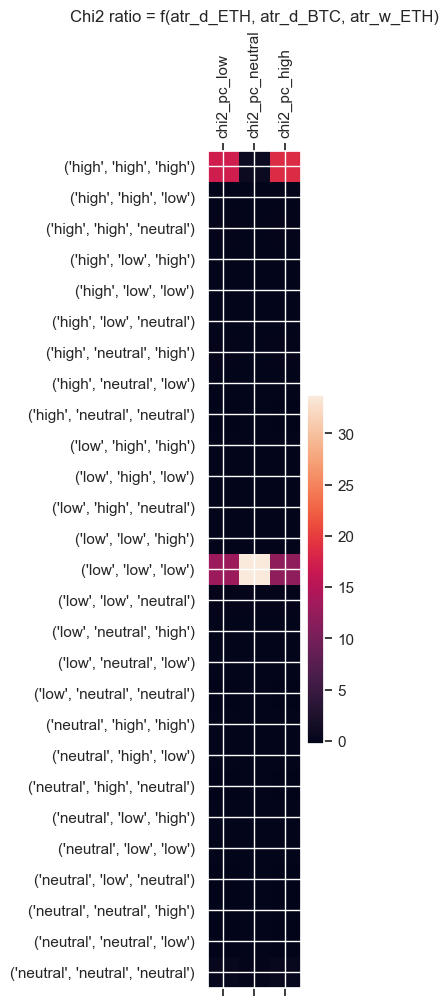

In [262]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

In [263]:
list_len_levels = []
for I in range(len(df_cross.index.levels)): 
    list_len_levels.append(len(df_cross.index.levels[I]))
list_len_levels

[3, 3, 3]

In [264]:
df_cross.index.unique(level=2)

Index(['high', 'low', 'neutral'], dtype='object', name='atr_w_ETH_cat')

##### check on first LAG (oldest)
We keep the same Features to do the cross table, and apply cat using for the FIRST Lag (oldest)  
To detect if these features are still important with oldest time

In [265]:
list_past[-1]

8

In [266]:
df = list_df[-1]

In [267]:
# create contingency dataframe
col_name_0 = f"{max_chi2_last.index[0]}_cat"
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  1788070.6141277389
p-value:  0.0


target_cat                                  high    low  neutral    p_high  \
atr_d_ETH_cat atr_d_BTC_cat atr_w_ETH_cat                                    
high          high          high            6150   5790     1030  0.474171   
                            low                0      0        0       NaN   
                            neutral         1975   1750      447  0.473394   
              low           high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              neutral       high            1765   1558      345  0.481189   
                            low                0      0        0       NaN   
                            neutral         2097   1899      562  0.460070   
low           high          high               0      0        0       NaN   
                            low                0      0        0       NaN   
                            neutral            0      0        0       NaN   
              low           high               0      0        0       NaN   
                            low             5434   5601     4491  0.349994   
                            neutral         1648   1670      938  0.387218   
              neutral       high               0      0        0       NaN   
                            low              890    899      602  0.372229   
                            neutral         1276   1308      716  0.386667   
neutral       high          high            1022   1118      219  0.433234   
                            low                0      0        0       NaN   
                            neutral         2651   2478      736  0.452003   
              low           high               0      0        0       NaN   
                            low              602    467      299  0.440058   
                            neutral         1764   1718      845  0.407673   
              neutral       high            2854   2802      610  0.455474   
                            low             2263   2339     1450  0.373926   
                            neutral        75280  74076    27243  0.426276   

target_cat                                    p_low  p_neutral  \
atr_d_ETH_cat atr_d_BTC_cat atr_w_ETH_cat                        
high          high          high           0.446415   0.079414   
                            low                 NaN        NaN   
                            neutral        0.419463   0.107143   
              low           high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              neutral       high           0.424755   0.094057   
                            low                 NaN        NaN   
                            neutral        0.416630   0.123300   
low           high          high                NaN        NaN   
                            low                 NaN        NaN   
                            neutral             NaN        NaN   
              low           high                NaN        NaN   
                            low            0.360750   0.289257   
                            neutral        0.392387   0.220395   
              neutral       high                NaN        NaN   
                            low            0.375993   0.251777   
                            neutral        0.396364   0.216970   
neutral       high          high           0.473930   0.092836   
                            low                 NaN        NaN   
                            neutral        0.422506   0.125490   
              low           high                NaN        NaN   
                            low            0.341374   0.218567   
                            neutral        0.397042   0.195285   
              neutral

Results : same rank for chi-2  as for last lag, but smaller values: time between have impact => less direct impact

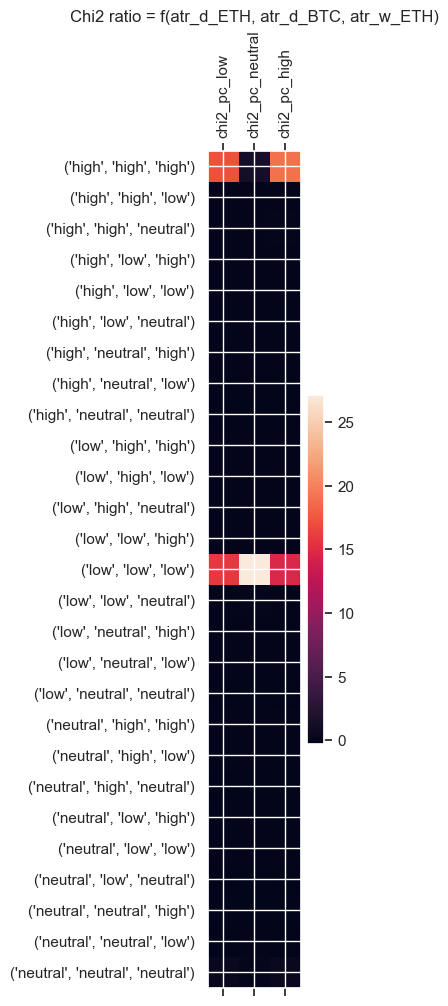

In [268]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

expected:  [[10767.2273324  10547.42473303  4053.34793458]
 [10811.79367069 10591.08129235  4070.12503696]
 [86091.97899691 84334.49397462 32409.52702847]]
target_cat         high       low  neutral     Total
atr_d_ETH_cat                                       
high            11987.0   10997.0   2384.0   25368.0
low              9248.0    9478.0   6747.0   25473.0
neutral         86436.0   84998.0  31402.0  202836.0
total          107671.0  105473.0  40533.0  253677.0
xi_n =  2986.4874371973256
chi2:  2986.4874371973256
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


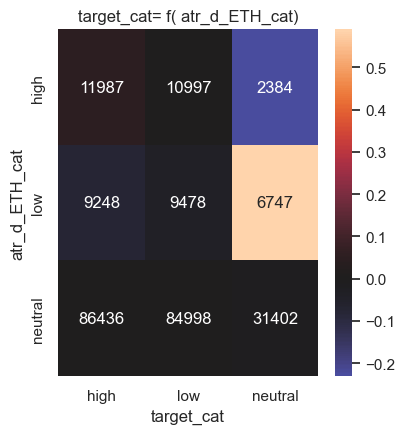

target_cat      high    low  neutral
atr_d_ETH_cat                       
high           11987  10997     2384
low             9248   9478     6747
neutral        86436  84998    31402

In [269]:
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

### Prob study

In [270]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [271]:

def get_index_combinations(n_elements, k_selection):
    """
    Generates all combinations of indices for selecting k elements from a list of n.

    Args:
        n_elements (int): The total number of elements in the list.
        k_selection (int): The number of elements to choose in each combination.

    Returns:
        list: A list of tuples, where each tuple is a combination of indices.
    """
    # Create a list of indices from 0 to n_elements - 1
    indices = range(n_elements)

    # Generate the combinations
    combinations = list(itertools.combinations(indices, k_selection))
    
    return combinations

In [272]:
get_index_combinations(6, 3)

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 3, 4),
 (0, 3, 5),
 (0, 4, 5),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 5),
 (2, 3, 4),
 (2, 3, 5),
 (2, 4, 5),
 (3, 4, 5)]

#### On Highest delta_prob
delta prob between high and low

##### Per feature, per lag

In [273]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(7)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
692       vwap_h_ETH_cat        high  64   23079  18513  0.493405  0.395788   
870          Low_ETH_cat        high  56   47042  40435  0.453911   0.39016   
662  ichi_tenkan_ETH_cat        high  64   25262  20525  0.487495  0.396083   
898    min_low_h_ETH_cat        high  56   30599  25390  0.459307  0.381117   
908       vwap_h_ETH_cat        high  56   28826  23813  0.481887  0.398084   
878  ichi_tenkan_ETH_cat        high  56   31288  26086  0.477381   0.39801   
682    min_low_h_ETH_cat        high  64   24977  20361  0.460898   0.37572   

     delta_prob  
692   1002.5176  
870  998.032603  
662  980.154585  
898  969.250424  
908  954.811794  
878  943.312441  
682  939.938065

In [274]:
df_prob.sort_values(by=["delta_prob"], ascending=True).head(7)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
681   max_high_h_ETH_cat         low  64   21408  25571  0.379696  0.453531   
465   max_high_h_ETH_cat         low  68   16546  20175  0.374217  0.456293   
249   max_high_h_ETH_cat         low  70   12294  15434  0.363739  0.456641   
897   max_high_h_ETH_cat         low  56   27216  31546  0.386783  0.448319   
170        rsi_h_ETH_cat        high  71    9716  12325  0.383002  0.485848   
693       vwap_h_ETH_cat         low  64   19266  22856  0.402768  0.477819   
663  ichi_tenkan_ETH_cat         low  64   21270  24918   0.40445  0.473816   

     delta_prob  
681 -737.800677  
465 -717.281174  
249 -711.165609  
897 -638.130084  
170 -617.656277  
693 -611.941503  
663 -576.249415

In [275]:
# check with best linear correlation features
# compare best correlation tuples (feat, lag) and the best delta_prob tuple (feat, lag)

##### Per combinaison of 3 tuples of feature/lag

In [276]:
# algo check new data : 
# - hash input of function : hash of df_prob
# - compare with input hash file on disk : path_prob_hash
# - if same, load df_prob_comb : path_df_prob_comb

# hash input
hash_df_prob = get_data_hash(df_prob)
# load df_prob file hash
path_prob_hash = os.path.join(path_data, 'df_prob_hash.txt')
hash_df_prob_old = load_hash(path_prob_hash)

# compare hash
if hash_df_prob == hash_df_prob_old:
    print("hash match: mode load df_prob_comb")
    # load df_prob_comb
    df_prob_comb = pd.read_csv(path_df_prob_comb)
    mode_do_comb = False
else:
    print("hash not match : mode redo comb")
    mode_do_comb = True



hash not match : mode redo comb


In [277]:
# Probability  of target high or low for Combination of best features (highest and lowest delta_prob) 
# Combinaison of 3 features (1 feat = 1 feature on one lag)
nb_best_feat = 30 # limited to 30th first ones
df_prob_high = df_prob.sort_values(by=["delta_prob"], ascending=False).head(nb_best_feat)
df_prob_low = df_prob.sort_values(by=["delta_prob"], ascending=True).head(nb_best_feat)
list_study_feat_high = df_prob_high["feature"].values
list_study_lag_high = df_prob_high["lag"].values
list_study_I_past_high = [np.argmax(np.array(list_past) == x) for x in list_study_lag_high]
list_study_feat_low = df_prob_low["feature"].values
list_study_lag_low = df_prob_low["lag"].values
list_study_I_past_low = [np.argmax(np.array(list_past) == x) for x in list_study_lag_low]
for I in range(len(list_study_feat_high)):
    print(list_study_feat_high[I], list_study_lag_high[I])
for I in range(len(list_study_feat_low)):
    print(list_study_feat_low[I], list_study_lag_low[I])

# Target cat = High
# get all combinaisons
list_comb_high = get_index_combinations(len(list_study_feat_high), 3)
print("Cross Table Computaton nb : len(list_comb_high) : ", len(list_comb_high))
# Target cat = Low
# get all combinaisons
list_comb_low = get_index_combinations(len(list_study_feat_low), 3)
print("Cross Table Computaton nb : len(list_comb_low) : ", len(list_comb_low))

if mode_do_comb :
    list_cross = []
    df_prob_comb = pd.DataFrame()
    # HIGH
    for comb in list_comb_high:
        col_name_0 = list_study_feat_high[comb[0]]
        col_name_1 = list_study_feat_high[comb[1]]
        col_name_2 = list_study_feat_high[comb[2]]
        I_past_0 = list_study_I_past_high[comb[0]]
        I_past_1 = list_study_I_past_high[comb[1]]
        I_past_2 = list_study_I_past_high[comb[2]]
        lag_0 = list_study_lag_high[comb[0]]
        lag_1 = list_study_lag_high[comb[1]]
        lag_2 = list_study_lag_high[comb[2]]
        df_cross_comb = pd.crosstab(
            [
                list_df[I_past_0][col_name_0],
                list_df[I_past_1][col_name_1], 
                list_df[I_past_2][col_name_2],
            ],
            df_targets["target_cat"], 
            margins=False, 
            dropna=False
        )
        # add probs
        df_cross_comb["p_high"] = df_cross_comb["high"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        df_cross_comb["p_low"] = df_cross_comb["low"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        # just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
        df_cross_comb["delta_prob"] = np.sign(
            df_cross_comb["high"] - df_cross_comb["low"]) * (
                df_cross_comb["high"] - df_cross_comb["low"])**2 / (
                    (df_cross_comb["low"] + df_cross_comb["high"])/2)
        list_cross.append(df_cross_comb)
        df_cross_comb = df_cross_comb.reset_index(allow_duplicates=True)
        df_cross_comb["feat_0"] = df_cross_comb.columns[0]
        df_cross_comb["feat_0_cat"] = df_cross_comb.values[:,0]
        df_cross_comb["lag_0"] = lag_0
        df_cross_comb["feat_1"] = df_cross_comb.columns[1]
        df_cross_comb["feat_1_cat"] = df_cross_comb.values[:,1]
        df_cross_comb["lag_1"] = lag_1
        df_cross_comb["feat_2"] = df_cross_comb.columns[2]
        df_cross_comb["feat_2_cat"] = df_cross_comb.values[:,2]
        df_cross_comb["lag_2"] = lag_2
        df_cross_comb.drop(columns=[col_name_0, col_name_1, col_name_2], inplace=True)
        if df_prob_comb.shape[0] == 0:
            df_prob_comb = df_cross_comb
        else:
            #pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
            df_prob_comb = pd.concat([df_prob_comb, df_cross_comb], ignore_index=True)
    print(" ")
    print("Cross Table Computed nb : len(list_cross) : ", len(list_cross))

    # LOW
    for comb in list_comb_low:
        col_name_0 = list_study_feat_low[comb[0]]
        col_name_1 = list_study_feat_low[comb[1]]
        col_name_2 = list_study_feat_low[comb[2]]
        I_past_0 = list_study_I_past_low[comb[0]]
        I_past_1 = list_study_I_past_low[comb[1]]
        I_past_2 = list_study_I_past_low[comb[2]]
        lag_0 = list_study_lag_low[comb[0]]
        lag_1 = list_study_lag_low[comb[1]]
        lag_2 = list_study_lag_low[comb[2]]
        df_cross_comb = pd.crosstab(
            [
                list_df[I_past_0][col_name_0],
                list_df[I_past_1][col_name_1], 
                list_df[I_past_2][col_name_2]
            ],
            df_targets["target_cat"], 
            margins=False, 
            dropna=False
        )
        # add probs
        df_cross_comb["p_high"] = df_cross_comb["high"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        df_cross_comb["p_low"] = df_cross_comb["low"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        # just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
        df_cross_comb["delta_prob"] = np.sign(
            df_cross_comb["high"] - df_cross_comb["low"]) * (
                df_cross_comb["high"] - df_cross_comb["low"])**2 / (
                    (df_cross_comb["low"] + df_cross_comb["high"])/2)
        list_cross.append(df_cross_comb)
        df_cross_comb = df_cross_comb.reset_index(allow_duplicates=True)
        df_cross_comb["feat_0"] = df_cross_comb.columns[0]
        df_cross_comb["feat_0_cat"] = df_cross_comb.values[:,0]
        df_cross_comb["lag_0"] = lag_0
        df_cross_comb["feat_1"] = df_cross_comb.columns[1]
        df_cross_comb["feat_1_cat"] = df_cross_comb.values[:,1]
        df_cross_comb["lag_1"] = lag_1
        df_cross_comb["feat_2"] = df_cross_comb.columns[2]
        df_cross_comb["feat_2_cat"] = df_cross_comb.values[:,2]
        df_cross_comb["lag_2"] = lag_2
        df_cross_comb.drop(columns=[col_name_0, col_name_1, col_name_2], inplace=True)
        if df_prob_comb.shape[0] == 0:
            df_prob_comb = df_cross_comb
        else:
            #pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
            df_prob_comb = pd.concat([df_prob_comb, df_cross_comb], ignore_index=True)

    # save CSV
    df_prob_comb.to_csv(path_df_prob_comb, index=False)
    # save hash inputs
    with open(path_prob_hash, 'w') as file:
        file.write(hash_df_prob)
df_prob_comb.sort_values(by=["delta_prob"], ascending=False)


vwap_h_ETH_cat 64
Low_ETH_cat 56
ichi_tenkan_ETH_cat 64
min_low_h_ETH_cat 56
vwap_h_ETH_cat 56
ichi_tenkan_ETH_cat 56
min_low_h_ETH_cat 64
Low_ETH_cat 64
Open_ETH_cat 56
Open_ETH_cat 64
High_ETH_cat 56
ichi_tenkan_ETH_cat 68
High_ETH_cat 64
vwap_d_ETH_cat 64
min_low_h_ETH_cat 68
vwap_h_ETH_cat 68
vwap_d_ETH_cat 68
Low_ETH_cat 68
vwap_d_ETH_cat 56
min_low_h_ETH_cat 70
vwap_h_ETH_cat 70
ichi_kijun_ETH_cat 56
rsi_h_ETH_cat 71
vwap_d_ETH_cat 70
ichi_kijun_ETH_cat 64
vwap_d_ETH_cat 71
ichi_kijun_ETH_cat 68
ichi_tenkan_ETH_cat 70
High_ETH_cat 40
rsi_h_BTC_cat 71
max_high_h_ETH_cat 64
max_high_h_ETH_cat 68
max_high_h_ETH_cat 70
max_high_h_ETH_cat 56
rsi_h_ETH_cat 71
vwap_h_ETH_cat 64
ichi_tenkan_ETH_cat 64
ichi_tenkan_ETH_cat 56
Open_ETH_cat 64
High_ETH_cat 56
Open_ETH_cat 56
vwap_d_ETH_cat 68
High_ETH_cat 64
ichi_tenkan_ETH_cat 68
vwap_h_ETH_cat 68
max_high_h_ETH_cat 71
vwap_d_ETH_cat 70
vwap_d_ETH_cat 64
vwap_h_ETH_cat 56
max_high_h_ETH_cat 40
ichi_tenkan_ETH_cat 70
vwap_h_ETH_cat 70
Low_ET

target_cat   high    low  neutral    p_high     p_low   delta_prob  \
11097       22523  18012     5264  0.491779  0.393284  1004.027186   
166671      22523  18012     5264  0.491779  0.393284  1004.027186   
172395      27770  22736     7063  0.482378  0.394935  1003.490912   
13176       27770  22736     7063  0.482378  0.394935  1003.490912   
48762       28062  23007     7104  0.482389  0.395493  1000.725489   
...           ...    ...      ...       ...       ...          ...   
219220          0      0        0       NaN       NaN          NaN   
219221          0      0        0       NaN       NaN          NaN   
219222          0      0        0       NaN       NaN          NaN   
219223          0      0        0       NaN       NaN          NaN   
219224          0      0        0       NaN       NaN          NaN   

target_cat               feat_0 feat_0_cat  lag_0               feat_1  \
11097               Low_ETH_cat       high     56  ichi_tenkan_ETH_cat   
166671      ichi_tenkan_ETH_cat       high     64         Open_ETH_cat   
172395      ichi_tenkan_ETH_cat       high     56         High_ETH_cat   
13176               Low_ETH_cat       high     56  ichi_tenkan_ETH_cat   
48762       ichi_tenkan_ETH_cat       high     56         Open_ETH_cat   
...                         ...        ...    ...                  ...   
219220       max_high_d_ETH_cat       high     71   max_high_d_ETH_cat   
219221       max_high_d_ETH_cat       high     71   max_high_d_ETH_cat   
219222       max_high_d_ETH_cat        low     71   max_high_d_ETH_cat   
219223       max_high_d_ETH_cat        low     71   max_high_d_ETH_cat   
219224       max_high_d_ETH_cat        low     71   max_high_d_ETH_cat   

target_cat feat_1_cat  lag_1        feat_2 feat_2_cat  lag_2  
11097            high     64  Open_ETH_cat       high     56  
166671           high     56   Low_ETH_cat       high     56  
172395           high     56   Low_ETH_cat       high     56  
13176            high     56  High_ETH_cat       high     56  
48762            high     56  High_ETH_cat       high     56  
...               ...    ...           ...        ...    ...  
219220        neutral     70  Open_ETH_cat        low     68  
219221        neutral     70  Open_ETH_cat    neutral     68  
219222           high     70  Open_ETH_cat       high     68  
219223           high     70  Open_ETH_cat        low     68  
219224           high     70  Open_ETH_cat    neutral     68  

[219240 rows x 15 columns]

In [278]:
df_prob_comb.sort_values(by=["delta_prob"], ascending=False).head(20)

target_cat   high    low  neutral    p_high     p_low   delta_prob  \
11097       22523  18012     5264  0.491779  0.393284  1004.027186   
166671      22523  18012     5264  0.491779  0.393284  1004.027186   
172395      27770  22736     7063  0.482378  0.394935  1003.490912   
13176       27770  22736     7063  0.482378  0.394935  1003.490912   
48762       28062  23007     7104  0.482389  0.395493  1000.725489   
171990      28062  23007     7104  0.482389  0.395493  1000.725489   
186840      25310  20526     6199  0.486403  0.394465   998.632341   
12528       25310  20526     6199  0.486403  0.394465   998.632341   
191457      25295  20516     6234  0.486022  0.394197   997.089826   
12474       25295  20516     6234  0.486022  0.394197   997.089826   
13122       27809  22788     7180  0.481316  0.394413   996.519201   
172908      27809  22788     7180  0.481316  0.394413   996.519201   
183519      25733  20914     6272  0.486271  0.395208   995.680794   
41310       25733  20914     6272  0.486271  0.395208   995.680794   
167616      20539  16260     4622  0.495860  0.392555   995.127096   
11205       20539  16260     4622  0.495860  0.392555   995.127096   
189270      22399  17926     5237  0.491616  0.393442   992.323819   
15012       22399  17926     5237  0.491616  0.393442   992.323819   
200178      22667  18169     5570  0.488450  0.391523   990.890587   
14445       22667  18169     5570  0.488450  0.391523   990.890587   

target_cat               feat_0 feat_0_cat  lag_0               feat_1  \
11097               Low_ETH_cat       high     56  ichi_tenkan_ETH_cat   
166671      ichi_tenkan_ETH_cat       high     64         Open_ETH_cat   
172395      ichi_tenkan_ETH_cat       high     56         High_ETH_cat   
13176               Low_ETH_cat       high     56  ichi_tenkan_ETH_cat   
48762       ichi_tenkan_ETH_cat       high     56         Open_ETH_cat   
171990      ichi_tenkan_ETH_cat       high     56         High_ETH_cat   
186840             High_ETH_cat       high     56       vwap_h_ETH_cat   
12528               Low_ETH_cat       high     56       vwap_h_ETH_cat   
191457             Open_ETH_cat       high     56       vwap_h_ETH_cat   
12474               Low_ETH_cat       high     56       vwap_h_ETH_cat   
13122               Low_ETH_cat       high     56  ichi_tenkan_ETH_cat   
172908      ichi_tenkan_ETH_cat       high     56         Open_ETH_cat   
183519             High_ETH_cat       high     56         Open_ETH_cat   
41310            vwap_h_ETH_cat       high     56         Open_ETH_cat   
167616      ichi_tenkan_ETH_cat       high     64         High_ETH_cat   
11205               Low_ETH_cat       high     56  ichi_tenkan_ETH_cat   
189270             Open_ETH_cat       high     56         High_ETH_cat   
15012               Low_ETH_cat       high     56         Open_ETH_cat   
200178             High_ETH_cat       high     64          Low_ETH_cat   
14445               Low_ETH_cat       high     56          Low_ETH_cat   

target_cat feat_1_cat  lag_1          feat_2 feat_2_cat  lag_2  
11097            high     64    Open_ETH_cat       high     56  
166671           high     56     Low_ETH_cat       high     56  
172395           high     56     Low_ETH_cat       high     56  
13176            high     56    High_ETH_cat       high     56  
48762            high     56    High_ETH_cat       high     56  
171990           high     56    Open_ETH_cat       high     56  
186840           high     56     Low_ETH_cat       high     56  
12528            high     56    High_ETH_cat       high     56  
191457           high     56     Low_ETH_cat       high     56  
12474            high     56    Open_ETH_cat       high     56  
13122            high     56    Open_ETH_cat       high     56  
172908           high     56     Low_ETH_cat       high     56  
183519           high     56  vwap_h_ETH_cat       high     56  
41310            high     56    High_ETH_cat       high     56  

In [279]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(20)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
692       vwap_h_ETH_cat        high  64   23079  18513  0.493405  0.395788   
870          Low_ETH_cat        high  56   47042  40435  0.453911   0.39016   
662  ichi_tenkan_ETH_cat        high  64   25262  20525  0.487495  0.396083   
898    min_low_h_ETH_cat        high  56   30599  25390  0.459307  0.381117   
908       vwap_h_ETH_cat        high  56   28826  23813  0.481887  0.398084   
878  ichi_tenkan_ETH_cat        high  56   31288  26086  0.477381   0.39801   
682    min_low_h_ETH_cat        high  64   24977  20361  0.460898   0.37572   
654          Low_ETH_cat        high  64   43704  37536  0.452976  0.389047   
866         Open_ETH_cat        high  56   38424  32677  0.468157  0.398136   
650         Open_ETH_cat        high  64   32731  27474  0.473518  0.397465   
868         High_ETH_cat        high  56   39183  33469      0.47  0.401461   
446  ichi_tenkan_ETH_cat        high  68   19905  15896  0.496942  0.396854   
652         High_ETH_cat        high  64   33842  28607  0.475763  0.402168   
694       vwap_d_ETH_cat        high  64   19870  15927  0.497471  0.398753   
466    min_low_h_ETH_cat        high  68   19732  15822  0.459471  0.368425   
476       vwap_h_ETH_cat        high  68   18345  14583  0.500055  0.397509   
478       vwap_d_ETH_cat        high  68   16416  12914   0.50626  0.398261   
438          Low_ETH_cat        high  68   38825  33506  0.450474  0.388759   
910       vwap_d_ETH_cat        high  56   24610  20418   0.48382  0.401408   
250    min_low_h_ETH_cat        high  70   15145  11933  0.455283  0.358725   

     delta_prob  
692   1002.5176  
870  998.032603  
662  980.154585  
898  969.250424  
908  954.811794  
878  943.312441  
682  939.938065  
654  936.588479  
866  929.044852  
650  918.064912  
868  898.799648  
446   897.85654  
652   877.68339  
694  868.634187  
466   859.99325  
476  859.611516  
478  836.277122  
438  782.285908  
910  780.530514  
250  762.016693

In [280]:
df_prob_comb.sort_values(by=["delta_prob"], ascending=True).head(20)

target_cat   high    low  neutral    p_high     p_low  delta_prob  \
110551       9037  11905     4386  0.356799  0.470033 -785.543310   
109822      13599  17050     6060  0.370454  0.464464 -777.147770   
171436      15606  19265     4903  0.392367  0.484362 -767.874796   
49315       15606  19265     4903  0.392367  0.484362 -767.874796   
49369       15194  18803     4770  0.391931  0.485026 -766.237080   
171517      15194  18803     4770  0.391931  0.485026 -766.237080   
49882       16987  20791     5700  0.390703  0.478196 -766.076341   
172057      16987  20791     5700  0.390703  0.478196 -766.076341   
120757      10539  13578     5052  0.361308  0.465494 -765.893022   
114979      19325  23367     8119  0.380331  0.459881 -765.378244   
134662      10278  13275     4787  0.362668  0.468419 -762.706152   
171868      15646  19276     4821  0.393679  0.485016 -754.647500   
13162       15646  19276     4821  0.393679  0.485016 -754.647500   
173785      15048  18590     4528  0.394278  0.487083 -745.928058   
48262       15048  18590     4528  0.394278  0.487083 -745.928058   
125185      15068  18612     6498  0.375031  0.463239 -745.839430   
110632       8933  11706     4281  0.358467  0.469743 -745.145501   
68053       18904  22844     6293  0.393497  0.475511 -743.681134   
177673      18904  22844     6293  0.393497  0.475511 -743.681134   
109903      13423  16769     5920  0.371705  0.464361 -741.634605   

target_cat               feat_0 feat_0_cat  lag_0               feat_1  \
110551       max_high_h_ETH_cat        low     64   max_high_h_ETH_cat   
109822       max_high_h_ETH_cat        low     64   max_high_h_ETH_cat   
171436      ichi_tenkan_ETH_cat        low     56         Open_ETH_cat   
49315       ichi_tenkan_ETH_cat        low     56         Open_ETH_cat   
49369       ichi_tenkan_ETH_cat        low     56         Open_ETH_cat   
171517      ichi_tenkan_ETH_cat        low     56         Open_ETH_cat   
49882       ichi_tenkan_ETH_cat        low     56         High_ETH_cat   
172057      ichi_tenkan_ETH_cat        low     56         High_ETH_cat   
120757       max_high_h_ETH_cat        low     68   max_high_h_ETH_cat   
114979       max_high_h_ETH_cat        low     64         High_ETH_cat   
134662       max_high_h_ETH_cat        low     70         High_ETH_cat   
171868      ichi_tenkan_ETH_cat        low     56         Open_ETH_cat   
13162               Low_ETH_cat        low     56  ichi_tenkan_ETH_cat   
173785      ichi_tenkan_ETH_cat        low     56         High_ETH_cat   
48262       ichi_tenkan_ETH_cat        low     56          Low_ETH_cat   
125185       max_high_h_ETH_cat        low     68         High_ETH_cat   
110632       max_high_h_ETH_cat        low     64   max_high_h_ETH_cat   
68053              Open_ETH_cat        low     56         Open_ETH_cat   
177673             Open_ETH_cat        low     64         High_ETH_cat   
109903       max_high_h_ETH_cat        low     64   max_high_h_ETH_cat   

target_cat feat_1_cat  lag_1        feat_2 feat_2_cat  lag_2  
110551            low     70  High_ETH_cat        low     56  
109822            low     68  High_ETH_cat        low     56  
171436            low     64  High_ETH_cat        low     56  
49315             low     64  High_ETH_cat        low     56  
49369             low     64  High_ETH_cat        low     64  
171517            low     64  High_ETH_cat        low     64  
49882             low     56  High_ETH_cat        low     64  
172057            low     56  High_ETH_cat        low     64  
120757            low     70  High_ETH_cat        low     56  
114979            low     56  High_ETH_cat        low     64  
134662            low     56  High_ETH_cat        low     64  
171868            low     64   Low_ETH_cat        low     56  
13162             low     56  Open_ETH_cat        low     64  
173785            low     64   Low_ETH_cat        low     64  
48262             low     64  High_ETH_cat        

In [281]:
df_prob.sort_values(by=["delta_prob"], ascending=True).head(20)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
681    max_high_h_ETH_cat         low  64   21408  25571  0.379696  0.453531   
465    max_high_h_ETH_cat         low  68   16546  20175  0.374217  0.456293   
249    max_high_h_ETH_cat         low  70   12294  15434  0.363739  0.456641   
897    max_high_h_ETH_cat         low  56   27216  31546  0.386783  0.448319   
170         rsi_h_ETH_cat        high  71    9716  12325  0.383002  0.485848   
693        vwap_h_ETH_cat         low  64   19266  22856  0.402768  0.477819   
663   ichi_tenkan_ETH_cat         low  64   21270  24918   0.40445  0.473816   
879   ichi_tenkan_ETH_cat         low  56   27355  31358  0.404313  0.463478   
651          Open_ETH_cat         low  64   28999  33076  0.404438  0.461298   
869          High_ETH_cat         low  56   43125  47925  0.396866  0.441038   
867          Open_ETH_cat         low  56   34814  39062  0.403683   0.45294   
479        vwap_d_ETH_cat         low  68   13290  15959  0.405826  0.487327   
653          High_ETH_cat         low  64   39719  44196  0.397456  0.442256   
447   ichi_tenkan_ETH_cat         low  68   16413  19333  0.407513  0.480013   
477        vwap_h_ETH_cat         low  68   15106  17882  0.407477  0.482359   
33     max_high_h_ETH_cat         low  71    9031  11204  0.355972  0.441624   
263        vwap_d_ETH_cat         low  70   11375  13781  0.406148  0.492056   
695        vwap_d_ETH_cat         low  64   16591  19469  0.407762  0.478495   
909        vwap_h_ETH_cat         low  56   25267  28731  0.407138  0.462955   
1113   max_high_h_ETH_cat         low  40   33140  37064   0.39625  0.443169   

      delta_prob  
681  -737.800677  
465  -717.281174  
249  -711.165609  
897  -638.130084  
170  -617.656277  
693  -611.941503  
663  -576.249415  
879  -545.841943  
651  -535.543423  
869  -506.095552  
867   -488.53495  
479  -487.097747  
653  -477.710278  
447  -477.054775  
477  -467.210865  
33   -466.709068  
263  -460.235014  
695  -459.394565  
909  -444.434831  
1113 -438.658082

In [282]:
df_prob_comb.loc[(df_prob_comb["high"] > 1000) & (df_prob_comb["p_high"] > 0.53)].sort_values(by=["p_high"], ascending=False)

target_cat  high   low  neutral    p_high     p_low  delta_prob  \
130242      1015   618      213  0.549837  0.334778  193.030006   
139719      1282   794      263  0.548097  0.339461  229.425819   
144739      1072   673      230  0.542785  0.340759  182.465330   
112233      1065   682      224  0.540335  0.346017  167.932456   
139339      1411   895      306  0.540199  0.342649  230.924545   
106192      2212  1555      331  0.539776  0.379453  229.173878   
131916      1499   977      307  0.538627  0.351060  220.100162   
208866      1450   932      314  0.537834  0.345697  225.293031   
105949      2373  1680      360  0.537729  0.380693  236.984456   
100657      2509  1761      397  0.537604  0.377330  262.062763   
122466      1506   967      330  0.537281  0.344988  234.954307   
122439      1334   872      278  0.537037  0.351047  193.512239   
139123      1323   860      281  0.536932  0.349026  196.398534   
112125      1169   765      244  0.536731  0.351240  168.785936   
39222       1086   772      167  0.536296  0.381235  106.131324   
105382      2493  1777      381  0.536014  0.382068  240.119906   
131943      1712  1113      369  0.536005  0.348466  254.018407   
128512      1336   869      288  0.535901  0.348576  197.813152   
105598      2577  1789      443  0.535870  0.372011  284.445259   
129862      1246   803      277  0.535684  0.345228  191.555881   
93259       2629  1847      434  0.535438  0.376171  273.245755   
154428      1598  1056      331  0.535343  0.353769  221.374529   
103924      2664  1852      462  0.535155  0.372037  292.003543   
106273      2410  1717      379  0.534842  0.381047  232.735159   
106327      2491  1784      383  0.534779  0.382997  233.847485   
106084      2518  1774      417  0.534721  0.376725  257.938490   
122547      1303   859      275  0.534674  0.352483  182.364477   
208486      1515   981      338  0.534580  0.346154  228.490385   
112260      1179   762      265  0.534451  0.345422  179.174652   
137989      1619  1064      347  0.534323  0.351155  229.612374   
147411      1385   958      251  0.533924  0.369314  155.637217   
105681      2660  1916      414  0.533066  0.383968  241.930070   
105627      2870  2060      456  0.532863  0.382473  266.166329   
140448      1327   882      283  0.532504  0.353933  179.289271   
98551       2698  1926      444  0.532360  0.380032  257.778547   
208270      1405   933      302  0.532197  0.353409  190.576561   
97147       3742  2703      588  0.532063  0.384331  334.994880   
86347       2778  1977      468  0.531878  0.378518  269.863722   
154455      1843  1221      405  0.531277  0.351975  252.535248   
105193      2952  2121      486  0.531031  0.381543  272.249556   
148680      1537  1077      281  0.530915  0.372021  161.897475   
96904       4011  2895      649  0.530907  0.383190  360.688097   
105735      2909  2094      477  0.530839  0.382117  265.530682   
147924      1512  1053      284  0.530713  0.369603  164.273684   
129646      1185   787      262  0.530439  0.352283  160.653144   
142659      1534  1070      290  0.530062  0.369730  165.357911   
129429      1455   992      298  0.530055  0.361384  175.209644   

target_cat               feat_0 feat_0_cat  lag_0               feat_1  \
130242       max_high_h_ETH_cat    neutral     68        rsi_h_BTC_cat   
139719       max_high_h_ETH_cat    neutral     70        rsi_h_BTC_cat   
144739       max_high_h_ETH_cat    neutral     56       vwap_d_ETH_cat   
112233       max_high_h_ETH_cat    neutral     64        rsi_h_ETH_cat   
139339       max_high_h_ETH_cat    neutral     70       vwap_h_ETH_cat   
106192        min_low_h_ETH_cat       high     70       vwap_d_ETH_cat   
131916       max_high_h_ETH_cat    neutral     70        rsi_h_ETH_cat   
208866       max_high_h_ETH_cat    neutral     71        rsi_h_BTC_cat   
105949        min_low_h_ETH_cat       high     70       vwap_d_ETH_cat   
100657           vwap_d_ETH_cat       high 

## Temporal Distribution

In [283]:
len(list_df)

7

In [284]:
PAST_HISTORY

72

In [285]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [286]:
# 1st lag : 
print(list_past[0])
start = 0
end = - list_past[0] - 1 - FUTURE_TARGET
print("first lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))
# 2nd lag : 
start = list_past[0] - list_past[1]
end = - list_past[1] - 1 - FUTURE_TARGET
print("second lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))
# 3nd lag : 
start = list_past[0] - list_past[2]
end = - list_past[2] - 1 - FUTURE_TARGET
print("third lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))

71
first lag :  0 -87
0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
253672   2025-05-30 19:15:00
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
second lag :  1 -86
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
                 ...        
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
253677   2025-05-30 19:40:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
third lag :  3 -84
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
6        2023-01-01 00:30:00
7        2023-01-01 00:35:00
                 ...        
253675   2025-05-30

In [287]:
# 1st lag : 
print(list_past[0])
start = 0
end = - list_past[0] - 1 - FUTURE_TARGET
print("first lag : ", start, end)
index_first_lag = pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"])
print(index_first_lag)

for I in range(len(list_df)):
    list_df[I].set_index(index_first_lag, inplace=True)

print(list_df[0].head(2))
print(list_df[-1].head(2))

71
first lag :  0 -87
0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
253672   2025-05-30 19:15:00
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
                     Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   

                     ichi_tenkan_ETH  ichi_clou

In [288]:
""" 
assessment of temporal homogeneity of proba for each feature in 
count the numbers of days/weeks/months with minimum one event 
use list_df and update df_prob_comb with this new insights, knowing that :
- list_df is a list of all lags timeseries dataframe
- same index == target
- an event is a 3 tuples of (features/lags) 
- each row is one event
- 1 group by days and count days with at minimum one event
- feature names are in df_prob_comb : 
- each row in df_prob_comb is an event : 
   e.g. : each line is the definition of intersection of 3 sub-events : 
     - (feat_0 ,feat_0_cat, lag_0 ) & (feat_1, feat_1_cat, lag_1) & (feat_2, feat_2_cat, lag_2)  
- You need to find the lag values in list_past 
- knowing that list_df is a list dataframe for each lag in list_past. 
- Find if an event exist in dataframe in list_df on each period (day/week/month) for each event in df_prob_comb.
 """

def assess_temporal_homogeneity(df_prob_comb, list_df, list_past):
    """
    Assesses the temporal homogeneity of events defined in df_prob_comb.

    Counts the number of unique days, weeks, and months where each event occurs.
    An event is a combination of conditions on different features at different lags.

    Args:
        df_prob_comb (pd.DataFrame): DataFrame where each row defines a complex event.
            Expected columns: 'feat_0', 'feat_0_cat', 'lag_0',
                              'feat_1', 'feat_1_cat', 'lag_1',
                              'feat_2', 'feat_2_cat', 'lag_2'.
        list_df (list of pd.DataFrame): List of timeseries DataFrames, one for each lag.
                                        All DataFrames must share the same DatetimeIndex.
        list_past (list): List of lags corresponding to the DataFrames in list_df.

    Returns:
        pd.DataFrame: The input df_prob_comb with added columns:
                      'days_with_event', 'weeks_with_event', 'months_with_event'.
    """
    # Create a mapping from lag value to its corresponding DataFrame for quick lookup
    if len(list_df) != len(list_past):
        raise ValueError("list_df and list_past must have the same length.")
    lag_to_df = {lag: df for lag, df in zip(list_past, list_df)}

    # Ensure all dataframes have a datetime index
    for lag, df in lag_to_df.items():
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(f"DataFrame for lag {lag} does not have a DatetimeIndex.")

    # List to store the results for each event (row)
    temporal_counts = []
    df_combined_condition = pd.DataFrame(index=list_df[0].index)
    list_combined_condition = []
    global_combined_condition = pd.Series(False, index=list_df[0].index)
    # Iterate over each event defined in df_prob_comb
    for index, event_row in df_prob_comb.iterrows():
        # Extract the 3 sub-events
        sub_events = [
            {'feat': event_row['feat_0'], 'cat': event_row['feat_0_cat'], 'lag': event_row['lag_0']},
            {'feat': event_row['feat_1'], 'cat': event_row['feat_1_cat'], 'lag': event_row['lag_1']},
            {'feat': event_row['feat_2'], 'cat': event_row['feat_2_cat'], 'lag': event_row['lag_2']},
        ]

        # --- Build the combined boolean condition ---
        # Start with a Series of all True values, with the correct index
        # Assuming all DFs in list_df have the same index, we can pick the first one.
        combined_condition = pd.Series(
            True, 
            index=list_df[0].index,
            name=index,
        )

        for sub_event in sub_events:
            lag, feat, cat = sub_event['lag'], sub_event['feat'], sub_event['cat']

            if lag not in lag_to_df:
                raise KeyError(f"Lag '{lag}' from event {index} not found in list_past.")
            df_for_lag = lag_to_df[lag]

            if feat not in df_for_lag.columns:
                raise KeyError(f"Feature '{feat}' from event {index} not found in DataFrame for lag {lag}.")

            # Create the boolean condition for this sub-event and AND it
            combined_condition &= (df_for_lag[feat] == cat)
        #df_combined_condition[f"event_{index}"] = combined_condition
        #df_combined_condition.insert(0, f"event_{index}", combined_condition)
        list_combined_condition.append(combined_condition)
        # --- Count periods with at least one event ---
        event_timestamps = combined_condition[combined_condition].index
        
        days_count = len(event_timestamps.normalize().unique())
        weeks_count = len(event_timestamps.to_period('W').unique())
        months_count = len(event_timestamps.to_period('M').unique())

        all_days_count = len(combined_condition.index.normalize().unique()) 
        all_weeks_count = len(combined_condition.index.to_period('W').unique())
        all_months_count = len(combined_condition.index.to_period('M').unique())

        temporal_counts.append({
            'days_with_event': days_count,
            'weeks_with_event': weeks_count,
            'months_with_event': months_count,
            'ratio_days_with_event': days_count / all_days_count,
            'ratio_weeks_with_event': weeks_count / all_weeks_count,
            'ratio_months_with_event': months_count / all_months_count,
        })

        # global event 
        global_combined_condition |= combined_condition

    # concat combined conditions
    df_combined_condition = pd.concat(list_combined_condition, axis=1)
    # sum of global event for each day
    global_event_by_day = global_combined_condition.groupby(global_combined_condition.index.normalize()).sum()

    # Convert results to a DataFrame and join with the original
    counts_df = pd.DataFrame(temporal_counts, index=df_prob_comb.index)
    df_prob_comb_updated = df_prob_comb.join(counts_df)

    return df_prob_comb_updated, global_event_by_day, df_combined_condition



In [289]:
nb_event_min = 8000
prob_min = 0.4

In [290]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]

target_cat   high    low  neutral    p_high     p_low  delta_prob  \
0           20487  16340     4502  0.495705  0.395364  933.967415   
13          16950  20295     4940  0.401802  0.481095 -600.833669   
20          21301  19625     9959  0.418611  0.385674  137.270977   
23          13680  13893     5343  0.415603  0.422074   -3.290828   
27          17019  13459     3819  0.496224  0.392425  831.655620   
...           ...    ...      ...       ...       ...         ...   
219202      13880  15828     4853  0.401609  0.457973 -255.466810   
219212      33440  31363    15247  0.417739  0.391793  133.139793   
219237      20915  17521     5701  0.473865  0.396969  599.398272   
219238      15856  17865     5395  0.405358  0.456718 -239.380861   
219239      49297  47518    22586  0.412869  0.397970   65.379146   

target_cat              feat_0 feat_0_cat  lag_0              feat_1  \
0               vwap_h_ETH_cat       high     64         Low_ETH_cat   
13              vwap_h_ETH_cat        low     64         Low_ETH_cat   
20              vwap_h_ETH_cat    neutral     64         Low_ETH_cat   
23              vwap_h_ETH_cat    neutral     64         Low_ETH_cat   
27              vwap_h_ETH_cat       high     64         Low_ETH_cat   
...                        ...        ...    ...                 ...   
219202            High_ETH_cat        low     68  max_high_d_ETH_cat   
219212            High_ETH_cat    neutral     68  max_high_d_ETH_cat   
219237      max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat   
219238      max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat   
219239      max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat   

target_cat feat_1_cat  lag_1               feat_2 feat_2_cat  lag_2  
0                high     56  ichi_tenkan_ETH_cat       high     64  
13                low     56  ichi_tenkan_ETH_cat        low     64  
20               high     56  ichi_tenkan_ETH_cat    neutral     64  
23                low     56  ichi_tenkan_ETH_cat    neutral     64  
27               high     56    min_low_h_ETH_cat       high     56  
...               ...    ...                  ...        ...    ...  
219202        neutral     70         Open_ETH_cat        low     68  
219212        neutral     70         Open_ETH_cat    neutral     68  
219237        neutral     70         Open_ETH_cat       high     68  
219238        neutral     70         Open_ETH_cat        low     68  
219239        neutral     70         Open_ETH_cat    neutral     68  

[27660 rows x 15 columns]

In [291]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_0"].unique()

array(['vwap_h_ETH_cat', 'Low_ETH_cat', 'ichi_tenkan_ETH_cat',
       'min_low_h_ETH_cat', 'Open_ETH_cat', 'High_ETH_cat',
       'vwap_d_ETH_cat', 'ichi_kijun_ETH_cat', 'rsi_h_ETH_cat',
       'max_high_h_ETH_cat', 'rsi_h_BTC_cat', 'max_high_d_ETH_cat'],
      dtype=object)

In [292]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_1"].unique()

array(['Low_ETH_cat', 'ichi_tenkan_ETH_cat', 'min_low_h_ETH_cat',
       'vwap_h_ETH_cat', 'Open_ETH_cat', 'High_ETH_cat', 'vwap_d_ETH_cat',
       'ichi_kijun_ETH_cat', 'rsi_h_ETH_cat', 'max_high_h_ETH_cat',
       'rsi_h_BTC_cat', 'max_high_d_ETH_cat'], dtype=object)

In [293]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_2"].unique()

array(['ichi_tenkan_ETH_cat', 'min_low_h_ETH_cat', 'vwap_h_ETH_cat',
       'Low_ETH_cat', 'Open_ETH_cat', 'High_ETH_cat', 'vwap_d_ETH_cat',
       'ichi_kijun_ETH_cat', 'rsi_h_ETH_cat', 'rsi_h_BTC_cat',
       'max_high_h_ETH_cat', 'max_high_d_ETH_cat'], dtype=object)

List of best prob Feature type in events : 

In [294]:
np.unique(np.concatenate((
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_0"].unique(), 
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_1"].unique(), 
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_2"].unique()
)))

array(['High_ETH_cat', 'Low_ETH_cat', 'Open_ETH_cat',
       'ichi_kijun_ETH_cat', 'ichi_tenkan_ETH_cat', 'max_high_d_ETH_cat',
       'max_high_h_ETH_cat', 'min_low_h_ETH_cat', 'rsi_h_BTC_cat',
       'rsi_h_ETH_cat', 'vwap_d_ETH_cat', 'vwap_h_ETH_cat'], dtype=object)

In [295]:
path_hash_temporal = os.path.join(path_data, 'temporal_inputs_hash.txt')
path_df_prob_comb_high_event = os.path.join(path_data, 'df_prob_comb_high_event.pkl')
path_global_event_by_day = os.path.join(path_data, 'global_event_by_day.pkl')
path_df_combined_condition = os.path.join(path_data, 'df_combined_condition.pkl')
mode_redo_temporal, hash_temporal = check_hash_inputs(
     (df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
      list_past), 
      path_hash_temporal,
)


if mode_redo_temporal: # 16 min ?
    
    df_prob_comb_high_event, global_event_by_day, df_combined_condition = assess_temporal_homogeneity(
        df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
        list_df, 
        list_past,
    )
    # save results
    df_prob_comb_high_event.to_pickle(path_df_prob_comb_high_event)
    global_event_by_day.to_pickle(path_global_event_by_day) 
    df_combined_condition.to_pickle(path_df_combined_condition)
    # save hash
    save_hash(path_hash_temporal, hash_temporal)
else:
    # load results
    df_prob_comb_high_event = pd.read_pickle(path_df_prob_comb_high_event)
    global_event_by_day = pd.read_pickle(path_global_event_by_day)
    df_combined_condition = pd.read_pickle(path_df_combined_condition)


hash not match : mode REDO


In [296]:
df_prob_comb_high_event.sort_values(by=["p_high"], ascending=False).head(20)

high   low  neutral    p_high     p_low  delta_prob  \
103194  8067  6070     1260  0.523933  0.394233  564.194525   
100035  8262  6200     1321  0.523475  0.392828  588.002213   
210519  8594  6501     1356  0.522400  0.395174  580.410600   
196209  8796  6635     1411  0.522266  0.393956  605.264856   
210438  8980  6837     1381  0.522154  0.397546  580.697857   
102519  8725  6586     1402  0.522049  0.394065  597.651492   
108999  8641  6600     1313  0.521989  0.398695  546.641428   
216594  8540  6521     1301  0.521941  0.398545  541.313459   
102573  8245  6248     1304  0.521935  0.395518  550.335886   
196128  9181  6978     1435  0.521826  0.396612  600.681849   
92637   8063  6082     1311  0.521674  0.393504  554.876069   
216675  8147  6198     1274  0.521608  0.396824  529.606274   
99846   8902  6706     1462  0.521500  0.392853  617.941568   
103221  8521  6388     1434  0.521385  0.390871  610.327856   
109431  8161  6268     1224  0.521370  0.400434  496.700949   
212301  8568  6486     1386  0.521168  0.394526  575.889996   
108729  8743  6693     1345  0.521006  0.398844  544.506349   
45603   8527  6430     1410  0.520987  0.392864  588.006820   
85671   8415  6376     1362  0.520956  0.394725  562.169022   
209763  9301  7121     1432  0.520948  0.398846  578.784557   

                     feat_0 feat_0_cat  lag_0               feat_1  ... lag_1  \
103194          Low_ETH_cat       high     68       vwap_d_ETH_cat  ...    70   
100035       vwap_d_ETH_cat       high     68          Low_ETH_cat  ...    68   
210519       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
196209       vwap_d_ETH_cat       high     68  ichi_tenkan_ETH_cat  ...    70   
210438       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
102519          Low_ETH_cat       high     68       vwap_h_ETH_cat  ...    70   
108999       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
216594  ichi_tenkan_ETH_cat       high     70       vwap_d_ETH_cat  ...    71   
102573          Low_ETH_cat       high     68       vwap_h_ETH_cat  ...    70   
196128       vwap_d_ETH_cat       high     68  ichi_tenkan_ETH_cat  ...    70   
92637        vwap_d_ETH_cat       high     64          Low_ETH_cat  ...    68   
216675  ichi_tenkan_ETH_cat       high     70       vwap_d_ETH_cat  ...    71   
99846        vwap_d_ETH_cat       high     68          Low_ETH_cat  ...    68   
103221          Low_ETH_cat       high     68       vwap_d_ETH_cat  ...    70   
109431       vwap_d_ETH_cat       high     71  ichi_tenkan_ETH_cat  ...    70   
212301       vwap_d_ETH_cat       high     64  ichi_tenkan_ETH_cat  ...    70   
108729       vwap_d_ETH_cat       high     70   ichi_kijun_ETH_cat  ...    64   
45603        vwap_h_ETH_cat       high     56          Low_ETH_cat  ...    68   
85671   ichi_tenkan_ETH_cat       high     68          Low_ETH_cat  ...    68   
209763       vwap_d_ETH_cat       high     70       vwap_h_ETH_cat  ...    56   

                     feat_2 feat_2_cat lag_2  days_with_event  \
103194  ichi_tenkan_ETH_cat       high    70              845   
100035  ichi_tenkan_ETH_cat       high    70              849   
210519         Open_ETH_cat       high    68              845   
196209         Open_ETH_cat       high    68              847   
210438         High_ETH_cat       high    68              842   
102519       vwap_d_ETH_cat       high    70              848   
108999         High_ETH_cat       high    40              830   
216594         High_ETH_cat       high    68              818   
102573       vwap_d_ETH_cat       high    71              820   
196128         High_ETH_cat       high    68              847   
92637   ichi_tenkan_ETH_cat       high    70              854   
216675         Open_ETH_cat       high    68              817   
99846        vwap_h_ETH_cat       high    70              855   
103221         High_ETH_cat       high    40              838   
109431 

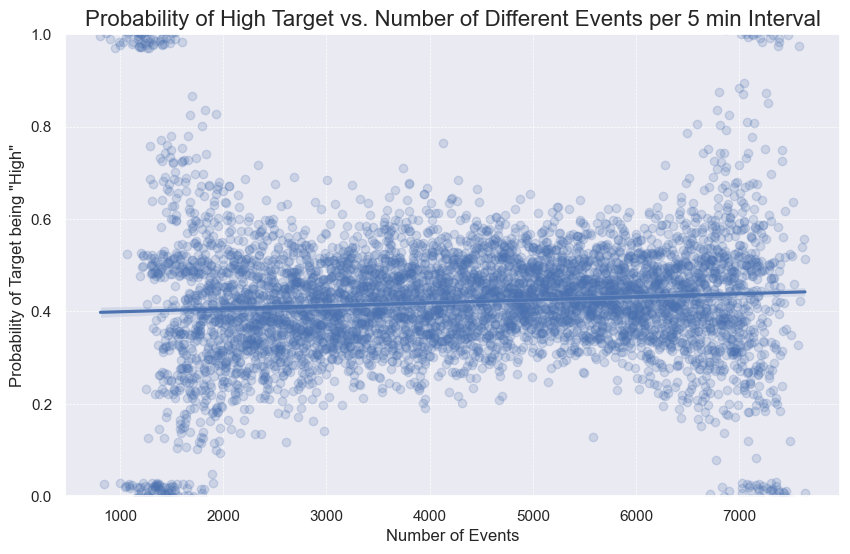

In [297]:
df_stat_nb_event = pd.concat([df_combined_condition.sum(axis=1), list_df[0]["target_cat"] == "high"], axis=1)
df_stat_nb_event.rename(columns={0: "nb_event"}, inplace=True)
# 1. Calculate the probability for each number of events
prob_df = df_stat_nb_event.groupby('nb_event')['target_cat'].mean().reset_index()
prob_df.rename(columns={'target_cat': 'probability_high'}, inplace=True)

""" # --- Seaborn Visualization ---
plt.figure(figsize=(12, 7))

# 2. Create the bar plot from the aggregated data
sns.scatterplot(x='nb_event', y='probability_high', data=prob_df, palette='viridis')

# --- Formatting the Plot ---
plt.title('Probability of High Target vs. Number of Concurrent Events', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show() """

plt.figure(figsize=(10, 6))

# Use regplot with logistic=True to fit and plot a logistic regression model.
# y_jitter adds a small amount of vertical noise to the points for better visibility.
sns.regplot(x='nb_event', y='probability_high', data=prob_df,
            ci=95, # Show 95% confidence interval
            y_jitter=.03, # Add jitter to see density of points at 0 and 1
            scatter_kws={'alpha': 0.2}) # Make scatter points transparent

# --- Formatting the Plot ---
plt.title('Probability of High Target vs. Number of Different Events per 5 min Interval', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1) # Give a little space around the 0 and 1 lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

=>
- Mean probability is increasing with number of different event per 5 min interval
- With a selection of Events with p_min = 0.4, we increase the mean prob by 0.03 (+3%) 

In [298]:
prob_df

nb_event  probability_high
0          812          1.000000
1          843          0.000000
2          866          1.000000
3          897          0.000000
4          905          1.000000
...        ...               ...
6100      7582          0.428571
6101      7610          0.545455
6102      7628          0.571429
6103      7632          0.000000
6104      7634          0.533333

[6105 rows x 2 columns]

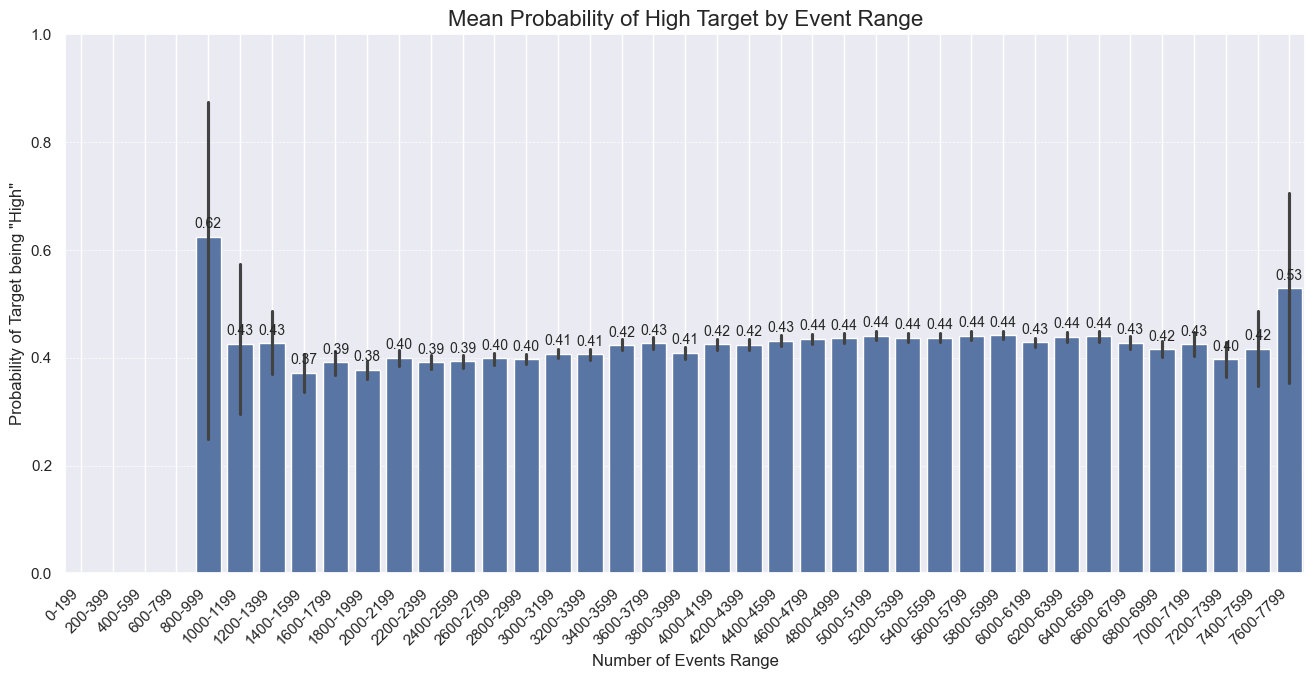

In [299]:
# 1. Define the bins for the number of events.
# We'll create bins of size 500, from 0 up to the maximum value.
max_events = df_stat_nb_event['nb_event'].max()
# Create bins like [0, 500, 1000, 1500, ...]
bins = np.arange(0, max_events + 200, 200)
# Create clear labels for the plot, like '0-499', '500-999', etc.
labels = [f'{int(bins[i])}-{int(bins[i+1]-1)}' for i in range(len(bins)-1)]


# 2. Use pandas.cut to segment the 'nb_event' column into these ranges.
df_stat_nb_event['event_range'] = pd.cut(df_stat_nb_event['nb_event'],
                                         bins=bins,
                                         labels=labels,
                                         right=False, # Makes intervals [0, 500), [500, 1000), etc.
                                         include_lowest=True) # Ensures 0 is included in the first bin

plt.figure(figsize=(16, 7))
ax = sns.barplot(data=df_stat_nb_event, y="target_cat", x="event_range")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10,
                xytext=(0, 9),
                textcoords='offset points')
# --- Formatting the Plot ---
plt.title('Mean Probability of High Target by Event Range', fontsize=16)
plt.xlabel('Number of Events Range', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.tight_layout() # Adjust plot to make sure labels don't get cut off
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.grid(True, 'both')
plt.show()

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/2345260547.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


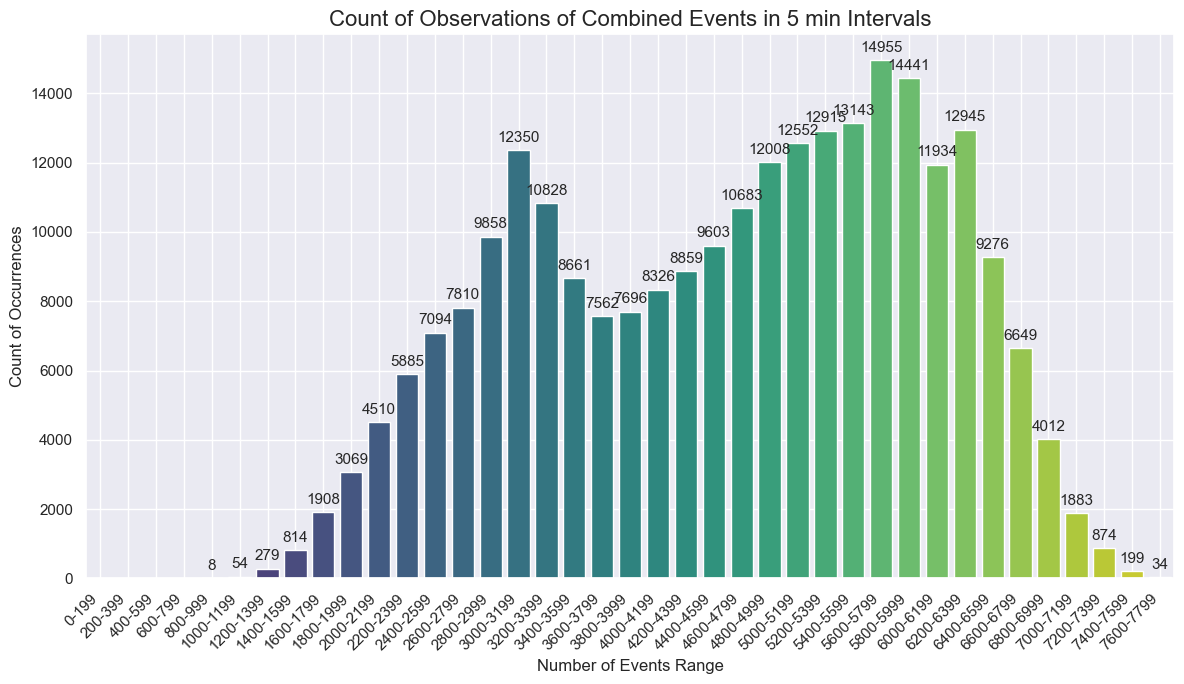

In [300]:
# --- Create the bar plot using seaborn.countplot ---
plt.figure(figsize=(12, 7))

# sns.countplot is the ideal function for this task.
# We use order to ensure the ranges are plotted in numerical order.
ax = sns.countplot(
    x='event_range',
    data=df_stat_nb_event,
    palette='viridis',
    order=labels # Use the generated labels to ensure correct sorting
)

# --- Add count labels on top of each bar for clarity ---
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=11,
                xytext=(0, 9),
                textcoords='offset points')

# --- Formatting the Plot ---
plt.title('Count of Observations of Combined Events in 5 min Intervals', fontsize=16)
plt.xlabel('Number of Events Range', fontsize=12)
plt.ylabel('Count of Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
ax.grid(True, 'both')
plt.show()

with : nb_event_min = 8000 & prob_min = 0.4:
- Low or high number of events in time range of 5 min is very low represented so not useful : prob to happened is low
- Most represented : Around 5600-5800 events lead to 40+4% proba = 44% to be high

In [301]:
df_stat_nb_event

nb_event  target_cat event_range
date_ETH                                             
2023-01-01 00:00:00      2944       False   2800-2999
2023-01-01 00:05:00      2562       False   2400-2599
2023-01-01 00:10:00      2520       False   2400-2599
2023-01-01 00:15:00      4021       False   4000-4199
2023-01-01 00:20:00      2678       False   2600-2799
...                       ...         ...         ...
2025-05-30 19:15:00      5669        True   5600-5799
2025-05-30 19:20:00      5883       False   5800-5999
2025-05-30 19:25:00      4577       False   4400-4599
2025-05-30 19:30:00      5384       False   5200-5399
2025-05-30 19:35:00      5923        True   5800-5999

[253677 rows x 3 columns]

In [302]:
list_local_features = df_combined_condition.loc[
    df_stat_nb_event[
        (df_stat_nb_event["event_range"] == "800-999") &
        (df_stat_nb_event["target_cat"] == True)
    ].index.values
].sum(axis=0).sort_values(ascending=False).head(20)
print(list_local_features)
event_0 = list_local_features.index[0]

print(f"\nevent : {event_0}")
print(df_prob_comb_high_event.loc[event_0])
print('prob to appear : ', df_combined_condition[event_0].sum(axis=0) / df_combined_condition.shape[0])
print("nb events :", df_combined_condition[event_0].sum(axis=0))

event_1 = list_local_features.index[1]
print(f"\nevent : {event_1}")
print(df_prob_comb_high_event.loc[event_1])
print('prob to appear : ', df_combined_condition[event_1].sum(axis=0) / df_combined_condition.shape[0])
print("nb events :", df_combined_condition[event_1].sum(axis=0))

86548     5
57253     5
84496     5
58711     5
84469     5
58684     5
157077    5
202918    5
57415     5
95863     5
57388     5
111107    5
55147     4
203134    4
203161    4
36301     4
85063     4
203053    4
64948     4
143505    4
dtype: int64

event : 86548
high                                      9724
low                                      11940
neutral                                   2395
p_high                                0.404173
p_low                                  0.49628
delta_prob                          -453.34712
feat_0                     ichi_tenkan_ETH_cat
feat_0_cat                                 low
lag_0                                       68
feat_1                          vwap_h_ETH_cat
feat_1_cat                                 low
lag_1                                       70
feat_2                     ichi_tenkan_ETH_cat
feat_2_cat                                 low
lag_2                                       70
days_with_event            

In [303]:
list_local_features.index.values

array([ 86548,  57253,  84496,  58711,  84469,  58684, 157077, 202918,
        57415,  95863,  57388, 111107,  55147, 203134, 203161,  36301,
        85063, 203053,  64948, 143505])

In [304]:
df_prob_comb_high_event.shape

(27660, 21)

In [305]:
df_prob_comb_high_event.loc[list_local_features.index.values].T

86548                57253   \
high                                    9724                 8829   
low                                    11940                10175   
neutral                                 2395                 1897   
p_high                              0.404173              0.42242   
p_low                                0.49628             0.486819   
delta_prob                        -453.34712          -190.666807   
feat_0                   ichi_tenkan_ETH_cat    min_low_h_ETH_cat   
feat_0_cat                               low                  low   
lag_0                                     68                   64   
feat_1                        vwap_h_ETH_cat  ichi_tenkan_ETH_cat   
feat_1_cat                               low                  low   
lag_1                                     70                   68   
feat_2                   ichi_tenkan_ETH_cat    min_low_h_ETH_cat   
feat_2_cat                               low                  low   
lag_2                                     70                   68   
days_with_event                          849                  754   
weeks_with_event                         127                  126   
months_with_event                         29                   29   
ratio_days_with_event               0.963678             0.855846   
ratio_weeks_with_event                   1.0             0.992126   
ratio_months_with_event                  1.0                  1.0   

                                      84496              58711   \
high                                    8082               8164   
low                                     9409               9578   
neutral                                 1727               1769   
p_high                              0.420543           0.418431   
p_low                               0.489593           0.490903   
delta_prob                       -201.352581        -225.385639   
feat_0                   ichi_tenkan_ETH_cat  min_low_h_ETH_cat   
feat_0_cat                               low                low   
lag_0                                     68                 64   
feat_1                     min_low_h_ETH_cat  min_low_h_ETH_cat   
feat_1_cat                               low                low   
lag_1                                     68                 68   
feat_2                        vwap_h_ETH_cat     vwap_h_ETH_cat   
feat_2_cat                               low                low   
lag_2                                     70                 70   
days_with_event                          754                753   
weeks_with_event                         126                126   
months_with_event                         29                 29   
ratio_days_with_event               0.855846           0.854711   
ratio_weeks_with_event              0.992126           0.992126   
ratio_months_with_event                  1.0                1.0   

                                      84469              58684   \
high                                    8812              10534   
low                                     9973              11788   
neutral                                 1834               2235   
p_high                              0.427373           0.428961   
p_low                                0.48368           0.480026   
delta_prob                       -143.510354        -140.893827   
feat_0                   ichi_tenkan_ETH_cat  min_low_h_ETH_cat   
feat_0_cat                               low                low   
lag_0                                     68                 64   
feat_1                     min_low_h_ETH_cat  min_low_h_ETH_cat   
feat_1_cat                               low                low   
lag_1                                     68                 68   
feat_2                     min_low_h_ETH_cat  min_low_h_ETH_cat   
feat_2_cat                               low                low   
lag_2                                  

In [306]:

df_prob_comb_high_event.loc[86548 ]

high                                      9724
low                                      11940
neutral                                   2395
p_high                                0.404173
p_low                                  0.49628
delta_prob                          -453.34712
feat_0                     ichi_tenkan_ETH_cat
feat_0_cat                                 low
lag_0                                       68
feat_1                          vwap_h_ETH_cat
feat_1_cat                                 low
lag_1                                       70
feat_2                     ichi_tenkan_ETH_cat
feat_2_cat                                 low
lag_2                                       70
days_with_event                            849
weeks_with_event                           127
months_with_event                           29
ratio_days_with_event                 0.963678
ratio_weeks_with_event                     1.0
ratio_months_with_event                    1.0
Name: 86548, 

In [307]:
df_combined_condition[86548].sum(axis=0) / df_combined_condition.shape[0]

np.float64(0.09484107743311376)

In [308]:
df_combined_condition[86548].sum(axis=0)

np.int64(24059)

### Per Day

In [309]:
global_event_by_day.describe()

count    881.000000
mean     287.942111
std        1.752287
min      236.000000
25%      288.000000
50%      288.000000
75%      288.000000
max      289.000000
dtype: float64

In [310]:
global_event_by_day.index.max()

Timestamp('2025-05-30 00:00:00')

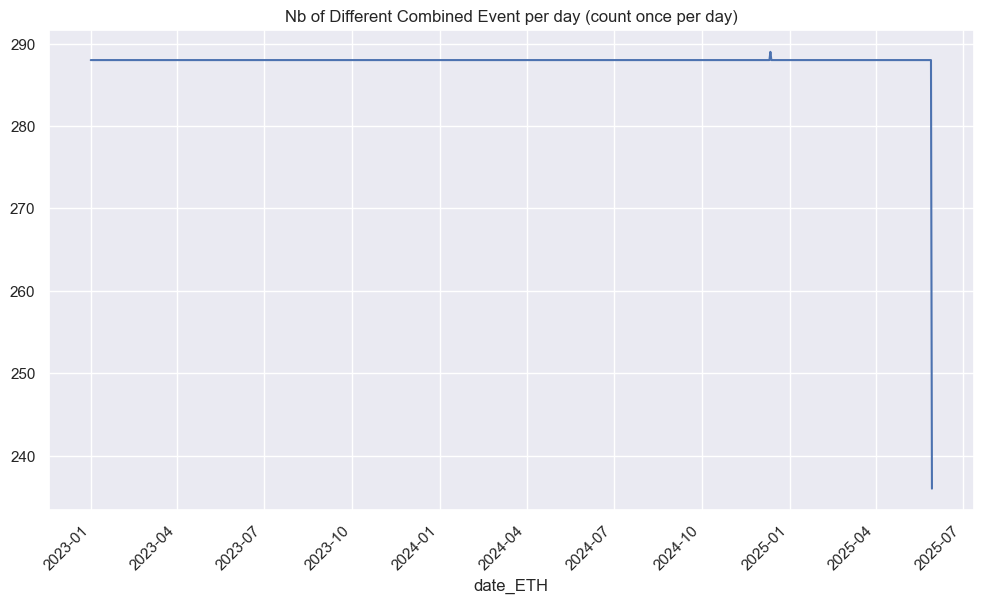

In [311]:
fig = plt.figure(figsize=(10, 6))

sns.lineplot(global_event_by_day, markers="o")
# change x axis ticker format at 45°
# Rotate the x-axis tick labels to 45 degrees.
# Using ha='right' aligns the end of the label with the tick, which often looks better.
plt.xticks(rotation=45, ha='right')

# Adjust plot to make sure labels don't get cut off
plt.tight_layout()

# title
plt.title("Nb of Different Combined Event per day (count once per day)")
# Display the plot
plt.show()

Text(0.5, 1.0, 'Distribution of Number of Events per Day')

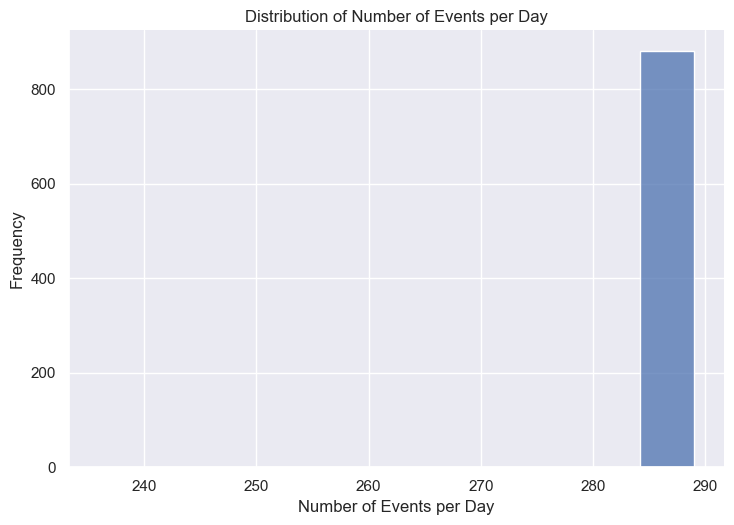

In [312]:

sns.displot(global_event_by_day, height=5, aspect=1.5)
fig = plt.gcf()
ax = fig.gca()
ax.set_xlabel("Number of Events per Day")
ax.set_ylabel("Frequency")
plt.title("Distribution of Number of Events per Day")

In [313]:
df_prob_comb_high_event

high    low  neutral    p_high     p_low  delta_prob  \
0       20487  16340     4502  0.495705  0.395364  933.967415   
13      16950  20295     4940  0.401802  0.481095 -600.833669   
20      21301  19625     9959  0.418611  0.385674  137.270977   
23      13680  13893     5343  0.415603  0.422074   -3.290828   
27      17019  13459     3819  0.496224  0.392425  831.655620   
...       ...    ...      ...       ...       ...         ...   
219202  13880  15828     4853  0.401609  0.457973 -255.466810   
219212  33440  31363    15247  0.417739  0.391793  133.139793   
219237  20915  17521     5701  0.473865  0.396969  599.398272   
219238  15856  17865     5395  0.405358  0.456718 -239.380861   
219239  49297  47518    22586  0.412869  0.397970   65.379146   

                    feat_0 feat_0_cat  lag_0              feat_1  ... lag_1  \
0           vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
13          vwap_h_ETH_cat        low     64         Low_ETH_cat  ...    56   
20          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
23          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
27          vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
...                    ...        ...    ...                 ...  ...   ...   
219202        High_ETH_cat        low     68  max_high_d_ETH_cat  ...    70   
219212        High_ETH_cat    neutral     68  max_high_d_ETH_cat  ...    70   
219237  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219238  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219239  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   

                     feat_2 feat_2_cat lag_2  days_with_event  \
0       ichi_tenkan_ETH_cat       high    64              875   
13      ichi_tenkan_ETH_cat        low    64              870   
20      ichi_tenkan_ETH_cat    neutral    64              881   
23      ichi_tenkan_ETH_cat    neutral    64              880   
27        min_low_h_ETH_cat       high    56              873   
...                     ...        ...   ...              ...   
219202         Open_ETH_cat        low    68              868   
219212         Open_ETH_cat    neutral    68              874   
219237         Open_ETH_cat       high    68              872   
219238         Open_ETH_cat        low    68              868   
219239         Open_ETH_cat    neutral    68              875   

        weeks_with_event  months_with_event  ratio_days_with_event  \
0                    127                 29               0.993190   
13                   127                 29               0.987514   
20                   127                 29               1.000000   
23                   127                 29               0.998865   
27                   127                 29               0.990919   
...                  ...                ...                    ...   
219202               127                 29               0.985244   
219212               127                 29               0.992054   
219237               127                 29               0.989784   
219238               127                 29               0.985244   
219239               127                 29               0.993190   

        ratio_weeks_with_event  ratio_months_with_event  
0                          1.0                      1.0  
13                         1.0                      1.0  
20                         1.0                      1.0  
23                         1.0                      1.0  
27                         1.0                      1.0  
...                        ...                      ...  
219202                     1.0                      1.0  
219212                     1.0                      1.0  
219237                     1.0                      1.0  
219238                     1.0                      1.0  
219239             

In [314]:
list_df[0]

Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   
2023-01-01 00:10:00        1.0  1.000084  1.000193  0.999841   
2023-01-01 00:15:00        1.0  1.000770  1.000770  0.999900   
2023-01-01 00:20:00        1.0  0.999330  1.000025  0.999330   
...                        ...       ...       ...       ...   
2025-05-30 19:15:00        1.0  0.998258  1.001698  0.997009   
2025-05-30 19:20:00        1.0  0.998554  1.001387  0.998451   
2025-05-30 19:25:00        1.0  1.004900  1.005056  0.999299   
2025-05-30 19:30:00        1.0  1.001168  1.001491  0.997621   
2025-05-30 19:35:00        1.0  1.012121  1.014171  0.998487   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   
2023-01-01 00:10:00          0.998860          0.999351        0.998243   
2023-01-01 00:15:00          0.999669          1.000113        0.999003   
2023-01-01 00:20:00          0.999178          0.999443        0.998335   
...                               ...               ...             ...   
2025-05-30 19:15:00          1.009059          1.012239        1.000323   
2025-05-30 19:20:00          1.006895          1.010775        0.998877   
2025-05-30 19:25:00          1.011829          1.015728        1.003772   
2025-05-30 19:30:00          1.011492          1.015731        1.004944   
2025-05-30 19:35:00          1.023400          1.028043        1.011526   

                     ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
date_ETH                                                     
2023-01-01 00:00:00         0.999464              2.024261   
2023-01-01 00:05:00         0.999184              2.023329   
2023-01-01 00:10:00         0.999477              2.023482   
2023-01-01 00:15:00         1.000239              2.025023   
2023-01-01 00:20:00         0.999569              2.023668   
...                              ...                   ...   
2025-05-30 19:15:00         1.000559              1.043299   
2025-05-30 19:20:00         0.999113              1.041791   
2025-05-30 19:25:00         1.004009              1.046896   
2025-05-30 19:30:00         1.003987              1.048118   
2025-05-30 19:35:00         1.009147              1.060823   

                     ichi_cloud_b_day_ETH  ...  hour_cos_cat  hour_sin_cat  \
date_ETH                                   ...                               
2023-01-01 00:00:00              2.017807  ...       neutral          high   
2023-01-01 00:05:00              2.016878  ...       neutral          high   
2023-01-01 00:10:00              2.017030  ...       neutral          high   
2023-01-01 00:15:00              2.018567  ...       neutral          high   
2023-01-01 00:20:00              2.017215  ...       neutral          high   
...                                   ...  ...           ...           ...   
2025-05-30 19:15:00              1.026564  ...          high       neutral   
2025-05-30 19:20:00              1.025079  ...          high       neutral   
2025-05-30 19:25:00              1.030103  ...          high       neutral   
2025-05-30 19:30:00              1.031306  ...          high       neutral   
2025-05-30 19:35:00              1.043807  ...          high       neutral   

                     weekday_cos_cat  weekday_sin_cat  day_in_month_cos_cat  \
date_ETH                                                                      
2023-01-01 00:00:00          neutral          neutral                  high   
2023-01-01 00:05:00          neutral          neutral                  high   
2023-01-01 00:10:00          neutral          neutral                  hig

In [315]:
df_combined_condition

0       13      20      23      27      40      45      \
date_ETH                                                                      
2023-01-01 00:00:00   False   False   False   False   False   False   False   
2023-01-01 00:05:00   False   False   False   False   False   False   False   
2023-01-01 00:10:00   False   False   False   False   False   False   False   
2023-01-01 00:15:00   False   False   False   False   False   False   False   
2023-01-01 00:20:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False    True   False   False   False   False   
2025-05-30 19:20:00   False   False    True   False   False   False   False   
2025-05-30 19:25:00    True   False   False   False   False   False   False   
2025-05-30 19:30:00    True   False   False   False   False   False   False   
2025-05-30 19:35:00    True   False   False   False    True   False   False   

                     47      50      54      ...  219158  219165  219175  \
date_ETH                                     ...                           
2023-01-01 00:00:00   False   False   False  ...   False   False   False   
2023-01-01 00:05:00   False   False   False  ...   False   False   False   
2023-01-01 00:10:00   False   False   False  ...   False   False   False   
2023-01-01 00:15:00   False   False   False  ...    True   False   False   
2023-01-01 00:20:00   False   False   False  ...    True   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00    True   False   False  ...   False   False   False   
2025-05-30 19:20:00    True   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False    True  ...   False   False   False   
2025-05-30 19:30:00   False   False    True  ...   False   False   False   
2025-05-30 19:35:00   False   False    True  ...   False   False   False   

                     219185  219192  219202  219212  219237  219238  219239  
date_ETH                                                                     
2023-01-01 00:00:00   False   False   False   False   False   False    True  
2023-01-01 00:05:00   False   False   False   False   False   False    True  
2023-01-01 00:10:00   False   False   False   False   False   False    True  
2023-01-01 00:15:00    True   False   False    True   False   False    True  
2023-01-01 00:20:00    True   False   False    True   False   False    True  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[253677 rows x 27660 columns]

In [316]:
df_prob_comb_high_event.sort_values(by=["p_high"], ascending=False).head(20)

high   low  neutral    p_high     p_low  delta_prob  \
103194  8067  6070     1260  0.523933  0.394233  564.194525   
100035  8262  6200     1321  0.523475  0.392828  588.002213   
210519  8594  6501     1356  0.522400  0.395174  580.410600   
196209  8796  6635     1411  0.522266  0.393956  605.264856   
210438  8980  6837     1381  0.522154  0.397546  580.697857   
102519  8725  6586     1402  0.522049  0.394065  597.651492   
108999  8641  6600     1313  0.521989  0.398695  546.641428   
216594  8540  6521     1301  0.521941  0.398545  541.313459   
102573  8245  6248     1304  0.521935  0.395518  550.335886   
196128  9181  6978     1435  0.521826  0.396612  600.681849   
92637   8063  6082     1311  0.521674  0.393504  554.876069   
216675  8147  6198     1274  0.521608  0.396824  529.606274   
99846   8902  6706     1462  0.521500  0.392853  617.941568   
103221  8521  6388     1434  0.521385  0.390871  610.327856   
109431  8161  6268     1224  0.521370  0.400434  496.700949   
212301  8568  6486     1386  0.521168  0.394526  575.889996   
108729  8743  6693     1345  0.521006  0.398844  544.506349   
45603   8527  6430     1410  0.520987  0.392864  588.006820   
85671   8415  6376     1362  0.520956  0.394725  562.169022   
209763  9301  7121     1432  0.520948  0.398846  578.784557   

                     feat_0 feat_0_cat  lag_0               feat_1  ... lag_1  \
103194          Low_ETH_cat       high     68       vwap_d_ETH_cat  ...    70   
100035       vwap_d_ETH_cat       high     68          Low_ETH_cat  ...    68   
210519       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
196209       vwap_d_ETH_cat       high     68  ichi_tenkan_ETH_cat  ...    70   
210438       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
102519          Low_ETH_cat       high     68       vwap_h_ETH_cat  ...    70   
108999       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
216594  ichi_tenkan_ETH_cat       high     70       vwap_d_ETH_cat  ...    71   
102573          Low_ETH_cat       high     68       vwap_h_ETH_cat  ...    70   
196128       vwap_d_ETH_cat       high     68  ichi_tenkan_ETH_cat  ...    70   
92637        vwap_d_ETH_cat       high     64          Low_ETH_cat  ...    68   
216675  ichi_tenkan_ETH_cat       high     70       vwap_d_ETH_cat  ...    71   
99846        vwap_d_ETH_cat       high     68          Low_ETH_cat  ...    68   
103221          Low_ETH_cat       high     68       vwap_d_ETH_cat  ...    70   
109431       vwap_d_ETH_cat       high     71  ichi_tenkan_ETH_cat  ...    70   
212301       vwap_d_ETH_cat       high     64  ichi_tenkan_ETH_cat  ...    70   
108729       vwap_d_ETH_cat       high     70   ichi_kijun_ETH_cat  ...    64   
45603        vwap_h_ETH_cat       high     56          Low_ETH_cat  ...    68   
85671   ichi_tenkan_ETH_cat       high     68          Low_ETH_cat  ...    68   
209763       vwap_d_ETH_cat       high     70       vwap_h_ETH_cat  ...    56   

                     feat_2 feat_2_cat lag_2  days_with_event  \
103194  ichi_tenkan_ETH_cat       high    70              845   
100035  ichi_tenkan_ETH_cat       high    70              849   
210519         Open_ETH_cat       high    68              845   
196209         Open_ETH_cat       high    68              847   
210438         High_ETH_cat       high    68              842   
102519       vwap_d_ETH_cat       high    70              848   
108999         High_ETH_cat       high    40              830   
216594         High_ETH_cat       high    68              818   
102573       vwap_d_ETH_cat       high    71              820   
196128         High_ETH_cat       high    68              847   
92637   ichi_tenkan_ETH_cat       high    70              854   
216675         Open_ETH_cat       high    68              817   
99846        vwap_h_ETH_cat       high    70              855   
103221         High_ETH_cat       high    40              838   
109431 

In [317]:
df_prob_comb_high_event.high.describe()

count    27660.000000
mean     18151.096132
std      13377.857994
min       8001.000000
25%       9850.750000
50%      12554.500000
75%      19697.000000
max      77341.000000
Name: high, dtype: float64

### Find ML model to improve prob

#### RandomForest : all data

In [318]:
df_combined_condition

0       13      20      23      27      40      45      \
date_ETH                                                                      
2023-01-01 00:00:00   False   False   False   False   False   False   False   
2023-01-01 00:05:00   False   False   False   False   False   False   False   
2023-01-01 00:10:00   False   False   False   False   False   False   False   
2023-01-01 00:15:00   False   False   False   False   False   False   False   
2023-01-01 00:20:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False    True   False   False   False   False   
2025-05-30 19:20:00   False   False    True   False   False   False   False   
2025-05-30 19:25:00    True   False   False   False   False   False   False   
2025-05-30 19:30:00    True   False   False   False   False   False   False   
2025-05-30 19:35:00    True   False   False   False    True   False   False   

                     47      50      54      ...  219158  219165  219175  \
date_ETH                                     ...                           
2023-01-01 00:00:00   False   False   False  ...   False   False   False   
2023-01-01 00:05:00   False   False   False  ...   False   False   False   
2023-01-01 00:10:00   False   False   False  ...   False   False   False   
2023-01-01 00:15:00   False   False   False  ...    True   False   False   
2023-01-01 00:20:00   False   False   False  ...    True   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00    True   False   False  ...   False   False   False   
2025-05-30 19:20:00    True   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False    True  ...   False   False   False   
2025-05-30 19:30:00   False   False    True  ...   False   False   False   
2025-05-30 19:35:00   False   False    True  ...   False   False   False   

                     219185  219192  219202  219212  219237  219238  219239  
date_ETH                                                                     
2023-01-01 00:00:00   False   False   False   False   False   False    True  
2023-01-01 00:05:00   False   False   False   False   False   False    True  
2023-01-01 00:10:00   False   False   False   False   False   False    True  
2023-01-01 00:15:00    True   False   False    True   False   False    True  
2023-01-01 00:20:00    True   False   False    True   False   False    True  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[253677 rows x 27660 columns]


Loading model from data/rf_prob_model.joblib...
Model loaded successfully.

Feature Importances (most predictive individual events):
172719    3.309822e-03
218637    3.179752e-03
74763     3.060951e-03
157077    2.903768e-03
218636    1.062286e-03
              ...     
178775   -8.104243e-21
28134    -1.020454e-20
171230   -1.395575e-20
159084   -1.858750e-20
58887    -2.609037e-20
Length: 27660, dtype: float64


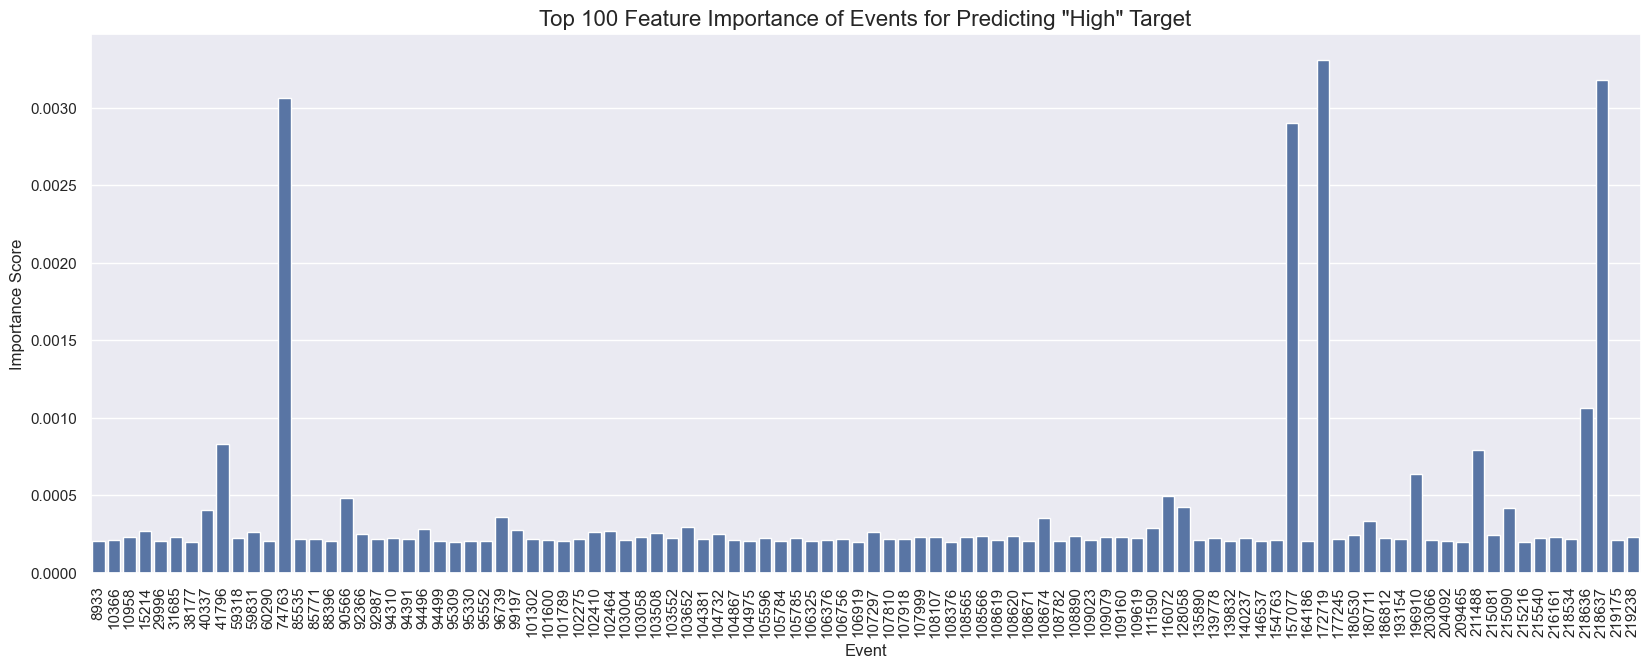

In [319]:
from sklearn.ensemble import RandomForestClassifier
model_rf_prob_filename = os.path.join(path_data, 'rf_prob_model.joblib')
mode_rf = False
y_comb = (list_df[0]["target_cat"] == "high")
if mode_rf:
    # VERY SLOW Training Time with 2 Estimators = 100 min ! 
    # 1. Prepare the data for modeling
    #X_comb = df_combined_condition
    
    # 2. Use a Random Forest to find important features
    print("--- Finding Important Events with Random Forest ---")
    # class_weight='balanced' is useful if "high" targets are rare
    rf_model = RandomForestClassifier(n_estimators=2, random_state=42, class_weight='balanced')
    rf_model.fit(df_combined_condition, y_comb)
    # 2. Save the model to a file
    
    print(f"\nSaving model to {model_rf_prob_filename}...")
    joblib.dump(rf_model, model_rf_prob_filename)
    print("Model saved successfully.")
else:
    # 3. Load the model from the file
    # This can be done in a different script or a later session.
    print(f"\nLoading model from {model_rf_prob_filename}...")
    rf_model = joblib.load(model_rf_prob_filename)
    print("Model loaded successfully.")
# Get and plot feature importances
importances = pd.Series(rf_model.feature_importances_, index=df_combined_condition.columns).sort_values(ascending=False)
print("\nFeature Importances (most predictive individual events):")
print(importances)
# Plot the importances of the top 100 features
plt.figure(figsize=(20, 7))
sns.barplot(y=importances.head(100).values, x=importances.head(100).index)
plt.title('Top 100 Feature Importance of Events for Predicting "High" Target', fontsize=16)
plt.ylabel('Importance Score', fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.show()

In [320]:
importances.head(10)

172719    0.003310
218637    0.003180
74763     0.003061
157077    0.002904
218636    0.001062
41796     0.000830
211488    0.000791
196910    0.000637
116072    0.000496
90566     0.000481
dtype: float64

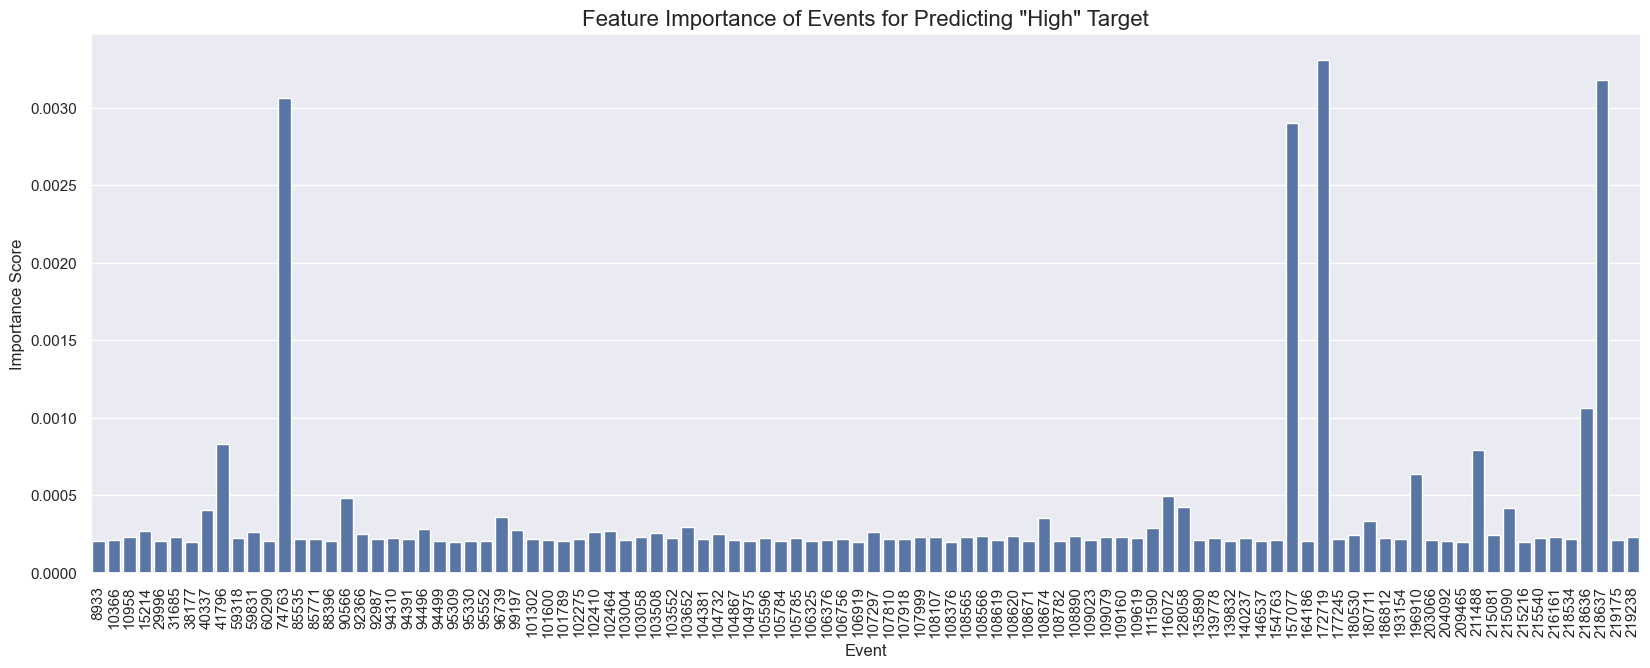

In [321]:
plt.figure(figsize=(20, 7))
sns.barplot(y=importances.head(100).values, x=importances.head(100).index)
plt.title('Feature Importance of Events for Predicting "High" Target', fontsize=16)
plt.ylabel('Importance Score', fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.show()

In [322]:
importances.head(100).index

Index([172719, 218637,  74763, 157077, 218636,  41796, 211488, 196910, 116072,
        90566, 128058, 215090,  40337,  96739, 108674, 180711, 103652, 111590,
        94496,  99197, 102464,  15214, 107297,  59831, 102410, 103508, 104732,
        92366, 215081, 180530, 108620, 108566, 108890, 109160, 216161, 108107,
       219238, 108565,  31685,  10958, 107999, 109079, 103058, 109619, 105785,
       105596,  94310,  59318, 103552, 215540, 140237, 186812, 139778,  85771,
       107918,  85535,  92987, 177245, 106756, 107810, 102275, 104381, 101302,
       193154, 218534,  94391, 106376, 203066, 135890, 154763, 104867, 101600,
       219175, 108619, 103004, 109023,  10366, 101789, 146537, 204092, 106325,
        95552,   8933,  88396,  94499,  60290, 104975, 108671, 105784,  95330,
       139832, 164186,  29996, 108782, 209465, 106919, 215216, 108376,  38177,
        95309],
      dtype='int64')

In [323]:
importances

172719    3.309822e-03
218637    3.179752e-03
74763     3.060951e-03
157077    2.903768e-03
218636    1.062286e-03
              ...     
178775   -8.104243e-21
28134    -1.020454e-20
171230   -1.395575e-20
159084   -1.858750e-20
58887    -2.609037e-20
Length: 27660, dtype: float64

In [324]:
df_prob_comb_high_event.loc[importances.head(4).index.values].T

172719              218637  \
high                                   25516                8847   
low                                    20753                8192   
neutral                                 6277                1921   
p_high                              0.485594            0.466614   
p_low                               0.394949            0.432068   
delta_prob                        980.620675           50.358002   
feat_0                   ichi_tenkan_ETH_cat       rsi_h_BTC_cat   
feat_0_cat                              high             neutral   
lag_0                                     56                  71   
feat_1                          Open_ETH_cat  max_high_d_ETH_cat   
feat_1_cat                              high                high   
lag_1                                     56                  71   
feat_2                        vwap_h_ETH_cat  max_high_d_ETH_cat   
feat_2_cat                              high                high   
lag_2                                     56                  70   
days_with_event                          877                 232   
weeks_with_event                         127                  86   
months_with_event                         29                  29   
ratio_days_with_event                0.99546            0.263337   
ratio_weeks_with_event                   1.0            0.677165   
ratio_months_with_event                  1.0                 1.0   

                                 74763               157077  
high                              16843                8809  
low                               13316                8184  
neutral                            3390                1944  
p_high                         0.502042            0.465174  
p_low                          0.396912             0.43217  
delta_prob                   824.943068           45.974813  
feat_0                     Open_ETH_cat       rsi_h_ETH_cat  
feat_0_cat                         high             neutral  
lag_0                                64                  71  
feat_1                     High_ETH_cat  max_high_d_ETH_cat  
feat_1_cat                         high                high  
lag_1                                64                  71  
feat_2                   vwap_h_ETH_cat  max_high_d_ETH_cat  
feat_2_cat                         high                high  
lag_2                                68                  70  
days_with_event                     872                 231  
weeks_with_event                    127                  85  
months_with_event                    29                  29  
ratio_days_with_event          0.989784            0.262202  
ratio_weeks_with_event              1.0            0.669291  
ratio_months_with_event             1.0                 1.0

In [325]:
rf_model.score(df_combined_condition, y_comb)

0.7282843931456143

=> Probably Overfitting


--- Visualizing Event Combinations with a Decision Tree ---


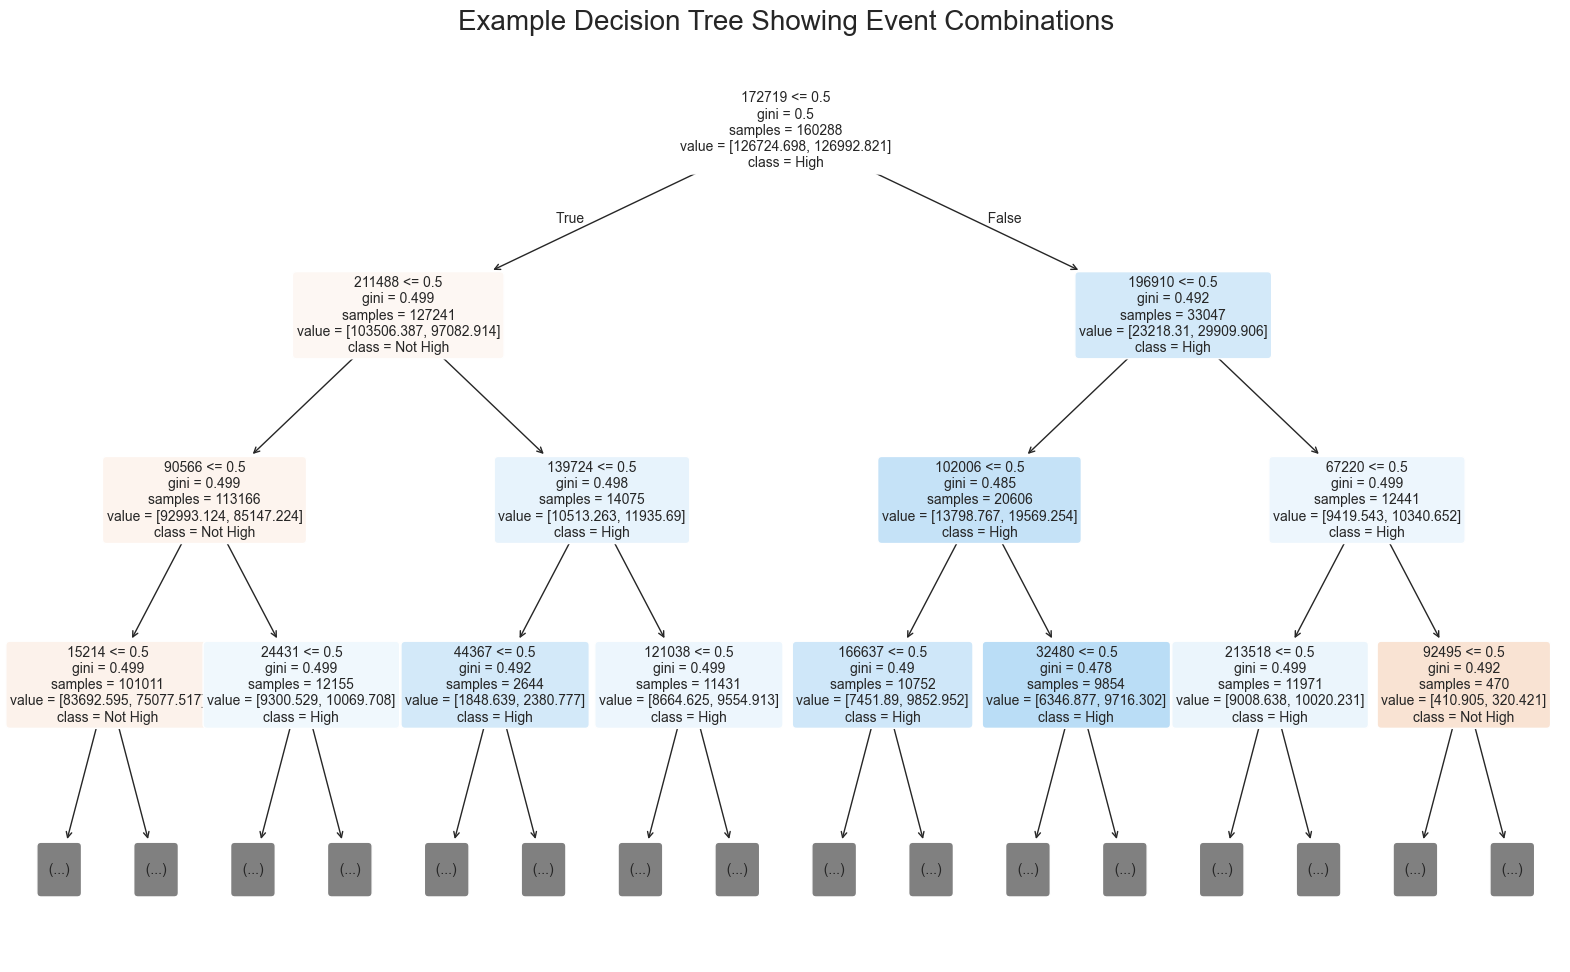

In [326]:
from sklearn.tree import plot_tree
# 3. Visualize a Decision Tree to see the combinations
print("\n--- Visualizing Event Combinations with a Decision Tree ---")
# Let's pick one tree from our trained forest (e.g., the 5th one)
single_tree = rf_model.estimators_[0]

plt.figure(figsize=(20, 12))
plot_tree(single_tree,
          feature_names=df_combined_condition.columns,
          class_names=['Not High', 'High'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3) # Limit depth for better readability
plt.title("Example Decision Tree Showing Event Combinations", fontsize=20)
plt.show()

#### RandomForest : train / test 

In [327]:
# train split 
# It's good practice to split data to evaluate the model
from sklearn.model_selection import train_test_split
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    df_combined_condition,
    y_comb,
    test_size=0.3,
    shuffle=False
)

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    max_features="sqrt", # "sqrt", # default
    max_samples=0.6,
    min_samples_leaf=100,
    n_estimators=10,
    max_depth=4,
)
rf.fit(X_rf_train, y_rf_train)
print("Model trained.")
print("Accuracy on training data:", rf.score(X_rf_train, y_rf_train))
print("Accuracy on test data:", rf.score(X_rf_test, y_rf_test))

# max_features="sqrt", max_samples=0.6
# accuracy Train / Test
# 58/56 : 27s : min_samples_leaf=1000,n_estimators=10 ,max_depth=2,
# 58/56 : 30s : min_samples_leaf=1000,n_estimators=100,max_depth=2,
# 58/56 : 35s : min_samples_leaf=1000,n_estimators=100,max_depth=3,
# 58/56 : 30s : min_samples_leaf=1000,n_estimators=30 ,max_depth=3,
# 58/56 : 28s : min_samples_leaf=1000,n_estimators=30 ,max_depth=3, max_samples=0.8,
# 58/56+: 29s : min_samples_leaf=100 ,n_estimators=30 ,max_depth=3, max_samples=0.6,
# 59/56+: 33s : min_samples_leaf=100 ,n_estimators=30 ,max_depth=4,
# 59/56+: 44s : min_samples_leaf=100 ,n_estimators=100,max_depth=4,
# 59/56+: 29s : min_samples_leaf=100 ,n_estimators=10 ,max_depth=4,
# 59/56-: 31s : min_samples_leaf=100 ,n_estimators=10 ,max_depth=5,
# 59/56-: 31s : min_samples_leaf=10 ,n_estimators=10  ,max_depth=5,
# 59/56:9m29s : min_samples_leaf=3  ,n_estimators=300 ,max_depth=7, max_features=300, max_samples=0.8,

Model trained.
Accuracy on training data: 0.5872289143056658
Accuracy on test data: 0.5603384841795438



--- Visualizing Event Combinations with a Decision Tree ---


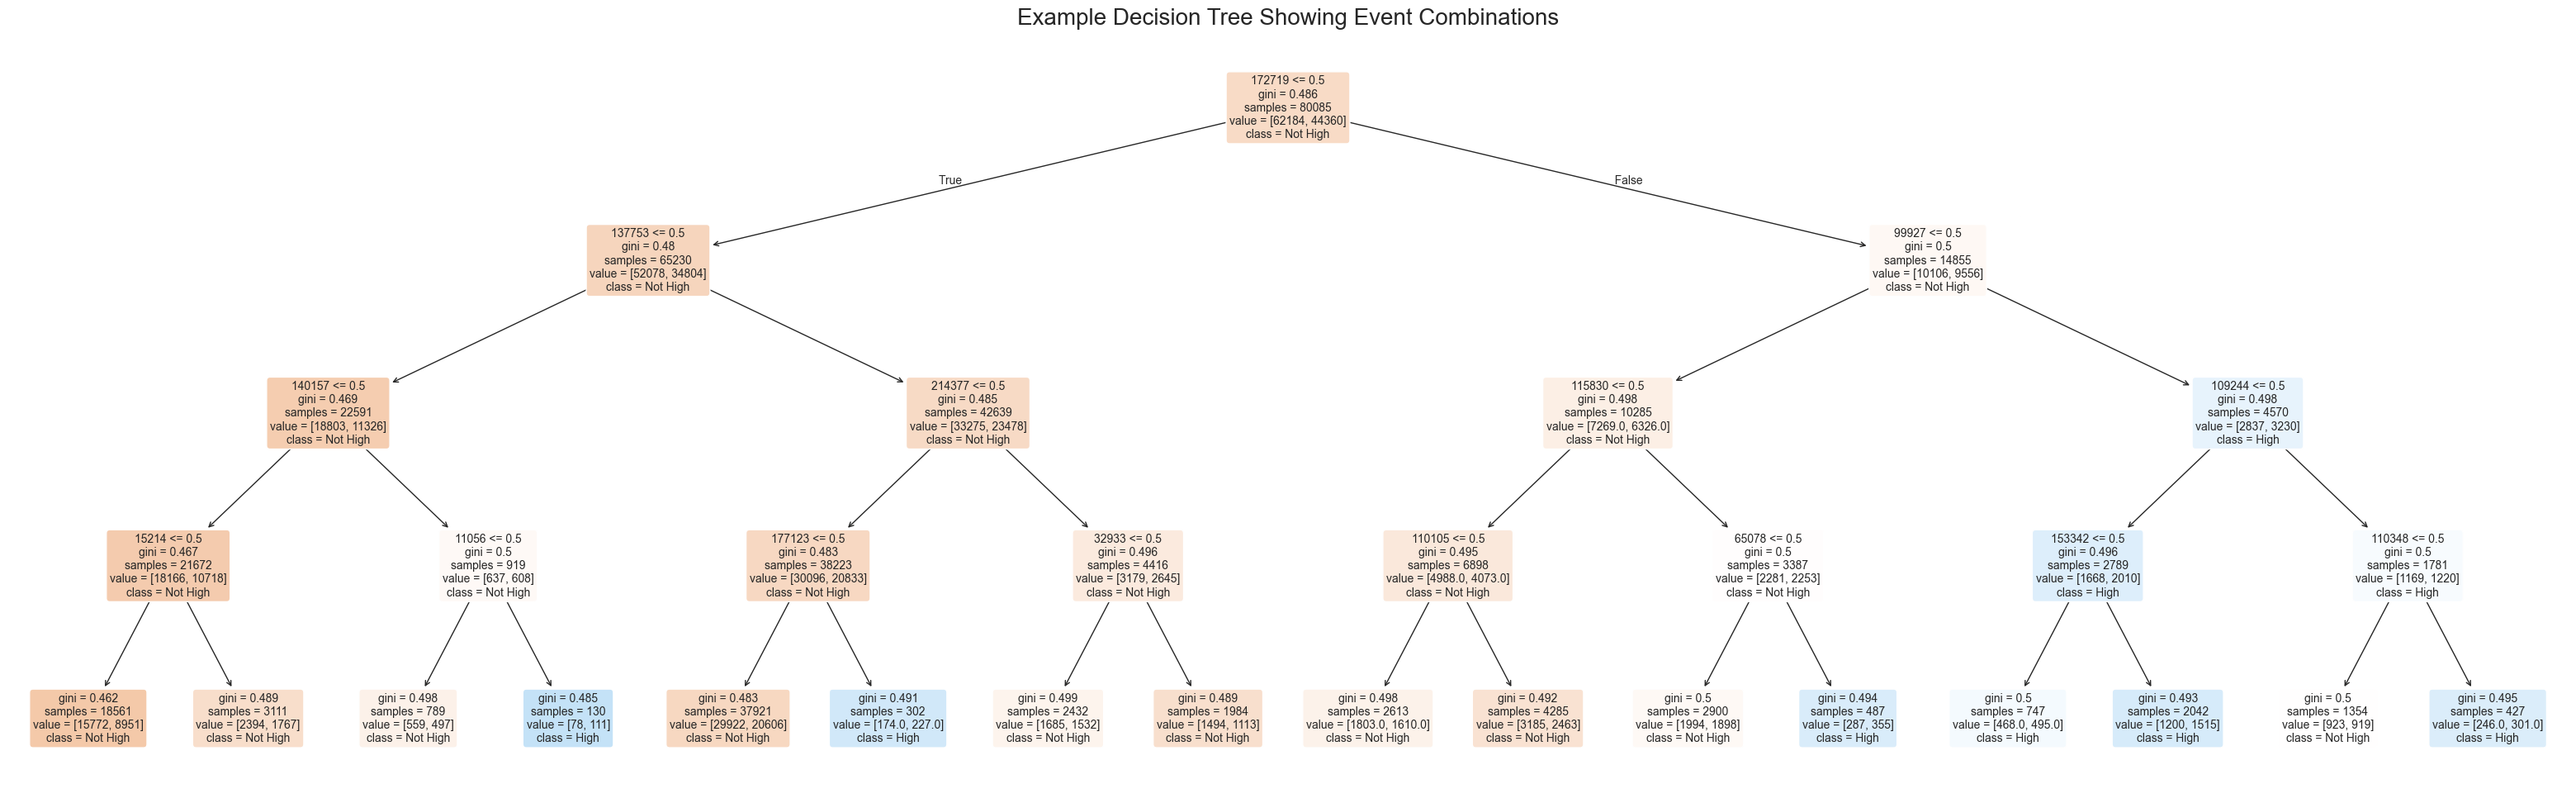

In [328]:
from sklearn.tree import plot_tree
# 3. Visualize a Decision Tree to see the combinations
print("\n--- Visualizing Event Combinations with a Decision Tree ---")
# Let's pick one tree from our trained forest (e.g., the 5th one)
single_tree = rf.estimators_[0]

plt.figure(figsize=(40, 12))
plot_tree(single_tree,
          feature_names=df_combined_condition.columns,
          class_names=['Not High', 'High'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=5) # Limit depth for better readability
plt.title("Example Decision Tree Showing Event Combinations", fontsize=20)
plt.show()

In [329]:
list_df[0]["target_cat"].value_counts()

target_cat
high       107671
low        105473
neutral     40533
Name: count, dtype: int64

In [330]:
list_df[0]["target_cat"].value_counts() / list_df[0].shape[0]

target_cat
high       0.424441
low        0.415777
neutral    0.159782
Name: count, dtype: float64

In [331]:
np.sum(y_rf_train.values) / y_rf_train.shape[0]

np.float64(0.4164709725014501)

In [332]:
np.sum(y_rf_test.values) / y_rf_test.shape[0]

np.float64(0.44303847366761273)

In [333]:
arr_mdl_prob = rf.predict_proba(X_rf_test)
arr_mdl_prob

array([[0.59394845, 0.40605155],
       [0.60363425, 0.39636575],
       [0.60580604, 0.39419396],
       ...,
       [0.48763717, 0.51236283],
       [0.48146762, 0.51853238],
       [0.47417653, 0.52582347]], shape=(76104, 2))

In [334]:
# sort by prob 
np.sum(arr_mdl_prob[:,1]>0.5) / arr_mdl_prob.shape[0]

np.float64(0.11443550930305897)

In [335]:
arr_mdl_pred = rf.predict(X_rf_test)
arr_mdl_pred

array([False, False, False, ...,  True,  True,  True], shape=(76104,))

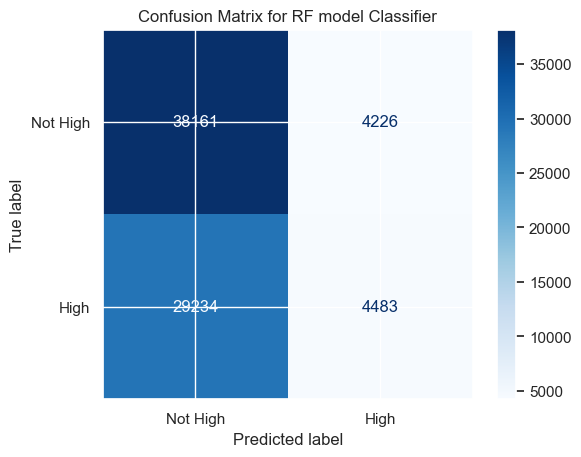

In [336]:
cm = confusion_matrix(y_rf_test, arr_mdl_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for RF model Classifier")
plt.show()

In [337]:
print("For Model RF: ")
print(f"precision: {precision_score(y_rf_test, arr_mdl_pred):.2f}")
print(f"% possible trades : {100*np.sum(arr_mdl_pred) / arr_mdl_pred.shape[0]:.2f}")
# per day 
print(f"nb trade per day : {288*arr_mdl_pred.sum() / arr_mdl_pred.shape[0]:.0f}")


For Model RF: 
precision: 0.51
% possible trades : 11.44
nb trade per day : 33


=> predict only 11% high to be compared to true 44% high

### Comb Prob Improvement 

#### Best Prob
We use only one single best prob event to detect high trades

In [338]:
# test add a event one by one to check if prob is better
df_prob_comb_high_event.sort_values(by="p_high", ascending=False).head(10)

high   low  neutral    p_high     p_low  delta_prob  \
103194  8067  6070     1260  0.523933  0.394233  564.194525   
100035  8262  6200     1321  0.523475  0.392828  588.002213   
210519  8594  6501     1356  0.522400  0.395174  580.410600   
196209  8796  6635     1411  0.522266  0.393956  605.264856   
210438  8980  6837     1381  0.522154  0.397546  580.697857   
102519  8725  6586     1402  0.522049  0.394065  597.651492   
108999  8641  6600     1313  0.521989  0.398695  546.641428   
216594  8540  6521     1301  0.521941  0.398545  541.313459   
102573  8245  6248     1304  0.521935  0.395518  550.335886   
196128  9181  6978     1435  0.521826  0.396612  600.681849   

                     feat_0 feat_0_cat  lag_0               feat_1  ... lag_1  \
103194          Low_ETH_cat       high     68       vwap_d_ETH_cat  ...    70   
100035       vwap_d_ETH_cat       high     68          Low_ETH_cat  ...    68   
210519       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
196209       vwap_d_ETH_cat       high     68  ichi_tenkan_ETH_cat  ...    70   
210438       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
102519          Low_ETH_cat       high     68       vwap_h_ETH_cat  ...    70   
108999       vwap_d_ETH_cat       high     70  ichi_tenkan_ETH_cat  ...    70   
216594  ichi_tenkan_ETH_cat       high     70       vwap_d_ETH_cat  ...    71   
102573          Low_ETH_cat       high     68       vwap_h_ETH_cat  ...    70   
196128       vwap_d_ETH_cat       high     68  ichi_tenkan_ETH_cat  ...    70   

                     feat_2 feat_2_cat lag_2  days_with_event  \
103194  ichi_tenkan_ETH_cat       high    70              845   
100035  ichi_tenkan_ETH_cat       high    70              849   
210519         Open_ETH_cat       high    68              845   
196209         Open_ETH_cat       high    68              847   
210438         High_ETH_cat       high    68              842   
102519       vwap_d_ETH_cat       high    70              848   
108999         High_ETH_cat       high    40              830   
216594         High_ETH_cat       high    68              818   
102573       vwap_d_ETH_cat       high    71              820   
196128         High_ETH_cat       high    68              847   

        weeks_with_event  months_with_event  ratio_days_with_event  \
103194               126                 29               0.959137   
100035               126                 29               0.963678   
210519               126                 29               0.959137   
196209               126                 29               0.961407   
210438               126                 29               0.955732   
102519               126                 29               0.962543   
108999               126                 29               0.942111   
216594               126                 29               0.928490   
102573               126                 29               0.930760   
196128               126                 29               0.961407   

        ratio_weeks_with_event  ratio_months_with_event  
103194                0.992126                      1.0  
100035                0.992126                      1.0  
210519                0.992126                      1.0  
196209                0.992126                      1.0  
210438                0.992126                      1.0  
102519                0.992126                      1.0  
108999                0.992126                      1.0  
216594                0.992126                      1.0  
102573                0.992126                      1.0  
196128                0.992126                      1.0  

[10 rows x 21 columns]

In [339]:
idx_best_event = df_prob_comb_high_event.sort_values(by="p_high", ascending=False).index[0]
print(idx_best_event)

103194


In [340]:
df_prob_comb_high_event.loc[idx_best_event]

high                                      8067
low                                       6070
neutral                                   1260
p_high                                0.523933
p_low                                 0.394233
delta_prob                          564.194525
feat_0                             Low_ETH_cat
feat_0_cat                                high
lag_0                                       68
feat_1                          vwap_d_ETH_cat
feat_1_cat                                high
lag_1                                       70
feat_2                     ichi_tenkan_ETH_cat
feat_2_cat                                high
lag_2                                       70
days_with_event                            845
weeks_with_event                           126
months_with_event                           29
ratio_days_with_event                 0.959137
ratio_weeks_with_event                0.992126
ratio_months_with_event                    1.0
Name: 103194,

In [341]:
# MDL prob
y_pred_best_prob_test = X_rf_test[idx_best_event]
y_pred_best_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00     True
2025-05-30 19:35:00     True
Name: 103194, Length: 76104, dtype: bool

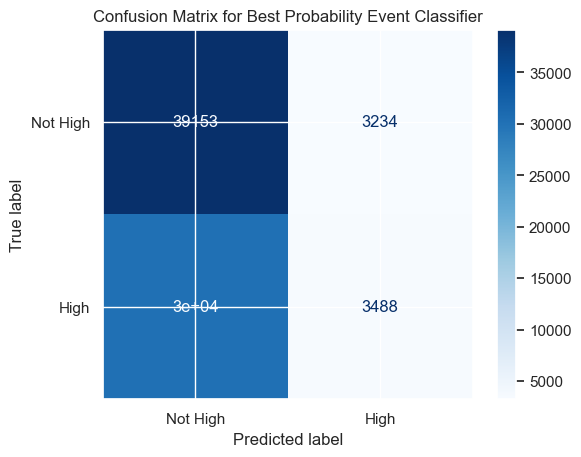

In [342]:

cm = confusion_matrix(y_rf_test, y_pred_best_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Probability Event Classifier")
plt.show()

In [343]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_prob_test.sum() / y_pred_best_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_prob_test.sum() / y_pred_best_prob_test.shape[0]:.0f}")



precision: 0.52
% possible trades : 8.83%
nb trade per day : 25


Good results with only the first best event

#### Best prob + 1 event
We add a event one by one to check if model is better

In [344]:
# --- Optimized Code ---

# 1. Find the best single event and its probability more directly
# .idxmax() is more efficient than sorting the entire DataFrame.
best_event_name = df_prob_comb_high_event['p_high'].idxmax()
best_prob_0 = df_prob_comb_high_event['p_high'].max()

# Store the best combination found so far. Start with the best single event.
best_combination = (best_event_name,)

print(f"Initial best event: '{best_event_name}' with probability: {best_prob_0:.4f}")

# 2. Pre-calculate the boolean mask for "high" targets for efficiency
# This avoids recalculating it on each iteration of the loop.
is_high_target = (list_df[0]["target_cat"] == "high")
min_support = 1000
list_second_event_name = []
# 3. Iterate through all events to find a better PAIR
print("\nSearching for a better two-event combination...")
for second_event_name in df_combined_condition.columns:
    # Don't combine an event with itself
    if second_event_name == best_event_name:
        continue

    # 4. Create a boolean mask for the event combination
    # This correctly uses the event names (strings) to index the DataFrame columns.
    combination_mask = df_combined_condition[best_event_name] & df_combined_condition[second_event_name]

    # 5. Check if the combination has enough data points (support)
    support = combination_mask.sum()
    if support < min_support:
        continue

    # 6. Calculate the probability for this new combination
    # Slicing the pre-calculated 'is_high_target' series is much faster.
    high_targets_in_combination = is_high_target[combination_mask].sum()
    current_prob = high_targets_in_combination / support

    # 7. If the new combination is better, update the tracking variables
    if current_prob > best_prob_0:
        best_prob_0 = current_prob
        best_combination = (best_event_name, second_event_name)
        list_second_event_name.append(second_event_name)
        print("\n--- New Best Combination Found ---")
        print(f"Combination: {best_combination}")
        print(f"New best probability: {best_prob_0:.4f}")
        print(f"Support (Highs / Total): {high_targets_in_combination} / {support}")

print("\n--- Search Complete ---")
print(f"The best combination found is: {best_combination}")
print(f"With a probability of: {best_prob_0:.4f}")


Initial best event: '103194' with probability: 0.5239

Searching for a better two-event combination...

--- New Best Combination Found ---
Combination: (np.int64(103194), 54)
New best probability: 0.5250
Support (Highs / Total): 7318 / 13939

--- New Best Combination Found ---
Combination: (np.int64(103194), 432)
New best probability: 0.5256
Support (Highs / Total): 6599 / 12555

--- New Best Combination Found ---
Combination: (np.int64(103194), 513)
New best probability: 0.5262
Support (Highs / Total): 6287 / 11948

--- New Best Combination Found ---
Combination: (np.int64(103194), 541)
New best probability: 0.5287
Support (Highs / Total): 4589 / 8679

--- New Best Combination Found ---
Combination: (np.int64(103194), 730)
New best probability: 0.5299
Support (Highs / Total): 3845 / 7256

--- New Best Combination Found ---
Combination: (np.int64(103194), 1459)
New best probability: 0.5300
Support (Highs / Total): 3870 / 7302

--- New Best Combination Found ---
Combination: (np.int64(1

- What is the combined events exactly ?


In [345]:
list_second_event_name

[54, 432, 513, 541, 730, 1459, 5266, 10936, 12422, 39422, 40371, 40641, 40670]

In [346]:
df_prob_comb_high_event.loc[[best_combination[0], best_combination[1]]].T

103194             40670 
high                                    8067               8726
low                                     6070               7718
neutral                                 1260               2441
p_high                              0.523933            0.46206
p_low                               0.394233           0.408684
delta_prob                        564.194525         123.578691
feat_0                           Low_ETH_cat     vwap_h_ETH_cat
feat_0_cat                              high               high
lag_0                                     68                 56
feat_1                        vwap_d_ETH_cat  min_low_h_ETH_cat
feat_1_cat                              high            neutral
lag_1                                     70                 64
feat_2                   ichi_tenkan_ETH_cat      rsi_h_BTC_cat
feat_2_cat                              high            neutral
lag_2                                     70                 71
days_with_event                          845                866
weeks_with_event                         126                127
months_with_event                         29                 29
ratio_days_with_event               0.959137           0.982974
ratio_weeks_with_event              0.992126                1.0
ratio_months_with_event                  1.0                1.0

In [347]:
# MDL prob
y_pred_best_1_prob_test = X_rf_test[best_combination[0]] & X_rf_test[best_combination[1]]
y_pred_best_1_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00     True
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

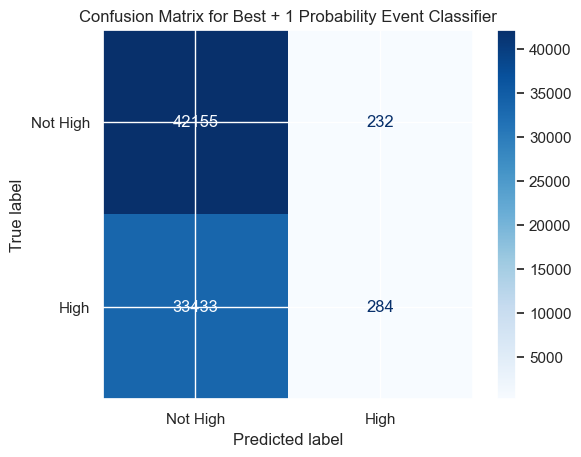

In [348]:

cm = confusion_matrix(y_rf_test, y_pred_best_1_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + 1 Probability Event Classifier")
plt.show()

In [349]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_1_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_1_prob_test.sum() / y_pred_best_1_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_1_prob_test.sum() / y_pred_best_1_prob_test.shape[0]:.0f}")


precision: 0.55
% possible trades : 0.68%
nb trade per day : 2


Ok but not enough trades possible per day : try to have min 10

##### Best prob + OR multi best event
- Best event with at least one another best event

In [350]:
# MDL prob
y_pred_best_multi_prob_test = X_rf_test[best_combination[0]] & (
    (X_rf_test[best_combination[1]]) | 
    (X_rf_test[list_second_event_name[-2]] | 
     X_rf_test[list_second_event_name[-3]] | 
     X_rf_test[list_second_event_name[-4]] | 
     X_rf_test[list_second_event_name[-5]] | 
     X_rf_test[list_second_event_name[-6]]))
y_pred_best_multi_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00     True
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

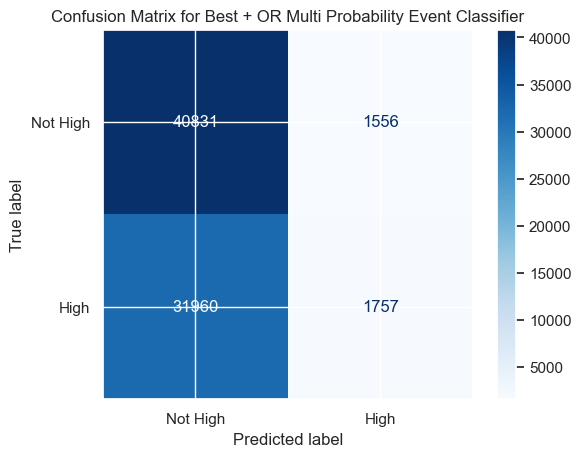

In [351]:

cm = confusion_matrix(y_rf_test, y_pred_best_multi_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()

In [352]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_multi_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_multi_prob_test.sum() / y_pred_best_multi_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_multi_prob_test.sum() / y_pred_best_multi_prob_test.shape[0]:.0f}")


precision: 0.53
% possible trades : 4.35%
nb trade per day : 13


Better results than only the best (precison = 0.52) but with less trades per day (/2)

#### All high prob event + 1 event
To test if adding an event (from 27000 events) to 57 best events, can improve high probability ? 

In [353]:
min_support = 1000 # min number of occurrences of this new combination
p_min = 0.52

# check hash
path_hash_comb_improvement = os.path.join(path_data, 'comb_improvement_inputs_hash.txt')
path_df_probability_filtered = os.path.join(path_data, 'df_probability_filtered.pkl')
mode_redo_comb, hash_comb = check_hash_inputs(
     (df_combined_condition, 
      min_support, 
      p_min,
     ),
     path_hash_comb_improvement,
)

hash match: mode LOAD


In [354]:
df_combined_condition

0       13      20      23      27      40      45      \
date_ETH                                                                      
2023-01-01 00:00:00   False   False   False   False   False   False   False   
2023-01-01 00:05:00   False   False   False   False   False   False   False   
2023-01-01 00:10:00   False   False   False   False   False   False   False   
2023-01-01 00:15:00   False   False   False   False   False   False   False   
2023-01-01 00:20:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False    True   False   False   False   False   
2025-05-30 19:20:00   False   False    True   False   False   False   False   
2025-05-30 19:25:00    True   False   False   False   False   False   False   
2025-05-30 19:30:00    True   False   False   False   False   False   False   
2025-05-30 19:35:00    True   False   False   False    True   False   False   

                     47      50      54      ...  219158  219165  219175  \
date_ETH                                     ...                           
2023-01-01 00:00:00   False   False   False  ...   False   False   False   
2023-01-01 00:05:00   False   False   False  ...   False   False   False   
2023-01-01 00:10:00   False   False   False  ...   False   False   False   
2023-01-01 00:15:00   False   False   False  ...    True   False   False   
2023-01-01 00:20:00   False   False   False  ...    True   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00    True   False   False  ...   False   False   False   
2025-05-30 19:20:00    True   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False    True  ...   False   False   False   
2025-05-30 19:30:00   False   False    True  ...   False   False   False   
2025-05-30 19:35:00   False   False    True  ...   False   False   False   

                     219185  219192  219202  219212  219237  219238  219239  
date_ETH                                                                     
2023-01-01 00:00:00   False   False   False   False   False   False    True  
2023-01-01 00:05:00   False   False   False   False   False   False    True  
2023-01-01 00:10:00   False   False   False   False   False   False    True  
2023-01-01 00:15:00    True   False   False    True   False   False    True  
2023-01-01 00:20:00    True   False   False    True   False   False    True  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[253677 rows x 27660 columns]

In [355]:
# compute time : 15 min : for 57 best events * 27000 events

if mode_redo_comb:
    # --- Setup: Assuming these DataFrames are pre-loaded ---
    # df_combined_condition: (n_samples, n_events) boolean DataFrame
    # list_df: A list containing the DataFrame with the target
    # df_prob_comb_high_event: (n_events, 1) DataFrame with single-event probabilities ('p_high')

    # --- Optimized Code using Targeted Matrix Multiplication ---

    # 1. Prepare the data
    # Using boolean arrays is memory-efficient. We'll convert to int just before matmul.
    X = df_combined_condition.values
    is_high_target = (list_df[0]["target_cat"] == "high").values
    event_names = df_combined_condition.columns
    n_events = len(event_names)
    print("--- Starting targeted search for best event combination ---")

    # 2. Find the best single event from the pre-calculated DataFrame
    # This is fast and doesn't require a large matrix operation.
    best_single_prob = df_prob_comb_high_event['p_high'].max()
    best_single_name = df_prob_comb_high_event['p_high'].idxmax()

    # Initialize the best result with the best single event
    best_prob = best_single_prob
    best_combination = (best_single_name,)
    print(f"Initial best single event: '{best_single_name}' with probability: {best_prob:.4f}")

    # 3. Identify the high-probability events to form pairs with
    high_prob_event_names = df_prob_comb_high_event[df_prob_comb_high_event["p_high"] > p_min].index

    if high_prob_event_names.empty:
        print(f"\nNo single events with p_high > {p_min}. The best combination is the single event found above.")
    else:
        print(f"\nFound {len(high_prob_event_names)} events with p_high > {p_min} to form pairs with.")
        
        # Get the integer indices for these high-probability events
        name_to_idx = {name: i for i, name in enumerate(event_names)}
        high_prob_indices = [name_to_idx[name] for name in high_prob_event_names]

        # 4. Create the sub-matrix for high-prob events (k columns)
        X_h = X[:, high_prob_indices].astype(np.int32)

        # 5. Calculate support and high-counts for the targeted pairs ONLY
        # This creates a (k, N) matrix, which is much smaller than (N, N)
        print("5.Calculating support and high-counts for the targeted pairs...")
        support_filtered = X_h.T @ X.astype(np.int32)
        
        # Create a version of X where rows are zeroed out if the target was not "high"
        X_high = X * is_high_target[:, np.newaxis]
        X_h_high = X_high[:, high_prob_indices].astype(np.int32)
        print("Create a version of X where rows are zeroed out if the target was not 'high'.")
        high_count_filtered = X_h_high.T @ X.astype(np.int32)

        # 6. Calculate the probability matrix for the targeted pairs
        print("6.Calculating the probability matrix for the targeted pairs...")
        with np.errstate(divide='ignore', invalid='ignore'):
            probability_filtered = high_count_filtered / support_filtered
        probability_filtered = np.nan_to_num(probability_filtered)

        # 7. Apply filters to the (k, N) matrix
        # Minimum support filter
        print("7.Apply filters to the (k, N) matrix...")
        probability_filtered[support_filtered < min_support] = 0
        
        # Filter out pairs of an event with itself
        for i, original_idx in enumerate(high_prob_indices):
            if original_idx < n_events:
                probability_filtered[i, original_idx] = 0
        
        # Create a DataFrame with the filtered probabilities
        df_probability_filtered = pd.DataFrame(
        probability_filtered, 
        columns=event_names, 
        index=high_prob_event_names,
        )
        # save
        df_probability_filtered.to_pickle(path_df_probability_filtered)
        # hash
        save_hash(path_hash_comb_improvement, hash_comb)

        # 8. Find the best PAIR from the filtered results
        print("8.Find the best PAIR from the filtered results...")
        best_pair_prob = probability_filtered.max()
        
        if best_pair_prob > best_prob:
            # Find the row/col index in the (k, N) matrix
            idx_flat = np.argmax(probability_filtered)
            idx_pair_filtered = np.unravel_index(idx_flat, probability_filtered.shape)
            
            # Map indices back to original event names
            event1_name = high_prob_event_names[idx_pair_filtered[0]]
            event2_name = event_names[idx_pair_filtered[1]]
            
            best_prob = best_pair_prob
            best_combination = (event1_name, event2_name)

    # 9. Display the final result
    print("\n--- Search Complete ---")
    print(f"The best combination found is: {best_combination}")
    print(f"With a probability of: {best_prob:.4f}")

    # Retrieve support and high count for the final best combination for reporting
    if len(best_combination) == 1:
        event_mask = df_combined_condition[best_combination[0]]
        support = event_mask.sum()
        high_count = (event_mask & is_high_target).sum()
    else:
        # For a pair, we can retrieve the values we already calculated
        e1, e2 = best_combination
        if e1 in high_prob_event_names:
            idx_h = high_prob_event_names.get_loc(e1)
            idx_a = event_names.get_loc(e2)
            support = support_filtered[idx_h, idx_a]
            high_count = high_count_filtered[idx_h, idx_a]
        else: # The other event must be the high-probability one
            idx_h = high_prob_event_names.get_loc(e2)
            idx_a = event_names.get_loc(e1)
            support = support_filtered[idx_h, idx_a]
            high_count = high_count_filtered[idx_h, idx_a]

    print(f"Support (Highs / Total): {high_count} / {support}")
else:
    df_probability_filtered = pd.read_pickle(path_df_probability_filtered)
    best_prob = df_probability_filtered.max().max()
    print(f"The best probability found is: {best_prob:.4f}")
    
    #best_combination = df_probability_filtered.idxmax().values

# get 100 best comb : 

df_probability_filtered


The best probability found is: 0.5646


0       13      20      23        27      40      45      47      \
45603   0.520606     0.0     0.0     0.0  0.519174     0.0     0.0     0.0   
45657   0.521416     0.0     0.0     0.0  0.521243     0.0     0.0     0.0   
47034   0.520357     0.0     0.0     0.0  0.519552     0.0     0.0     0.0   
47277   0.520283     0.0     0.0     0.0  0.518919     0.0     0.0     0.0   
65016   0.520409     0.0     0.0     0.0  0.521200     0.0     0.0     0.0   
66123   0.520236     0.0     0.0     0.0  0.520403     0.0     0.0     0.0   
67554   0.520014     0.0     0.0     0.0  0.520275     0.0     0.0     0.0   
70686   0.520365     0.0     0.0     0.0  0.520320     0.0     0.0     0.0   
76923   0.520044     0.0     0.0     0.0  0.519912     0.0     0.0     0.0   
85617   0.520368     0.0     0.0     0.0  0.519798     0.0     0.0     0.0   
85671   0.520831     0.0     0.0     0.0  0.519923     0.0     0.0     0.0   
88236   0.520398     0.0     0.0     0.0  0.521137     0.0     0.0     0.0   
89343   0.520485     0.0     0.0     0.0  0.520847     0.0     0.0     0.0   
92583   0.519810     0.0     0.0     0.0  0.518876     0.0     0.0     0.0   
92637   0.522724     0.0     0.0     0.0  0.522098     0.0     0.0     0.0   
94014   0.520282     0.0     0.0     0.0  0.519397     0.0     0.0     0.0   
94257   0.519918     0.0     0.0     0.0  0.518855     0.0     0.0     0.0   
95040   0.520564     0.0     0.0     0.0  0.520323     0.0     0.0     0.0   
99846   0.521176     0.0     0.0     0.0  0.521795     0.0     0.0     0.0   
99981   0.519767     0.0     0.0     0.0  0.519375     0.0     0.0     0.0   
100035  0.523679     0.0     0.0     0.0  0.523433     0.0     0.0     0.0   
101817  0.521900     0.0     0.0     0.0  0.519447     0.0     0.0     0.0   
102519  0.521180     0.0     0.0     0.0  0.521929     0.0     0.0     0.0   
102573  0.521516     0.0     0.0     0.0  0.521394     0.0     0.0     0.0   
103113  0.520792     0.0     0.0     0.0  0.519083     0.0     0.0     0.0   
103194  0.523516     0.0     0.0     0.0  0.523652     0.0     0.0     0.0   
103221  0.521008     0.0     0.0     0.0  0.518708     0.0     0.0     0.0   
103410  0.520273     0.0     0.0     0.0  0.519019     0.0     0.0     0.0   
104679  0.520928     0.0     0.0     0.0  0.519355     0.0     0.0     0.0   
104922  0.520527     0.0     0.0     0.0  0.518868     0.0     0.0     0.0   
106893  0.520372     0.0     0.0     0.0  0.518119     0.0     0.0     0.0   
107136  0.520502     0.0     0.0     0.0  0.517800     0.0     0.0     0.0   
107622  0.520631     0.0     0.0     0.0  0.518635     0.0     0.0     0.0   
108729  0.521337     0.0     0.0     0.0  0.519630     0.0     0.0     0.0   
108999  0.522229     0.0     0.0     0.0  0.519815     0.0     0.0     0.0   
109107  0.520993     0.0     0.0     0.0  0.519244     0.0     0.0     0.0   
109431  0.521771     0.0     0.0     0.0  0.519110     0.0     0.0     0.0   
196128  0.522445     0.0     0.0     0.0  0.522820     0.0     0.0     0.0   
196209  0.522342     0.0     0.0     0.0  0.522304     0.0     0.0     0.0   
196344  0.521177     0.0     0.0     0.0  0.522019     0.0     0.0     0.0   
209466  0.520282     0.0     0.0     0.0  0.519397     0.0     0.0     0.0   
209763  0.520357     0.0     0.0     0.0  0.519552     0.0     0.0     0.0   
210330  0.520014     0.0     0.0     0.0  0.520275     0.0     0.0     0.0   
210438  0.522210     0.0     0.0     0.0  0.522794     0.0     0.0     0.0   
210519  0.522064     0.0     0.0     0.0  0.522502     0.0     0.0     0.0   
210654  0.520799     0.0     0.0     0.0  0.521617     0.0     0.0     0.0   
210735  0.519588     0.0     0.0     0.0  0.519940     0.0     0.0     0.0   
212166  0.519918     0.0     0.0     0.0  0.518855     0.0     0.0     0.0   
212220  0.521873     0.0     0.0     0.0  0.521672     0.0     0.0     0.0   
212301  0.521946     0.0     0.0     0.0  0.521353     0.0     0.0     0.0   
213651  0.520283     0.0     0.0

In [356]:
ind_sort = np.unravel_index(
    np.argsort(
        df_probability_filtered.values, 
        axis=None,
    ), 
    df_probability_filtered.shape,
)
# create a dataframe with the best 100 combinations
df_best_comb = pd.DataFrame(
    df_probability_filtered.values[(ind_sort[0][-100:], ind_sort[1][-100:])],
    columns=["prob"])

df_best_comb["event_p_high"] = df_probability_filtered.index[ind_sort[0][-100:]]
df_best_comb["event_1"] = df_probability_filtered.columns[ind_sort[1][-100:]]
#df_probability_filtered.columns[ind_sort[1][-100:]]

df_best_comb.sort_values(by="prob", ascending=False, inplace=True)
df_best_comb.head(30)

prob  event_p_high  event_1
99  0.564620        210330    40641
98  0.564620         67554    40641
97  0.563437        217350   119333
96  0.562920        217350   110832
95  0.562874        217350   119306
94  0.562857        217350   110103
93  0.562500        217350   117852
92  0.559501        109107   111345
91  0.558897        210330    40371
90  0.558897         67554    40371
89  0.558708        107622    55233
88  0.558541        109107   111615
87  0.558429        109107   111183
86  0.558229        109107   111237
85  0.558140         67554    48093
84  0.558140        210330    48093
83  0.558117        109107   111264
82  0.558006        109107   111696
81  0.557958         89343   110103
80  0.557576         67554    61011
79  0.557576        210330    61011
78  0.557491         89343   110832
77  0.557105         89343   117852
75  0.557085         47034    55233
76  0.557085        209763    55233
74  0.557073        109107   111507
73  0.556631        109107   111291
72  0.555659         92583   119306
71  0.555556        109107   147438
70  0.555556         47277    55233

In [357]:
best_comb_1 = (df_best_comb["event_p_high"].iloc[0], df_best_comb["event_1"].iloc[0])

df_prob_comb_high_event.loc[[best_comb_1[0], best_comb_1[1]]].T

210330             40641 
high                                    9541               9562
low                                     7319               8257
neutral                                 1488               2572
p_high                              0.520002           0.468932
p_low                               0.398899           0.404934
delta_prob                         585.68019          191.14709
feat_0                        vwap_d_ETH_cat     vwap_h_ETH_cat
feat_0_cat                              high               high
lag_0                                     70                 56
feat_1                   ichi_tenkan_ETH_cat  min_low_h_ETH_cat
feat_1_cat                              high            neutral
lag_1                                     70                 64
feat_2                           Low_ETH_cat       High_ETH_cat
feat_2_cat                              high               high
lag_2                                     64                 40
days_with_event                          845                861
weeks_with_event                         126                127
months_with_event                         29                 29
ratio_days_with_event               0.959137           0.977299
ratio_weeks_with_event              0.992126                1.0
ratio_months_with_event                  1.0                1.0

In [358]:
nb_occ_best_comb_1 = (df_combined_condition[best_comb_1[0]] & df_combined_condition[best_comb_1[1]]).sum()
print("On Train : ")
print(f"nb occurrences : {nb_occ_best_comb_1}")
print(f"{100 * nb_occ_best_comb_1 / df_combined_condition.shape[0]:.2f}% of the data matches this combination of events.")
print(f"to be compared to one day = {100*288/ df_combined_condition.shape[0]:.2f} % of the data")

On Train : 
nb occurrences : 1238
0.49% of the data matches this combination of events.
to be compared to one day = 0.11 % of the data


In [359]:
# MDL prob
y_pred_best_comb_prob_test = X_rf_test[best_comb_1[0]] & X_rf_test[best_comb_1[1]]
y_pred_best_comb_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00     True
2025-05-30 19:30:00     True
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

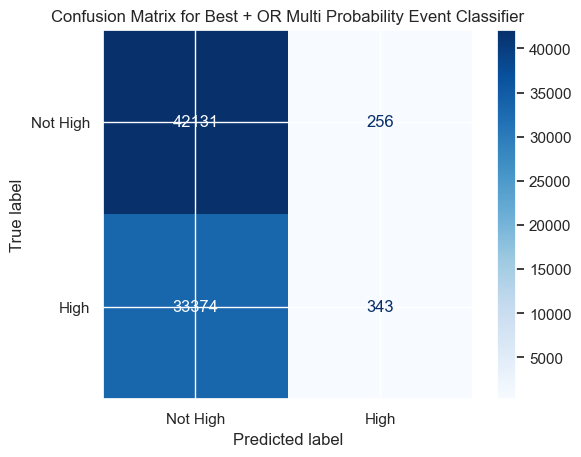

In [360]:
cm = confusion_matrix(y_rf_test, y_pred_best_comb_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()

In [361]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_comb_prob_test):.3f}")
print(f"% possible trades : {100*y_pred_best_comb_prob_test.sum() / y_pred_best_comb_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_comb_prob_test.sum() / y_pred_best_comb_prob_test.shape[0]:.0f}")


precision: 0.573
% possible trades : 0.79%
nb trade per day : 2


- these 2 Combined events gives a good precision = 0.57 (2 trades/day)
- compared best comb precsion = 0.55 (2 trades/day)  
- ML Model precision on Test data : 0.51 (33 trades/day)

CONCLUSION : 
- ML model can be enough for global prediction but maybe too low win rate ?
- These best 2 combined event give a very good precision but not enough possible trades ?

##### Best comb2 + OR multi comb2

In [362]:
# MDL prob
# MDL prob
best_comb_1 = (df_best_comb["event_p_high"].iloc[0], df_best_comb["event_1"].iloc[0])

y_pred_best_comb_or_prob_test = (
    X_rf_test[df_best_comb["event_p_high"].iloc[0]] & X_rf_test[df_best_comb["event_1"].iloc[0]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[1]] & X_rf_test[df_best_comb["event_1"].iloc[1]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[2]] & X_rf_test[df_best_comb["event_1"].iloc[2]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[3]] & X_rf_test[df_best_comb["event_1"].iloc[3]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[4]] & X_rf_test[df_best_comb["event_1"].iloc[4]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[5]] & X_rf_test[df_best_comb["event_1"].iloc[5]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[6]] & X_rf_test[df_best_comb["event_1"].iloc[6]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[7]] & X_rf_test[df_best_comb["event_1"].iloc[7]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[8]] & X_rf_test[df_best_comb["event_1"].iloc[8]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[9]] & X_rf_test[df_best_comb["event_1"].iloc[9]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[10]] & X_rf_test[df_best_comb["event_1"].iloc[10]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[11]] & X_rf_test[df_best_comb["event_1"].iloc[11]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[12]] & X_rf_test[df_best_comb["event_1"].iloc[12]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[13]] & X_rf_test[df_best_comb["event_1"].iloc[13]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[14]] & X_rf_test[df_best_comb["event_1"].iloc[14]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[15]] & X_rf_test[df_best_comb["event_1"].iloc[15]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[16]] & X_rf_test[df_best_comb["event_1"].iloc[16]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[17]] & X_rf_test[df_best_comb["event_1"].iloc[17]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[18]] & X_rf_test[df_best_comb["event_1"].iloc[18]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[19]] & X_rf_test[df_best_comb["event_1"].iloc[19]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[20]] & X_rf_test[df_best_comb["event_1"].iloc[20]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[21]] & X_rf_test[df_best_comb["event_1"].iloc[21]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[22]] & X_rf_test[df_best_comb["event_1"].iloc[22]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[23]] & X_rf_test[df_best_comb["event_1"].iloc[23]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[24]] & X_rf_test[df_best_comb["event_1"].iloc[24]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[25]] & X_rf_test[df_best_comb["event_1"].iloc[25]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[26]] & X_rf_test[df_best_comb["event_1"].iloc[26]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[27]] & X_rf_test[df_best_comb["event_1"].iloc[27]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[28]] & X_rf_test[df_best_comb["event_1"].iloc[28]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[29]] & X_rf_test[df_best_comb["event_1"].iloc[29]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[30]] & X_rf_test[df_best_comb["event_1"].iloc[30]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[31]] & X_rf_test[df_best_comb["event_1"].iloc[31]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[32]] & X_rf_test[df_best_comb["event_1"].iloc[32]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[33]] & X_rf_test[df_best_comb["event_1"].iloc[33]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[34]] & X_rf_test[df_best_comb["event_1"].iloc[34]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[35]] & X_rf_test[df_best_comb["event_1"].iloc[35]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[36]] & X_rf_test[df_best_comb["event_1"].iloc[36]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[37]] & X_rf_test[df_best_comb["event_1"].iloc[37]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[38]] & X_rf_test[df_best_comb["event_1"].iloc[38]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[39]] & X_rf_test[df_best_comb["event_1"].iloc[39]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[40]] & X_rf_test[df_best_comb["event_1"].iloc[40]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[41]] & X_rf_test[df_best_comb["event_1"].iloc[41]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[42]] & X_rf_test[df_best_comb["event_1"].iloc[42]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[43]] & X_rf_test[df_best_comb["event_1"].iloc[43]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[44]] & X_rf_test[df_best_comb["event_1"].iloc[44]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[45]] & X_rf_test[df_best_comb["event_1"].iloc[45]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[46]] & X_rf_test[df_best_comb["event_1"].iloc[46]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[47]] & X_rf_test[df_best_comb["event_1"].iloc[47]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[48]] & X_rf_test[df_best_comb["event_1"].iloc[48]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[49]] & X_rf_test[df_best_comb["event_1"].iloc[49]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[50]] & X_rf_test[df_best_comb["event_1"].iloc[50]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[51]] & X_rf_test[df_best_comb["event_1"].iloc[51]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[52]] & X_rf_test[df_best_comb["event_1"].iloc[52]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[53]] & X_rf_test[df_best_comb["event_1"].iloc[53]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[54]] & X_rf_test[df_best_comb["event_1"].iloc[54]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[55]] & X_rf_test[df_best_comb["event_1"].iloc[55]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[56]] & X_rf_test[df_best_comb["event_1"].iloc[56]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[57]] & X_rf_test[df_best_comb["event_1"].iloc[57]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[58]] & X_rf_test[df_best_comb["event_1"].iloc[58]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[59]] & X_rf_test[df_best_comb["event_1"].iloc[59]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[60]] & X_rf_test[df_best_comb["event_1"].iloc[60]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[61]] & X_rf_test[df_best_comb["event_1"].iloc[61]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[62]] & X_rf_test[df_best_comb["event_1"].iloc[62]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[63]] & X_rf_test[df_best_comb["event_1"].iloc[63]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[64]] & X_rf_test[df_best_comb["event_1"].iloc[64]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[65]] & X_rf_test[df_best_comb["event_1"].iloc[65]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[66]] & X_rf_test[df_best_comb["event_1"].iloc[66]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[67]] & X_rf_test[df_best_comb["event_1"].iloc[67]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[68]] & X_rf_test[df_best_comb["event_1"].iloc[68]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[69]] & X_rf_test[df_best_comb["event_1"].iloc[69]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[70]] & X_rf_test[df_best_comb["event_1"].iloc[70]] 
)
y_pred_best_comb_or_prob_test


date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00     True
2025-05-30 19:30:00     True
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

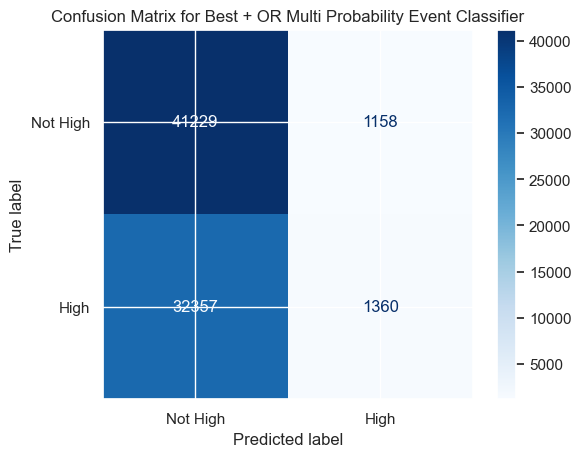

In [363]:
cm = confusion_matrix(y_rf_test, y_pred_best_comb_or_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()


In [364]:
1360/(1158+1360)

0.5401111993645751

In [365]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_comb_or_prob_test):.3f}")
print(f"% possible trades : {100*y_pred_best_comb_or_prob_test.sum() / y_pred_best_comb_or_prob_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_best_comb_or_prob_test.sum() / y_pred_best_comb_or_prob_test.shape[0]:.0f}")


precision: 0.540
% possible trades : 3.309%
nb trade per day : 10


- Low trades possible
- precision OK

##### All Best comb2 Max

In [366]:

df_best_comb

prob  event_p_high  event_1
99  0.564620        210330    40641
98  0.564620         67554    40641
97  0.563437        217350   119333
96  0.562920        217350   110832
95  0.562874        217350   119306
..       ...           ...      ...
4   0.552091        210519    40641
2   0.552083         47277    55017
3   0.552083        213651    55017
1   0.552032        109107   143525
0   0.552032        109107   146391

[100 rows x 3 columns]

In [367]:
X_rf_test

0       13      20      23      27      40      45      \
date_ETH                                                                      
2024-09-08 13:45:00   False   False    True   False   False   False   False   
2024-09-08 13:50:00   False   False   False   False   False   False   False   
2024-09-08 13:55:00   False   False    True   False   False   False   False   
2024-09-08 14:00:00   False   False    True   False   False   False   False   
2024-09-08 14:05:00   False   False    True   False   False   False    True   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False    True   False   False   False   False   
2025-05-30 19:20:00   False   False    True   False   False   False   False   
2025-05-30 19:25:00    True   False   False   False   False   False   False   
2025-05-30 19:30:00    True   False   False   False   False   False   False   
2025-05-30 19:35:00    True   False   False   False    True   False   False   

                     47      50      54      ...  219158  219165  219175  \
date_ETH                                     ...                           
2024-09-08 13:45:00    True   False   False  ...   False   False   False   
2024-09-08 13:50:00   False   False   False  ...   False   False   False   
2024-09-08 13:55:00    True   False   False  ...    True   False   False   
2024-09-08 14:00:00    True   False   False  ...    True   False   False   
2024-09-08 14:05:00   False   False   False  ...    True   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00    True   False   False  ...   False   False   False   
2025-05-30 19:20:00    True   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False    True  ...   False   False   False   
2025-05-30 19:30:00   False   False    True  ...   False   False   False   
2025-05-30 19:35:00   False   False    True  ...   False   False   False   

                     219185  219192  219202  219212  219237  219238  219239  
date_ETH                                                                     
2024-09-08 13:45:00   False   False   False   False   False   False    True  
2024-09-08 13:50:00   False   False   False   False   False   False    True  
2024-09-08 13:55:00    True   False   False    True   False   False    True  
2024-09-08 14:00:00    True   False   False    True   False   False    True  
2024-09-08 14:05:00    True   False   False    True   False   False    True  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[76104 rows x 27660 columns]

In [368]:
# create a new dataframe to have each double event
# for each double event (event_p_high and event_1), check if double event in df_best_comb is in X_rf_test
# instead of have true or false, give the value of df_best_comb.prob
df_best_comb_events_in_test = pd.DataFrame(index=X_rf_test.index)
for i, row in df_best_comb.iterrows():
    event_p_high = row["event_p_high"]
    event_1 = row["event_1"]
    df_best_comb_events_in_test[f"comb_{i}"] = (X_rf_test[event_p_high] & X_rf_test[event_1]) * row["prob"]
y_pred_max_comb2_test = df_best_comb_events_in_test.max(axis=1) > 0.5527
y_pred_max_comb2_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00     True
2025-05-30 19:30:00     True
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

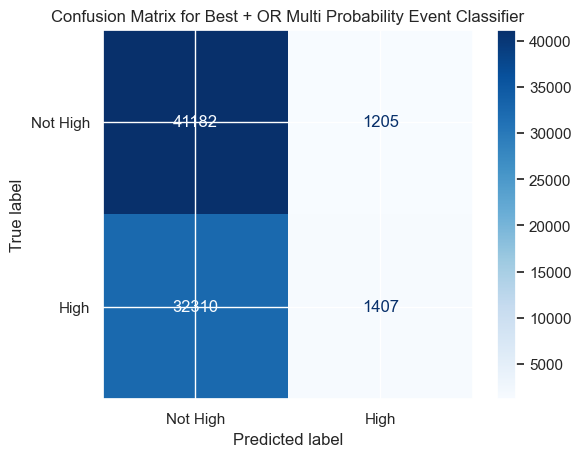

In [369]:
cm = confusion_matrix(y_rf_test, y_pred_max_comb2_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()

In [370]:
print(f"precision: {precision_score(y_rf_test, y_pred_max_comb2_test):.3f}")
print(f"% possible trades : {100*y_pred_max_comb2_test.sum() / y_pred_max_comb2_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_max_comb2_test.sum() / y_pred_max_comb2_test.shape[0]:.0f}")


precision: 0.539
% possible trades : 3.432%
nb trade per day : 10


=> Not better than "Best comb2 + OR multi comb2"

##### All Best comb2 Mean

In [371]:
(df_best_comb_events_in_test > 0).sum(axis=1)

date_ETH
2024-09-08 13:45:00     0
2024-09-08 13:50:00     0
2024-09-08 13:55:00     0
2024-09-08 14:00:00     0
2024-09-08 14:05:00     0
                       ..
2025-05-30 19:15:00     0
2025-05-30 19:20:00     0
2025-05-30 19:25:00    28
2025-05-30 19:30:00    41
2025-05-30 19:35:00     0
Length: 76104, dtype: int64

In [372]:

y_pred_mean_comb2_test = df_best_comb_events_in_test.sum(axis=1) / (df_best_comb_events_in_test > 0).sum(axis=1) > 0.553
y_pred_mean_comb2_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00     True
2025-05-30 19:30:00     True
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

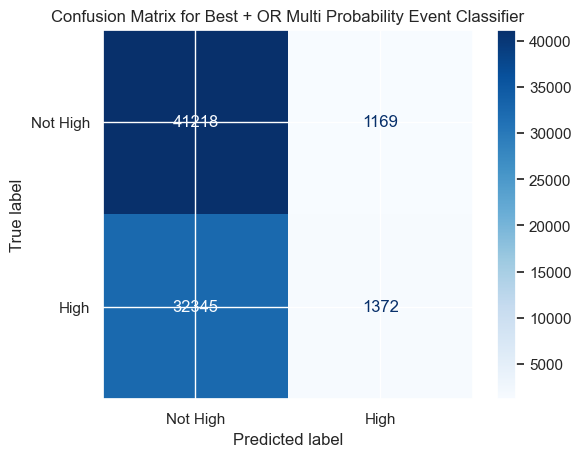

In [373]:
cm = confusion_matrix(y_rf_test, y_pred_mean_comb2_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()

In [374]:
print(f"precision: {precision_score(y_rf_test, y_pred_mean_comb2_test):.3f}")
print(f"% possible trades : {100*y_pred_mean_comb2_test.sum() / y_pred_mean_comb2_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_comb2_test.sum() / y_pred_mean_comb2_test.shape[0]:.0f}")


precision: 0.540
% possible trades : 3.339%
nb trade per day : 10


=> Same as multi comb2 OR  == BEST RESULT

### Max Prob Model
We take the max prob of all 27000 events  (nb occ>8000 and p_high > 0.4)


In [375]:
df_prob_comb_high_event

high    low  neutral    p_high     p_low  delta_prob  \
0       20487  16340     4502  0.495705  0.395364  933.967415   
13      16950  20295     4940  0.401802  0.481095 -600.833669   
20      21301  19625     9959  0.418611  0.385674  137.270977   
23      13680  13893     5343  0.415603  0.422074   -3.290828   
27      17019  13459     3819  0.496224  0.392425  831.655620   
...       ...    ...      ...       ...       ...         ...   
219202  13880  15828     4853  0.401609  0.457973 -255.466810   
219212  33440  31363    15247  0.417739  0.391793  133.139793   
219237  20915  17521     5701  0.473865  0.396969  599.398272   
219238  15856  17865     5395  0.405358  0.456718 -239.380861   
219239  49297  47518    22586  0.412869  0.397970   65.379146   

                    feat_0 feat_0_cat  lag_0              feat_1  ... lag_1  \
0           vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
13          vwap_h_ETH_cat        low     64         Low_ETH_cat  ...    56   
20          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
23          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
27          vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
...                    ...        ...    ...                 ...  ...   ...   
219202        High_ETH_cat        low     68  max_high_d_ETH_cat  ...    70   
219212        High_ETH_cat    neutral     68  max_high_d_ETH_cat  ...    70   
219237  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219238  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219239  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   

                     feat_2 feat_2_cat lag_2  days_with_event  \
0       ichi_tenkan_ETH_cat       high    64              875   
13      ichi_tenkan_ETH_cat        low    64              870   
20      ichi_tenkan_ETH_cat    neutral    64              881   
23      ichi_tenkan_ETH_cat    neutral    64              880   
27        min_low_h_ETH_cat       high    56              873   
...                     ...        ...   ...              ...   
219202         Open_ETH_cat        low    68              868   
219212         Open_ETH_cat    neutral    68              874   
219237         Open_ETH_cat       high    68              872   
219238         Open_ETH_cat        low    68              868   
219239         Open_ETH_cat    neutral    68              875   

        weeks_with_event  months_with_event  ratio_days_with_event  \
0                    127                 29               0.993190   
13                   127                 29               0.987514   
20                   127                 29               1.000000   
23                   127                 29               0.998865   
27                   127                 29               0.990919   
...                  ...                ...                    ...   
219202               127                 29               0.985244   
219212               127                 29               0.992054   
219237               127                 29               0.989784   
219238               127                 29               0.985244   
219239               127                 29               0.993190   

        ratio_weeks_with_event  ratio_months_with_event  
0                          1.0                      1.0  
13                         1.0                      1.0  
20                         1.0                      1.0  
23                         1.0                      1.0  
27                         1.0                      1.0  
...                        ...                      ...  
219202                     1.0                      1.0  
219212                     1.0                      1.0  
219237                     1.0                      1.0  
219238                     1.0                      1.0  
219239             

In [376]:
X_rf_test

0       13      20      23      27      40      45      \
date_ETH                                                                      
2024-09-08 13:45:00   False   False    True   False   False   False   False   
2024-09-08 13:50:00   False   False   False   False   False   False   False   
2024-09-08 13:55:00   False   False    True   False   False   False   False   
2024-09-08 14:00:00   False   False    True   False   False   False   False   
2024-09-08 14:05:00   False   False    True   False   False   False    True   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False    True   False   False   False   False   
2025-05-30 19:20:00   False   False    True   False   False   False   False   
2025-05-30 19:25:00    True   False   False   False   False   False   False   
2025-05-30 19:30:00    True   False   False   False   False   False   False   
2025-05-30 19:35:00    True   False   False   False    True   False   False   

                     47      50      54      ...  219158  219165  219175  \
date_ETH                                     ...                           
2024-09-08 13:45:00    True   False   False  ...   False   False   False   
2024-09-08 13:50:00   False   False   False  ...   False   False   False   
2024-09-08 13:55:00    True   False   False  ...    True   False   False   
2024-09-08 14:00:00    True   False   False  ...    True   False   False   
2024-09-08 14:05:00   False   False   False  ...    True   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00    True   False   False  ...   False   False   False   
2025-05-30 19:20:00    True   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False    True  ...   False   False   False   
2025-05-30 19:30:00   False   False    True  ...   False   False   False   
2025-05-30 19:35:00   False   False    True  ...   False   False   False   

                     219185  219192  219202  219212  219237  219238  219239  
date_ETH                                                                     
2024-09-08 13:45:00   False   False   False   False   False   False    True  
2024-09-08 13:50:00   False   False   False   False   False   False    True  
2024-09-08 13:55:00    True   False   False    True   False   False    True  
2024-09-08 14:00:00    True   False   False    True   False   False    True  
2024-09-08 14:05:00    True   False   False    True   False   False    True  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[76104 rows x 27660 columns]

In [377]:
# For each rows == dates in df_combined_condition index, get the max prob of events occuring using df_prob_comb_high_event.p_high probability
# knowing that : df_prob_comb_high_event have as rows the event indexes == columns of df_combined_condition

df_event_probs = X_rf_test.multiply(df_prob_comb_high_event['p_high'], axis='columns')
max_prob_test = df_event_probs.max(axis=1)
max_prob_test


date_ETH
2024-09-08 13:45:00    0.493734
2024-09-08 13:50:00    0.452035
2024-09-08 13:55:00    0.469131
2024-09-08 14:00:00    0.464987
2024-09-08 14:05:00    0.494700
                         ...   
2025-05-30 19:15:00    0.507184
2025-05-30 19:20:00    0.507184
2025-05-30 19:25:00    0.522154
2025-05-30 19:30:00    0.523933
2025-05-30 19:35:00    0.523933
Length: 76104, dtype: float64

In [378]:
max_prob_test.describe()

count    76104.000000
mean         0.481760
std          0.035240
min          0.412621
25%          0.443497
50%          0.489230
75%          0.515611
max          0.523933
dtype: float64

In [379]:
df_event_probs = 0

In [380]:
y_pred_max_prob = max_prob_test > 0.5239

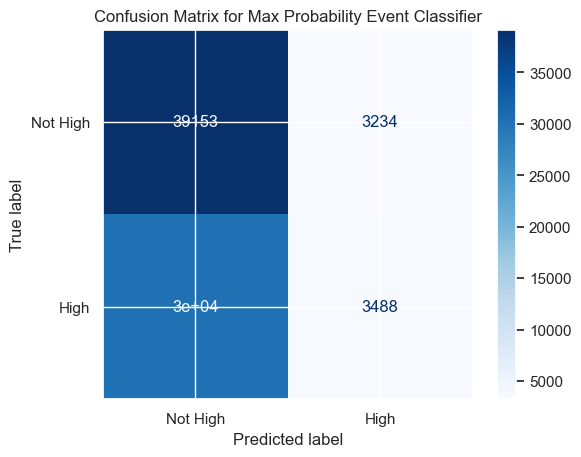

In [381]:
cm = confusion_matrix(y_rf_test, y_pred_max_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Max Probability Event Classifier")
plt.show()


In [382]:
print(f"precision: {precision_score(y_rf_test, y_pred_max_prob):.3f}")
print(f"% possible trades : {100*y_pred_max_prob.sum() / y_pred_max_prob.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_max_prob.sum() / y_pred_max_prob.shape[0]:.0f}")


precision: 0.519
% possible trades : 8.83%
nb trade per day : 25


#### On 100 best prob

In [383]:
idx_best = df_prob_comb_high_event["p_high"].sort_values(ascending=False).head(100).index.values
idx_best

array([103194, 100035, 210519, 196209, 210438, 102519, 108999, 216594,
       102573, 196128,  92637, 216675,  99846, 103221, 109431, 212301,
       108729,  45603,  85671, 209763,  47034, 210654, 101817, 217350,
       104679, 212220,  85617, 109107,  89343, 213705, 196344, 106893,
       107622, 107136, 213651,  47277,  88236, 104922,  92583, 213786,
        94014, 209466,  45657,  76923, 103113,  95040,  70686, 103410,
       210735, 213921,  65016,  66123,  94257, 212166,  99981, 210330,
        67554, 101412, 194832,  45468, 102006, 195750,  73224, 190701,
        18144, 214812, 195453,  45333, 100332, 215271, 100872, 198504,
        90774,  92448, 214488, 196425, 109350, 196074, 101655,  38934,
        71793, 217431,  73467, 191943, 212436,  27621,  65853, 196020,
       214002, 214407, 176202,  89289,  67797, 216243, 203742,  94419,
       217917, 199746,  91017,  47439])

In [384]:
df_prob_comb_high_event.loc[idx_best]

high   low  neutral    p_high     p_low  delta_prob          feat_0  \
103194  8067  6070     1260  0.523933  0.394233  564.194525     Low_ETH_cat   
100035  8262  6200     1321  0.523475  0.392828  588.002213  vwap_d_ETH_cat   
210519  8594  6501     1356  0.522400  0.395174  580.410600  vwap_d_ETH_cat   
196209  8796  6635     1411  0.522266  0.393956  605.264856  vwap_d_ETH_cat   
210438  8980  6837     1381  0.522154  0.397546  580.697857  vwap_d_ETH_cat   
...      ...   ...      ...       ...       ...         ...             ...   
94419   9144  7011     1447  0.519486  0.398307  563.254596  vwap_d_ETH_cat   
217917  9424  7207     1510  0.519486  0.397277  591.075582     Low_ETH_cat   
199746  9363  7215     1446  0.519474  0.400300  556.629750    High_ETH_cat   
91017   9363  7215     1446  0.519474  0.400300  556.629750    High_ETH_cat   
47439   9418  7181     1531  0.519470  0.396084  602.948250  vwap_h_ETH_cat   

       feat_0_cat  lag_0               feat_1  ... lag_1               feat_2  \
103194       high     68       vwap_d_ETH_cat  ...    70  ichi_tenkan_ETH_cat   
100035       high     68          Low_ETH_cat  ...    68  ichi_tenkan_ETH_cat   
210519       high     70  ichi_tenkan_ETH_cat  ...    70         Open_ETH_cat   
196209       high     68  ichi_tenkan_ETH_cat  ...    70         Open_ETH_cat   
210438       high     70  ichi_tenkan_ETH_cat  ...    70         High_ETH_cat   
...           ...    ...                  ...  ...   ...                  ...   
94419        high     64  ichi_tenkan_ETH_cat  ...    70         High_ETH_cat   
217917       high     64       vwap_d_ETH_cat  ...    71         High_ETH_cat   
199746       high     64  ichi_tenkan_ETH_cat  ...    70       vwap_d_ETH_cat   
91017        high     64       vwap_d_ETH_cat  ...    71  ichi_tenkan_ETH_cat   
47439        high     56  ichi_tenkan_ETH_cat  ...    70         High_ETH_cat   

       feat_2_cat lag_2  days_with_event  weeks_with_event  months_with_event  \
103194       high    70              845               126                 29   
100035       high    70              849               126                 29   
210519       high    68              845               126                 29   
196209       high    68              847               126                 29   
210438       high    68              842               126                 29   
...           ...   ...              ...               ...                ...   
94419        high    40              844               126                 29   
217917       high    68              824               126                 29   
199746       high    71              819               126                 29   
91017        high    70              819               126                 29   
47439        high    40              852               126                 29   

        ratio_days_with_event  ratio_weeks_with_event  ratio_months_with_event  
103194               0.959137                0.992126                      1.0  
100035               0.963678                0.992126                      1.0  
210519               0.959137                0.992126                      1.0  
196209               0.961407                0.992126                      1.0  
210438               0.955732                0.992126                      1.0  
...                       ...                     ...                      ...  
94419                0.958002                0.992126                      1.0  
217917               0.935301                0.992126                      1.0  
199746               0.929625                0.992126                      1.0  
91017                0.929625                0.992126                      1.0  
47439                0.967083                0.992126                      1.0  

[100 rows x 21 columns]

In [385]:
X_rf_test[idx_best]

103194  100035  210519  196209  210438  102519  108999  \
date_ETH                                                                      
2024-09-08 13:45:00   False   False   False   False   False   False   False   
2024-09-08 13:50:00   False   False   False   False   False   False   False   
2024-09-08 13:55:00   False   False   False   False   False   False   False   
2024-09-08 14:00:00   False   False   False   False   False   False   False   
2024-09-08 14:05:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False    True   False    True   
2025-05-30 19:30:00    True    True    True    True    True    True    True   
2025-05-30 19:35:00    True    True    True    True    True    True    True   

                     216594  102573  196128  ...  176202  89289   67797   \
date_ETH                                     ...                           
2024-09-08 13:45:00   False   False   False  ...   False   False   False   
2024-09-08 13:50:00   False   False   False  ...   False   False   False   
2024-09-08 13:55:00   False   False   False  ...   False   False   False   
2024-09-08 14:00:00   False   False   False  ...   False   False   False   
2024-09-08 14:05:00   False   False   False  ...   False   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00    True   False    True  ...    True   False    True   
2025-05-30 19:30:00    True    True    True  ...    True    True    True   
2025-05-30 19:35:00    True    True    True  ...    True    True    True   

                     216243  203742  94419   217917  199746  91017   47439   
date_ETH                                                                     
2024-09-08 13:45:00   False   False   False   False   False   False   False  
2024-09-08 13:50:00   False   False   False   False   False   False   False  
2024-09-08 13:55:00   False   False   False   False   False   False   False  
2024-09-08 14:00:00   False   False   False   False   False   False   False  
2024-09-08 14:05:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00    True    True    True    True    True    True    True  
2025-05-30 19:30:00    True    True    True    True    True    True    True  
2025-05-30 19:35:00    True    True    True    True    True    True    True  

[76104 rows x 100 columns]

In [386]:
df_event_best_probs = X_rf_test[idx_best].multiply(df_prob_comb_high_event.loc[idx_best]['p_high'], axis='columns')
df_event_best_probs

103194    100035  210519    196209    210438    102519  \
date_ETH                                                                        
2024-09-08 13:45:00  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000   
2024-09-08 13:50:00  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000   
2024-09-08 13:55:00  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000   
2024-09-08 14:00:00  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000   
2024-09-08 14:05:00  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000   
...                       ...       ...     ...       ...       ...       ...   
2025-05-30 19:15:00  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000   
2025-05-30 19:20:00  0.000000  0.000000  0.0000  0.000000  0.000000  0.000000   
2025-05-30 19:25:00  0.000000  0.000000  0.0000  0.000000  0.522154  0.000000   
2025-05-30 19:30:00  0.523933  0.523475  0.5224  0.522266  0.522154  0.522049   
2025-05-30 19:35:00  0.523933  0.523475  0.5224  0.522266  0.522154  0.522049   

                       108999    216594    102573    196128  ...    176202  \
date_ETH                                                     ...             
2024-09-08 13:45:00  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
2024-09-08 13:50:00  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
2024-09-08 13:55:00  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
2024-09-08 14:00:00  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
2024-09-08 14:05:00  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
...                       ...       ...       ...       ...  ...       ...   
2025-05-30 19:15:00  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
2025-05-30 19:20:00  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
2025-05-30 19:25:00  0.521989  0.521941  0.000000  0.521826  ...  0.519545   
2025-05-30 19:30:00  0.521989  0.521941  0.521935  0.521826  ...  0.519545   
2025-05-30 19:35:00  0.521989  0.521941  0.521935  0.521826  ...  0.519545   

                      89289     67797     216243    203742    94419   \
date_ETH                                                               
2024-09-08 13:45:00  0.00000  0.000000  0.000000  0.000000  0.000000   
2024-09-08 13:50:00  0.00000  0.000000  0.000000  0.000000  0.000000   
2024-09-08 13:55:00  0.00000  0.000000  0.000000  0.000000  0.000000   
2024-09-08 14:00:00  0.00000  0.000000  0.000000  0.000000  0.000000   
2024-09-08 14:05:00  0.00000  0.000000  0.000000  0.000000  0.000000   
...                      ...       ...       ...       ...       ...   
2025-05-30 19:15:00  0.00000  0.000000  0.000000  0.000000  0.000000   
2025-05-30 19:20:00  0.00000  0.000000  0.000000  0.000000  0.000000   
2025-05-30 19:25:00  0.00000  0.519526  0.519526  0.519489  0.519486   
2025-05-30 19:30:00  0.51954  0.519526  0.519526  0.519489  0.519486   
2025-05-30 19:35:00  0.51954  0.519526  0.519526  0.519489  0.519486   

                       217917    199746    91017    47439   
date_ETH                                                    
2024-09-08 13:45:00  0.000000  0.000000  0.000000  0.00000  
2024-09-08 13:50:00  0.000000  0.000000  0.000000  0.00000  
2024-09-08 13:55:00  0.000000  0.000000  0.000000  0.00000  
2024-09-08 14:00:00  0.000000  0.000000  0.000000  0.00000  
2024-09-08 14:05:00  0.000000  0.000000  0.000000  0.00000  
...                       ...       ...       ...      ...  
2025-05-30 19:15:00  0.000000  0.000000  0.000000  0.00000  
2025-05-30 19:20:00  0.000000  0.000000  0.000000  0.00000  
2025-05-30 19:25:00  0.519486  0.519474  0.519474  0.51947  
2025-05-30 19:30:00  0.519486  0.519474  0.519474  0.51947  
2025-05-30 19:35:00  0.519486  0.519474  0.519474  0.51947  

[76104 rows x 100 columns]

In [387]:
max_best_prob_test = df_event_best_probs.max(axis=1)
max_best_prob_test

date_ETH
2024-09-08 13:45:00    0.000000
2024-09-08 13:50:00    0.000000
2024-09-08 13:55:00    0.000000
2024-09-08 14:00:00    0.000000
2024-09-08 14:05:00    0.000000
                         ...   
2025-05-30 19:15:00    0.000000
2025-05-30 19:20:00    0.000000
2025-05-30 19:25:00    0.522154
2025-05-30 19:30:00    0.523933
2025-05-30 19:35:00    0.523933
Length: 76104, dtype: float64

In [388]:
y_pred_max_best_prob = max_best_prob_test > 0.5239

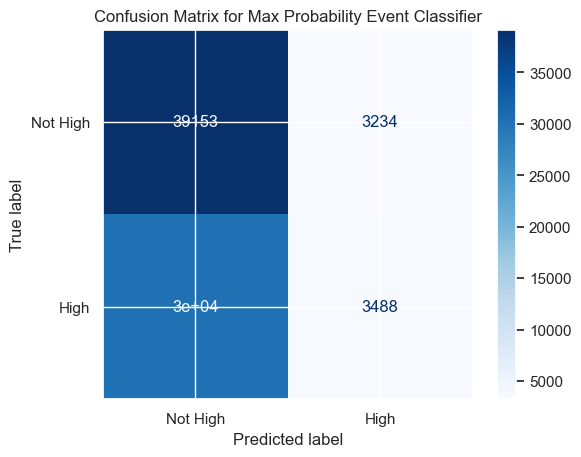

In [389]:
cm = confusion_matrix(y_rf_test, y_pred_max_best_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Max Probability Event Classifier")
plt.show()

In [390]:
print(f"precision: {precision_score(y_rf_test, y_pred_max_best_prob):.3f}")
print(f"% possible trades : {100*y_pred_max_best_prob.sum() / y_pred_max_best_prob.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_max_best_prob.sum() / y_pred_max_best_prob.shape[0]:.0f}")


precision: 0.519
% possible trades : 8.83%
nb trade per day : 25


Exact same than All max prob : logical

### Mean Prob Model

In [391]:
df_event_probs = X_rf_test.multiply(df_prob_comb_high_event['p_high'], axis='columns')

df_prob_comb_high_event["p_high"]

0         0.495705
13        0.401802
20        0.418611
23        0.415603
27        0.496224
            ...   
219202    0.401609
219212    0.417739
219237    0.473865
219238    0.405358
219239    0.412869
Name: p_high, Length: 27660, dtype: float64

In [392]:
X_rf_test.shape

(76104, 27660)

In [393]:
arr_sum = (X_rf_test.values) @ (df_prob_comb_high_event["p_high"].values)


In [394]:
nb_true = X_rf_test.sum(axis=1).values

In [395]:
arr_mean_prob = arr_sum / nb_true

In [396]:
y_pred_mean_prob = arr_mean_prob > 0.5067

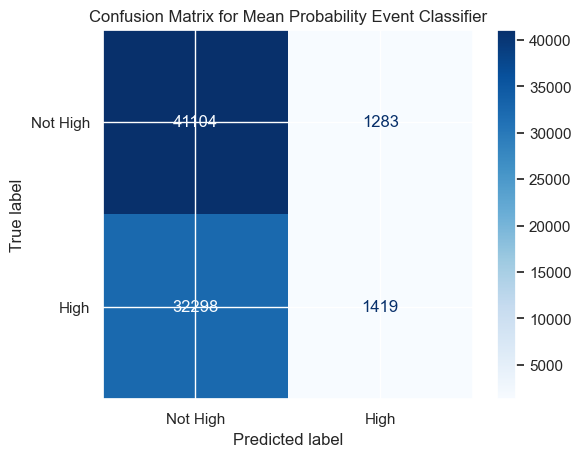

In [397]:
cm = confusion_matrix(y_rf_test, y_pred_mean_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Mean Probability Event Classifier")
plt.show()

In [398]:
print(f"precision: {precision_score(y_rf_test, y_pred_mean_prob):.3f}")
print(f"% possible trades : {100*y_pred_mean_prob.sum() / y_pred_mean_prob.shape[0]:.2f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_prob.sum() / y_pred_mean_prob.shape[0]:.0f}")


precision: 0.525
% possible trades : 3.55%
nb trade per day : 10


Better precision with mean prob model
- close to Best event : precision = 0.518

#### On 100 best prob

In [399]:
arr_best_sum = (X_rf_test[idx_best].values) @ (df_prob_comb_high_event.loc[idx_best]["p_high"].values)

In [400]:
nb_best_true = X_rf_test[idx_best].sum(axis=1).values

In [401]:
arr_mean_best_prob = arr_best_sum / nb_best_true

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_65244/2913283874.py:1: RuntimeWarning: invalid value encountered in divide
  arr_mean_best_prob = arr_best_sum / nb_best_true


In [402]:
arr_mean_best_prob

array([       nan,        nan,        nan, ..., 0.52025209, 0.52045136,
       0.52042486], shape=(76104,))

In [403]:
y_pred_mean_best_prob = arr_mean_best_prob > 0.52044 #0.52044

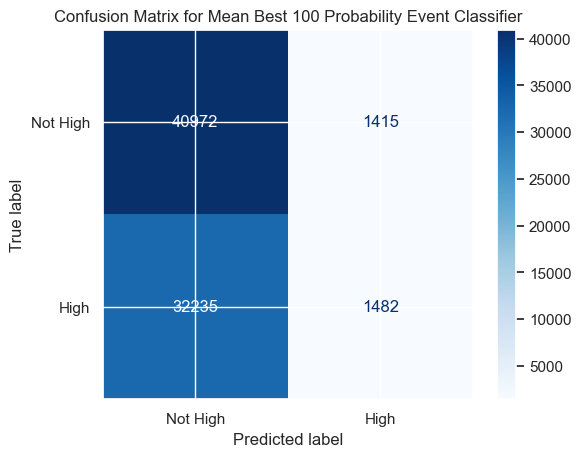

In [404]:
cm = confusion_matrix(y_rf_test, y_pred_mean_best_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Mean Best 100 Probability Event Classifier")
plt.show()

In [405]:
print(f"precision: {precision_score(y_rf_test, y_pred_mean_best_prob):.3f}")
print(f"% possible trades : {100*y_pred_mean_best_prob.sum() / y_pred_mean_best_prob.shape[0]:.2f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_best_prob.sum() / y_pred_mean_best_prob.shape[0]:.0f}")


precision: 0.512
% possible trades : 3.81%
nb trade per day : 11


Not better than all mean prob

# TODO

In [406]:
# DONE : optimize corr calculation
# DONE : evaluate value of target_14 in term of real variation % between high and low 
# DONE : cross : find cat combinaison with most prob diff between high and low (linked to chi2 not always but a little)
# DONE : change algo for target cat : buy/sell with TP/SL = 2 (if +0.1% TP => -0.05% SL)
# DONE : past history: select the lags exponentially on the past history (not linear: example 5 min ago, 10 min, 20 min, 40 min, 1h20, 2h40, 5h20 ago)
# DONE : cross best over all lags : find cat combinaison with most prob diff between high and low (linked to chi2 ?)
# DONE : check temporal repartition of interesting events
# DONE : maybe have a threshold on target instead of quantiles?
# DONE : test another target : maybe the max/min value on all targets to have ony 2 targets
# DONE : cross prob with selected features with best corr with targets
# DONE : cross prob with selected features with best chi2 with targets
# DONE : machine learning classification with selected features with RandomForest 
# DONE : Take best cross prob (3 feat) and check when several occurs on same time to see if prob increase
# DONE : change prob model (particularly threshold) to have same 10 trades per day minimum and best precision
# DONE : Check Max prob Model limited to 100 best probs : why same results compared to without limit mode? 
# DONE : Add check comb2 model with Max prob or mean prob mdl (using 6 events (2*3 comb event))
# TODO : Change to price dependant features for ATR indices and z-score ETH
# TODO : Redo study by limited cat features (27000 max) with TRAIN/TEST split ? 
# TODO : ML study on all limited cat features (27000 max) with best ML model : RF, XGBoost, KNN ...
# TODO : Clustering on train data with normal features (no feat categories) to find clusters with high/low/neutral targets ?
# TODO : backtest strat on df_train / df_test data with model RF
# TODO : backtest strat on df_train / df_test data with model High Prob Event ? data leak of test data ? redo on TRAIN only ?

# TODO : test with a 40/40/20 for feature cat : H/L/N instead of 10/10/80

# TODO : create a new exploration notebook for a target of daily trading : (currently : 6 hours history to predict next 1h)
#        - find good time frame / PAST_HISTORY / FUTURE_TARGET

In [407]:
len(list_col_select)

108

In [408]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [409]:
# how many combinaison of 3 elements in len(list_col_select) * nb lags
nb_elements = len(list_col_select) * len(list_past)
nb_comb = nb_elements * (nb_elements-1) * (nb_elements-2)
nb_comb


430368120

It s too much

In [410]:
# how many combinaison of 3 elements in 40 selected comb (feat / lag) 
# (20 high target /20 low target and with max or min delta_prob)
nb_elements = 40
print(nb_elements, " elements")
nb_comb = nb_elements * (nb_elements-1) * (nb_elements-2)
nb_comb

40  elements


59280

Ok 